In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt


#Agent的行動
class Actions(Enum):
    Sell = 0
    Buy = 1

#在Env裡面所代表的
class Positions(Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

    
class TradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}
    
    #__init__為魔法函數，意義為：無論你願不願意，只要你執行TradingEnv，就會把__init__底下的資料執行，可以用作變數定義？
    def __init__(self, df, window_size): 
        assert df.ndim == 2 #判斷所輸入的df維度是否等於2

        self.seed() #隨機種子設定
        self.df = df #輸入df
        self.window_size = window_size #輸入Windows size
        self.open, self.close, self.high, self.low, self.volume, self.date, self.signal_features = self._process_data() #輸入【價錢, 特征資料】
        self.shape = (window_size, self.signal_features.shape[1]) #輸入【Windows size, 特征資料的長度】

        # spaces
        self.action_space = spaces.Discrete(len(Actions)) # 行動空間為：2（Sell、Buy）
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float64) #觀察空間最低和最高為無限（因為不知股票價錢為多少）

        # episode
        #「_」為私有化，即import的時候不會引入參數
        self._start_tick = self.window_size #開始日期：Windows_size設定的數字
        self._end_tick = len(self.close)-1 #結束日期：【價錢】的長度-1
        self._done = None 
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        
        #股息
        import yfinance as yf
        self.Ticker = yf.Ticker("2330.TW")#抓取股票
        self.Dividends = self.Ticker.actions['Dividends']#抓取股息資料
        self.Dividends_Date = self.Dividends.index.astype('string')#將股息日期->String
        self.Dividends_Date = np.array(self.Dividends_Date)#將股息日期->np.array
        self.Dividends = np.array(self.Dividends) #抓取股息價錢
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓        
        self._reward_history = []#記錄Reward獎勵，方便畫圖
        self._Total_profit = []#記錄Profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None
        self.history = None

    #定義一個隨機種子   
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    #重設
    def reset(self):
        self._done = False #尚未完成
        self._current_tick = self._start_tick # Windows_size設定的數字
        self._last_trade_tick = self._current_tick -1 #Windows_size設定的數字-1
        self._position = Positions.Short #第一天交易必定為Short
        self._position_history = (self.window_size * [None]) + [self._position] #記錄位置
        self._total_reward = 0. #初始化的reward為：0
        self._total_profit = 1. #初始化的Profit為：1
        self._first_rendering = True
        self.history = {}
        return self._get_observation()

    #交易中的步驟
    def step(self, action):
        self._done = False #尚未完成動作
        
        
        #如果當前日期 = 完結日期，就結束步驟
        if self._current_tick == self._end_tick:
            self._done = True

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
#如果機器人進行買的動作，他的Position就會變成Long，反之亦然
        if(action == Actions.Buy.value):
            self._position = Positions.Long
#             print("action: ", action)
#             print("position: ", self._position)
        elif(action == Actions.Sell.value):
            self._position = Positions.Short
#             print("action: ", action)
#             print("position: ", self._position)
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑               
        self._last_trade_tick = self._current_tick      
        #記錄步驟
        self._position_history.append(self._position)
        
        #獎勵：調用計算獎勵的function，然後將它累積起來計算總和
        step_reward = self._calculate_reward(action)
        step_profit = self._update_profit(action)#記錄profit，方便畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
        self._reward_history.append(step_reward)#記錄Reward獎勵，方便畫圖
        self._Total_profit.append(step_profit)#記錄profit，方便畫圖
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ 
        self._total_reward += step_reward
        #根據agent的action更新他的 profit
        
        
        observation = self._get_observation()
        info = dict(
            total_reward = self._total_reward,
            total_profit = self._total_profit,
            position = self._position.value
        )
        self._update_history(info)
        
        self._current_tick += 1 #當前日期+1

        return observation, step_reward, self._done, info

    #取得觀察值，觀察值為signal_features
    #若window_size為10
    #則使用0 ~ 9日的觀察值，下一次交易則使用1 ~ 10日的觀察值
    def _get_observation(self):
        return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

    #更新歷史資料
    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    #render：將環境實體化，以股票交易為例即是畫圖
    def render(self, mode='human'):
        pass


    #畫圖
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓    
    def render_Close(self, mode='human'):
            window_ticks = np.arange(len(self._position_history))#[1,2,3,4,5,....]矩陣
            plt.plot(self.close)#根據收盤價進行繪畫

            short_ticks = []
            long_ticks = []
            # i：控制position_history的位置
            # tick：控制要塞進Long還是Short的位置
            #如果機器人在之前就是做Long的話就把它記錄在long_ticks裡面，反之亦然
            for i, tick in enumerate(window_ticks-1):
                if self._position_history[i] == Positions.Short:
                    short_ticks.append(tick)
                elif self._position_history[i] == Positions.Long:
                    long_ticks.append(tick)      

            del(short_ticks[0])

            plt.plot(short_ticks, self.close[short_ticks], 'ro', label = 'Short')#根據收盤價進行畫圖
            plt.plot(long_ticks, self.close[long_ticks], 'go', label = 'Long')#根據收盤價進行畫圖
            
            plt.legend()
            plt.title("Close", fontsize=20)
            plt.suptitle(
                "Total Reward: %.6f" % self._total_reward + ' ~ ' +
                "Total Profit: %.6f" % self._total_profit
            )
            print("↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓")
        
        
    #畫圖2   
    def render_Reward(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks-1):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)
        
        del(short_ticks[0])
        self._reward_history = np.array(self._reward_history)
        short_ticks = (np.array(short_ticks)-10).tolist()
        long_ticks = (np.array(long_ticks)-10).tolist()
        
        plt.bar(short_ticks,self._reward_history[short_ticks], color='r', label = 'Short')#根據獎勵進行繪畫
        plt.bar(long_ticks,self._reward_history[long_ticks], color='g', label = 'Long')#根據獎勵進行繪畫
            
        plt.legend()   
        plt.title("Reward", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓")
        
        
    def render_TotalProfit(self, mode='human'):
        window_ticks = np.arange(len(self._position_history))
        
        del self._Total_profit[-1]
        plt.plot(self._Total_profit)
        
        
#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks-1):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)
        
#         del(short_ticks[0])
#         self._Total_profit = np.array(self._Total_profit)
#         short_ticks = (np.array(short_ticks)-10).tolist()
#         long_ticks = (np.array(long_ticks)-10).tolist()
        
#         plt.plot(short_ticks, self._Total_profit[short_ticks], 'ro', label = 'Short')#根據獎勵進行畫圖
#         plt.plot(long_ticks, self._Total_profit[long_ticks], 'go', label = 'Long')#根據獎勵進行畫圖
            
#         plt.legend() 

        plt.title("TotalProfit", fontsize=20)
        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward + ' ~ ' +
            "Total Profit: %.6f" % self._total_profit
        )
        print("↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓")
        plt.savefig('2330_BBands_TotalProfit.jpg')
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑         
        


    
    
    #關閉環境，即關閉畫圖    
    def close(self):
        plt.close()

    #保存圖片
    def save_rendering(self, filepath):
        plt.savefig(filepath)

    #暫停畫圖
    def pause_rendering(self):
        plt.show()

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _process_data(self):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _calculate_reward(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def _update_profit(self, action):
        pass

    #在TradingEnv中，為了保持結構完整，因此使用pass不做任何事情
    def max_possible_profit(self):  # trade fees are ignored
        pass

In [2]:
import numpy as np

class StocksEnv(TradingEnv):
    

    def __init__(self, df, window_size, frame_bound):
        assert len(frame_bound) == 2 #判斷所輸入的df維度是否等於2

        self.frame_bound = frame_bound #輸入範圍值
        super().__init__(df, window_size)

        self.trade_fee_percent = 0.001425+0.003
        #https://rich01.com/what-is-next-day-trading/
        
    #資料處理
    def _process_data(self):
        open = self.df.loc[:, 'open'].to_numpy() #prices：開市價
        close = self.df.loc[:, 'close'].to_numpy() #prices：收盤價
        high = self.df.loc[:, 'high'].to_numpy() #prices：最高
        low = self.df.loc[:, 'low'].to_numpy() #prices：最低
        volume = self.df.loc[:, 'volume'].to_numpy() #prices：成交量
        date = self.df.loc[:, 'index'].to_numpy() #prices：日期
        close[self.frame_bound[0] - self.window_size] # validate index (TODO: Improve validation)#驗證資料：10-10
        close = close[self.frame_bound[0]-self.window_size:self.frame_bound[1]]#【10-10:5600】
        
        
        diff = np.insert(np.diff(close), 0, 0)#計算價差【今天 - 昨天】
        signal_features = np.column_stack((close, diff))#默認的signal_features為：收盤價，價差

        return open, close ,high, low, volume, date, signal_features

#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
    #計算獎勵
    def _calculate_reward(self, action):
        step_reward = 0
        price_diff = 0
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string

        
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                    
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price #買入成本 = 今天收盤
                    Sold = last_trade_price #賣出成本 = 明天開盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本




                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price #買入成本 = 明天開盤
                    Sold = current_price #賣出成本 = 今天收盤

                    price_diff = Sold - Buy #盈虧 = 賣出成本 - 買入成本

        
            step_reward =  step_reward + price_diff
        
        return step_reward


    def _update_profit(self, action):
        
        long_profit_percentage = 0.0
        short_profit_percentage = 0.0
        Total_long_profit_percentage = 0.0
        Total_short_profit_percentage = 0.0
        
        date = self.date[self._current_tick].astype('datetime64[D]') #日期格式 -> yyyy-mm-dd格式
        date = date.astype('str')#日期格式 -> string
        
        step_profit = 0
        if(self._current_tick < self._end_tick):
            if( date not in self.Dividends_Date):#遇上除淨日不交易
                if(action == Actions.Buy.value):
                
                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = current_price
                    Sold = last_trade_price

                    price_diff = Sold - Buy#最後賺到的錢
                    long_profit_percentage = (Sold - Buy)/Buy
                    self._total_profit += long_profit_percentage

                elif(action == Actions.Sell.value):

                    current_price = self.close[self._current_tick]#【今天收盤】
                    last_trade_price = self.open[self._current_tick+1]#【明天開盤】

                    Buy = last_trade_price
                    Sold = current_price

                    price_diff = Sold - Buy#最後賺到的錢
                    short_profit_percentage = (Sold - Buy)/Buy 
                    self._total_profit += short_profit_percentage  
                       
                
            step_profit += self._total_profit #記錄profit，方便畫圖
        return step_profit#記錄profit，方便畫圖
        
#↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑  
                
    #https://github.com/AminHP/gym-anytrading/blob/master/README.ipynb
    #不論交易費用如何，agent在股票交易中所獲得的profit
    def max_possible_profit(self):
        pass

In [3]:
# import gym_anytrading
import numpy as np
import pandas as pd
import quantstats as qs
from stable_baselines import A2C

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



C:\Users\cherr\.conda\envs\Python37TensorFlow20V2\lib\site-packages\stable_baselines\__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [4]:
from yahoo_fin import stock_info as si
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
if isinstance('TSLA', str):
    # load it from yahoo_fin library
    df = si.get_data('TSLA')
df = df.dropna()#丟棄空值
df = df.reset_index()
pd.set_option('display.float_format', lambda x: '%.3f' % x)#設定顯示小數點後3位數

#---------------------------------------------------------------------------
#定義參數

open = df['open']
close = df['close']
high = df['high']
low = df['low']
volume = df['volume']
UpLine_max = []
UpLine = [] #上引線
DownLine_min = []
DownLine = [] #下引線
UpMean = []#計算RSI——上漲平均5天
DownMean = []#計算RSI——下跌平均5天
RSI = []#計算RSI

#---------------------------------------------------------------------------
#上引線；下引線

for i in range(close.size):
    UpLine_max.append(max(open[i], close[i]))
for i in range(close.size):
    UpLine.append(high[i] - UpLine_max[i])#上影線
for i in range(close.size):
    DownLine_min.append(min(open[i], close[i]))
for i in range(close.size):
    DownLine.append(DownLine_min[i] - low[i])#下影線
#---------------------------------------------------------------------------
#RSI

UpDownValue = close - close.shift(1) #計算漲跌值
Only_UpValue = pd.Series(index=UpDownValue.index, data=UpDownValue[UpDownValue>0])#將上漲日子篩出
Only_UpValue = Only_UpValue.fillna(0)#下跌的日子為0
Only_DownValue = pd.Series(index=UpDownValue.index, data=-UpDownValue[UpDownValue<0])#將下跌日子篩出
Only_DownValue = Only_DownValue.fillna(0)#上漲的日子為0
for i in range(13, len(Only_UpValue)+1):#由第六日開始，直到現在
    UpMean.append(np.mean(Only_UpValue.values[i-12:i]))#計算出最近五日的平均，因為有補0，所以可以計算出。
    DownMean.append(np.mean(Only_DownValue.values[i-12:i]))#計算出最近五日的平均
for i in range(len(UpMean)):
    RSI.append( (UpMean[i] / ( UpMean[i] + DownMean[i] )) * 100  )#計算RSI
RSI = pd.Series(index = close.index[12:], data = RSI) #轉換格式
#---------------------------------------------------------------------------
#FH；FL
FH = ((high - open) / open) #FH
FL = ((open - low) / open) #FL
FH = pd.DataFrame(FH, columns=['FH'])#FH參數
FL = pd.DataFrame(FL, columns=['FL'])#FL參數
#---------------------------------------------------------------------------
# KD
K = []
D = []
K_Value = []
D_Value = []
def RSV(df):
    df['MinLow'] = df['low'].rolling(9, min_periods=9).min()#9天最低位
    df['MinLow'].fillna(value = df['low'].expanding().min(), inplace = True)#填滿NA
    df['MaxHigh'] = df['high'].rolling(9, min_periods=9).max()#9天最高位
    df['MaxHigh'].fillna(value = df['high'].expanding().max(), inplace = True)#填滿NA
    df['RSV'] = (df['close'] - df['MinLow']) / (df['MaxHigh'] - df['MinLow']) * 100 #計算RSV
    return df
RSV_df = RSV(df)#使用RSV函數計算
RSV = RSV_df['RSV']#獲得RSV
for i in range(len(RSV)):
    if i<=9 :
        K.append(50)
        D.append(50)
    elif i > 9:
        K.append((K[i-1] * 2/3) + (1/3 * RSV[i]))
        D.append((D[i-1] * 2/3) + (1/3 * K[i]))
K_Value = pd.Series(index = close.index[0:], data = K) #轉換格式
D_Value = pd.Series(index = close.index[0:], data = D) #轉換格式
#---------------------------------------------------------------------------
# MACD
DIF = []
MACD = []
ShortEMA=close.ewm(span=12,adjust=False).mean()#12日移動平均
LongEMA=close.ewm(span=26,adjust=False).mean()#26日移動平均
FastLine_DIF=ShortEMA-LongEMA#DIF = （12日移動平均 - 26日移動平均）
SlowLine_MACD=FastLine_DIF.ewm(span=9,adjust=False).mean()#取DIF數值得到9日移動平均
FastLine_DIF = pd.DataFrame(FastLine_DIF)#轉換格式
SlowLine_MACD = pd.DataFrame(SlowLine_MACD)#轉換格式
FastLine_DIF = FastLine_DIF.rename(columns={'close':'DIF'})#轉換格式
SlowLine_MACD = SlowLine_MACD.rename(columns={'close':'MACD'})#轉換格式
#---------------------------------------------------------------------------                                                             
#BBands
def BBands(df,Day=20,Times=2):#20天平均, 2倍標準差
    Up_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Mid_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    Down_Track=pd.Series(0.0,index=df.index)#建立全0的陣列
    SD=pd.Series(0.0,index=df.index)#建立全0的陣列
    
    for i in range(Day-1,len(df)):#19~5600   
        Mid_Track[i]=np.mean(df[i-(Day-1):(i+1)])#中軌 = 0-20平均 -> 1-21平均 -> 2-22平均...（移動平均線）
        SD[i]=np.std(df[i-(Day-1):(i+1)])#0-20標準差 -> 1-21標準差 ->2-22標準差...（標準差）
        Up_Track[i]=Mid_Track[i]+(Times*SD[i])#上軌 = 中軌+（2倍標準差）
        Down_Track[i]=Mid_Track[i]-(Times*SD[i])#下軌 = 中軌-（2倍標準差）
        
        #慢慢地將上半部分建立的全0函式更新
        df_BBands=pd.DataFrame({'Up_Track':Up_Track[(Day-1):],#由第19日開始載入布林通道（上）
                             'Mid_Track':Mid_Track[(Day-1):],#由第19日開始載入布林通道（中）
                             'Down_Track':Down_Track[(Day-1):]#由第19日開始載入布林通道（下）
                            })
    return(df_BBands)
BBands_Up_Mid_Down_Trak = BBands(close, 20, 2)
#---------------------------------------------------------------------------
#成交量均線
volume10Day_mean=volume.ewm(span=10,adjust=False).mean() #10日移動平均成交量
volume10Day_mean = volume10Day_mean>volume #10日移動平均成交量 > 當日成交量【**技術指標**】
df_volume10day_mean=pd.DataFrame(volume10Day_mean) #變成DataFrame
labelencoder = LabelEncoder() #將True False 變成 1 0
df_volume10day_mean['volume'] = labelencoder.fit_transform(df_volume10day_mean['volume'])#將True False 變成 1 0
ct = ColumnTransformer([("volume", OneHotEncoder(), [0])], remainder = 'passthrough') #將1 0 變成 OneHotEncoder
df_volume10day_mean = ct.fit_transform(df_volume10day_mean)#將1 0 變成 OneHotEncoder
df_volume10day_mean = pd.DataFrame(df_volume10day_mean, columns = ['Volume_lower','Volume_greater'])
df_volume10day_mean['Volume_lower'] = pd.to_numeric(df_volume10day_mean['Volume_lower'], downcast='integer')
df_volume10day_mean['Volume_greater'] = pd.to_numeric(df_volume10day_mean['Volume_greater'], downcast='integer')







#合拼df
df2330 = pd.merge(df, FH,left_index=True,right_index=True) #合拼FH
df2330 = pd.merge(df2330, FL,left_index=True,right_index=True) #合拼FL
df2330 = pd.merge(df2330, pd.DataFrame(UpLine, columns=['UpLine']),left_index=True,right_index=True) #合併上影線
df2330 = pd.merge(df2330, pd.DataFrame(DownLine, columns=['DownLine']),left_index=True,right_index=True) #合併下影線
df2330 = pd.merge(df2330, pd.DataFrame(RSI, columns=['RSI']),left_index=True,right_index=True) #合併RSI
df2330 = pd.merge(df2330, pd.DataFrame(K_Value, columns=['K_Value']),left_index=True,right_index=True) #合併K值
df2330 = pd.merge(df2330, pd.DataFrame(D_Value, columns=['D_Value']),left_index=True,right_index=True) #合併D值
df2330 = pd.merge(df2330, pd.DataFrame(FastLine_DIF),left_index=True,right_index=True) #合併DIF
df2330 = pd.merge(df2330, pd.DataFrame(SlowLine_MACD),left_index=True,right_index=True) #合併MACD
df2330 = pd.merge(df2330,BBands_Up_Mid_Down_Trak,left_index=True,right_index=True) #合併布林通道
df2330 = pd.merge(df2330,df_volume10day_mean,left_index=True,right_index=True) #合併布林通道

df2330.index = range(len(df2330))#更新index

# 是否將特徵資料標準化？

In [5]:
#---------------------------------------------------------------------------
# normalizer = Normalizer()#創建標準化函數
# df2330_AllFeatures = df2330[['MinLow','MaxHigh','RSV','FH','FL','UpLine','DownLine','RSI','K_Value','D_Value','DIF','MACD','Up_Track','Mid_Track','Down_Track']]#取得需要標準化的特徵
# df2330_FeaturesNormalize = normalizer.fit_transform(df2330_AllFeatures)#進行標準化
# df2330_FeaturesNormalize = pd.DataFrame(df2330_FeaturesNormalize)#將array變成df
# df2330_FeaturesNormalize = df2330_FeaturesNormalize.rename(columns={0:'MinLow',1:'MaxHigh',2:'RSV',
#                                                       3:'FH',4:'FL',
#                                                       5:'UpLine',6:'DownLine',
#                                                       7:'RSI',
#                                                       8:'K_Value',9:'D_Value',
#                                                       10:'DIF',11:'MACD',
#                                                       12:'Up_Track',13:'Mid_Track',14:'Down_Track'})#更改名字
# df2330_OriginData = df2330[['index','open','high','low','close','adjclose','volume','ticker']]#取得市場基本資料
# df2330_Normalized = pd.merge(df2330_OriginData, df2330_FeaturesNormalize, left_index=True,right_index=True) #基本資料與標準化後特徵資料合併
# df2330 = df2330_Normalized
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
#輸出最終Dataframe
df = df2330
df

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
0,2010-07-27,1.394,1.412,1.351,1.370,1.370,9295500,TSLA,1.267,1.483,...,68.083,65.280,69.781,-0.027,-0.049,1.623,1.325,1.026,0,1
1,2010-07-28,1.370,1.393,1.367,1.381,1.381,7008000,TSLA,1.300,1.483,...,71.512,58.308,65.957,-0.023,-0.044,1.588,1.314,1.041,0,1
2,2010-07-29,1.385,1.392,1.333,1.357,1.357,9240000,TSLA,1.300,1.483,...,64.149,49.175,60.363,-0.023,-0.040,1.547,1.303,1.058,0,1
3,2010-07-30,1.347,1.363,1.303,1.329,1.329,6403500,TSLA,1.300,1.457,...,50.767,39.025,53.250,-0.024,-0.036,1.529,1.296,1.063,0,1
4,2010-08-02,1.367,1.398,1.355,1.395,1.395,10771500,TSLA,1.300,1.437,...,56.913,48.994,51.831,-0.019,-0.033,1.539,1.302,1.065,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167,2023-02-24,196.330,197.670,192.800,196.880,196.880,142228100,TSLA,187.610,217.650,...,50.043,44.797,55.241,12.738,14.454,219.162,195.008,170.855,0,1
3168,2023-02-27,202.030,209.420,201.260,207.630,207.630,161028300,TSLA,189.440,217.650,...,53.588,51.358,53.947,12.556,14.074,219.902,196.495,173.088,0,1
3169,2023-02-28,210.590,211.230,203.750,205.710,205.710,153144900,TSLA,191.780,217.650,...,49.045,52.188,53.361,12.116,13.683,217.724,198.448,179.171,0,1
3170,2023-03-01,206.210,207.200,198.520,202.770,202.770,156852800,TSLA,191.780,217.650,...,53.830,48.952,51.891,11.399,13.226,215.394,199.925,184.456,0,1


# 查找DF的標籤

In [6]:
dfStartDate_Train = df[(df['index']=='2020-01-02')].index.values
dfStartDate_Train = dfStartDate_Train[0]
dfStartDate_Train

2375

In [7]:
dfEndDate_Train = df[(df['index']=='2022-12-30')].index.values
dfEndDate_Train = dfEndDate_Train[0]
dfEndDate_Train

3130

In [8]:
df[dfStartDate_Train:dfEndDate_Train+1]

,index,open,high,low,close,adjclose,volume,ticker,MinLow,MaxHigh,...,RSI,K_Value,D_Value,DIF,MACD,Up_Track,Mid_Track,Down_Track,Volume_lower,Volume_greater
2375,2020-01-02,28.300,28.713,28.114,28.684,28.684,142981500,TSLA,26.433,29.021,...,82.856,82.094,85.263,1.671,1.507,30.421,25.636,20.850,0,1
2376,2020-01-03,29.367,30.267,29.128,29.534,29.534,266677500,TSLA,26.679,30.267,...,81.063,81.255,83.927,1.731,1.552,30.803,26.003,21.202,1,0
2377,2020-01-06,29.365,30.104,29.333,30.103,30.103,151995000,TSLA,26.805,30.267,...,84.538,85.924,84.593,1.804,1.602,31.159,26.406,21.654,0,1
2378,2020-01-07,30.760,31.442,30.224,31.271,31.271,268231500,TSLA,26.805,31.442,...,85.017,89.384,86.190,1.933,1.668,31.679,26.850,22.022,1,0
2379,2020-01-08,31.580,33.233,31.215,32.809,32.809,467164500,TSLA,26.805,33.233,...,86.532,90.727,87.702,2.135,1.762,32.441,27.359,22.277,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,2022-12-23,126.370,128.620,121.020,123.150,123.150,166989700,TSLA,121.020,175.050,...,10.149,4.965,7.012,-17.245,-13.665,208.812,165.201,121.590,1,0
3127,2022-12-27,117.500,119.670,108.760,109.100,109.100,208643400,TSLA,108.760,161.620,...,8.383,3.524,5.849,-19.073,-14.747,210.643,161.510,112.377,1,0
3128,2022-12-28,110.350,116.270,108.240,112.710,112.710,221070500,TSLA,108.240,160.990,...,5.950,5.174,5.624,-20.000,-15.797,210.728,158.104,105.480,1,0
3129,2022-12-29,120.390,123.570,117.500,121.820,121.820,221923300,TSLA,108.240,160.990,...,18.571,12.031,7.760,-19.772,-16.592,206.533,154.460,102.387,1,0


In [9]:
def my_process_data(df, window_size, frame_bound):
    start = frame_bound[0] - window_size #start = 5 - 5
    end = frame_bound[1] #end = 5600 
    close = df.loc[:, 'close'].to_numpy()[start:end]#抓取Close
    open = df.loc[:, 'open'].to_numpy()[start:end]#抓取open
    high = df.loc[:, 'high'].to_numpy()[start:end]#抓取high
    low = df.loc[:, 'low'].to_numpy()[start:end]#抓取low
    volnume = df.loc[:, 'volume'].to_numpy()[start:end]#抓取volume
    date = df.loc[:, 'index'].to_numpy()[start:end]#抓取Date
    signal_features = df.loc[:, ['Volume_lower', 'Volume_greater']].to_numpy()[start:end]#抓取特徵資料
    return open, close, high, low, volnume, date, signal_features


class MyStocksEnv(StocksEnv):
    
    def __init__(self, open, close, high, low, volnume, date,signal_features, **kwargs):
        self._open = open
        self._close = close
        self._high = high
        self._low = low
        self._volnume = volnume
        self._date = date
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._open, self._close, self._high, self._low, self._volnume, self._date, self._signal_features

    
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date, signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Train, dfEndDate_Train+1))#「環境」整合

In [10]:
policy_kwargs = dict(net_arch=[128, 'lstm', dict(vf=[64,64,64], pi=[64,64,64])])#要傳遞給policy的參數

model = A2C('MlpLstmPolicy', env, verbose=1, policy_kwargs=policy_kwargs)
# model = A2C('MlpLstmPolicy', env, verbose=1)
#policy: The policy model to use (MlpPolicy, CnnPolicy, …)""
#verbose: 0 no output, 1 info, 2 debug
#policy_kwargs: additional arguments to be passed to the policy on creation要傳遞給policy的參數
model.learn(total_timesteps=5000000)

Wrapping the env in a DummyVecEnv.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


---------------------------------
| explained_variance | 0.0553   |
| fps                | 1        |
| nupdates           | 1        |
| policy_entropy     | 0.687    |
| total_timesteps    | 5        |
| value_loss         | 0.731    |
---------------------------------
---------------------------------
| explained_variance | -0.00533 |
| fps                | 80       |
| nupdates           | 100      |
| policy_entropy     | 0.688    |
| total_timesteps    | 500      |
| value_loss         | 19.6     |
---------------------------------
---------------------------------
| explained_variance | 0.00438

---------------------------------
| explained_variance | 0.00365  |
| fps                | 145      |
| nupdates           | 1500     |
| policy_entropy     | 0.028    |
| total_timesteps    | 7500     |
| value_loss         | 47.8     |
---------------------------------
---------------------------------
| explained_variance | 0.0019   |
| fps                | 145      |
| nupdates           | 1600     |
| policy_entropy     | 0.0145   |
| total_timesteps    | 8000     |
| value_loss         | 4.52     |
---------------------------------
---------------------------------
| explained_variance | 0.000727 |
| fps                | 145      |
| nupdates           | 1700     |
| policy_entropy     | 0.0153   |
| total_timesteps    | 8500     |
| value_loss         | 195      |
---------------------------------
---------------------------------
| explained_variance | -0.0012  |
| fps                | 144      |
| nupdates           | 1800     |
| policy_entropy     | 0.0142   |
| total_timest

---------------------------------
| explained_variance | 0.000258 |
| fps                | 134      |
| nupdates           | 4600     |
| policy_entropy     | 0.00658  |
| total_timesteps    | 23000    |
| value_loss         | 2.45     |
---------------------------------
---------------------------------
| explained_variance | 0.00424  |
| fps                | 134      |
| nupdates           | 4700     |
| policy_entropy     | 0.0077   |
| total_timesteps    | 23500    |
| value_loss         | 5.01     |
---------------------------------
---------------------------------
| explained_variance | 0.000353 |
| fps                | 134      |
| nupdates           | 4800     |
| policy_entropy     | 0.00483  |
| total_timesteps    | 24000    |
| value_loss         | 373      |
---------------------------------
----------------------------------
| explained_variance | -0.000789 |
| fps                | 134       |
| nupdates           | 4900      |
| policy_entropy     | 0.00539   |
| total_t

---------------------------------
| explained_variance | 0.000153 |
| fps                | 133      |
| nupdates           | 7600     |
| policy_entropy     | 0.00555  |
| total_timesteps    | 38000    |
| value_loss         | 2.88     |
---------------------------------
----------------------------------
| explained_variance | -0.000929 |
| fps                | 133       |
| nupdates           | 7700      |
| policy_entropy     | 0.00536   |
| total_timesteps    | 38500     |
| value_loss         | 34.5      |
----------------------------------
---------------------------------
| explained_variance | 0.000279 |
| fps                | 133      |
| nupdates           | 7800     |
| policy_entropy     | 0.00551  |
| total_timesteps    | 39000    |
| value_loss         | 22.7     |
---------------------------------
---------------------------------
| explained_variance | 0.000434 |
| fps                | 133      |
| nupdates           | 7900     |
| policy_entropy     | 0.00543  |
| tota

----------------------------------
| explained_variance | -0.000673 |
| fps                | 133       |
| nupdates           | 10600     |
| policy_entropy     | 0.0345    |
| total_timesteps    | 53000     |
| value_loss         | 0.15      |
----------------------------------
----------------------------------
| explained_variance | -0.000412 |
| fps                | 133       |
| nupdates           | 10700     |
| policy_entropy     | 0.0348    |
| total_timesteps    | 53500     |
| value_loss         | 942       |
----------------------------------
----------------------------------
| explained_variance | -0.000217 |
| fps                | 133       |
| nupdates           | 10800     |
| policy_entropy     | 0.038     |
| total_timesteps    | 54000     |
| value_loss         | 93.9      |
----------------------------------
---------------------------------
| explained_variance | -0.00127 |
| fps                | 133      |
| nupdates           | 10900    |
| policy_entropy     | 0

---------------------------------
| explained_variance | 0.000732 |
| fps                | 133      |
| nupdates           | 13600    |
| policy_entropy     | 0.0142   |
| total_timesteps    | 68000    |
| value_loss         | 13       |
---------------------------------
---------------------------------
| explained_variance | 0.000163 |
| fps                | 133      |
| nupdates           | 13700    |
| policy_entropy     | 0.0138   |
| total_timesteps    | 68500    |
| value_loss         | 458      |
---------------------------------
----------------------------------
| explained_variance | -9.98e-05 |
| fps                | 133       |
| nupdates           | 13800     |
| policy_entropy     | 0.0113    |
| total_timesteps    | 69000     |
| value_loss         | 49.1      |
----------------------------------
----------------------------------
| explained_variance | -0.000545 |
| fps                | 133       |
| nupdates           | 13900     |
| policy_entropy     | 0.00813   |
|

---------------------------------
| explained_variance | 0.000413 |
| fps                | 133      |
| nupdates           | 16600    |
| policy_entropy     | 0.00922  |
| total_timesteps    | 83000    |
| value_loss         | 73.6     |
---------------------------------
---------------------------------
| explained_variance | -0.00232 |
| fps                | 133      |
| nupdates           | 16700    |
| policy_entropy     | 0.014    |
| total_timesteps    | 83500    |
| value_loss         | 4.28     |
---------------------------------
---------------------------------
| explained_variance | -0.00517 |
| fps                | 133      |
| nupdates           | 16800    |
| policy_entropy     | 0.0149   |
| total_timesteps    | 84000    |
| value_loss         | 2.44     |
---------------------------------
----------------------------------
| explained_variance | -0.000749 |
| fps                | 133       |
| nupdates           | 16900     |
| policy_entropy     | 0.0134    |
| total_t

---------------------------------
| explained_variance | 0.0155   |
| fps                | 133      |
| nupdates           | 19600    |
| policy_entropy     | 0.00807  |
| total_timesteps    | 98000    |
| value_loss         | 25.6     |
---------------------------------
---------------------------------
| explained_variance | 0.0472   |
| fps                | 133      |
| nupdates           | 19700    |
| policy_entropy     | 0.00898  |
| total_timesteps    | 98500    |
| value_loss         | 1.69     |
---------------------------------
---------------------------------
| explained_variance | -0.0276  |
| fps                | 133      |
| nupdates           | 19800    |
| policy_entropy     | 0.0123   |
| total_timesteps    | 99000    |
| value_loss         | 8.54     |
---------------------------------
---------------------------------
| explained_variance | 0.017    |
| fps                | 133      |
| nupdates           | 19900    |
| policy_entropy     | 0.0128   |
| total_timest

---------------------------------
| explained_variance | 0.0592   |
| fps                | 133      |
| nupdates           | 22700    |
| policy_entropy     | 0.00328  |
| total_timesteps    | 113500   |
| value_loss         | 0.12     |
---------------------------------
---------------------------------
| explained_variance | 0.0182   |
| fps                | 133      |
| nupdates           | 22800    |
| policy_entropy     | 0.00355  |
| total_timesteps    | 114000   |
| value_loss         | 47.6     |
---------------------------------
---------------------------------
| explained_variance | 1.66e-05 |
| fps                | 133      |
| nupdates           | 22900    |
| policy_entropy     | 0.00271  |
| total_timesteps    | 114500   |
| value_loss         | 54       |
---------------------------------
---------------------------------
| explained_variance | 0.00429  |
| fps                | 133      |
| nupdates           | 23000    |
| policy_entropy     | 0.00281  |
| total_timest

---------------------------------
| explained_variance | 0.0139   |
| fps                | 133      |
| nupdates           | 25800    |
| policy_entropy     | 0.00192  |
| total_timesteps    | 129000   |
| value_loss         | 90.7     |
---------------------------------
---------------------------------
| explained_variance | -0.0128  |
| fps                | 133      |
| nupdates           | 25900    |
| policy_entropy     | 0.00183  |
| total_timesteps    | 129500   |
| value_loss         | 237      |
---------------------------------
---------------------------------
| explained_variance | -0.00181 |
| fps                | 133      |
| nupdates           | 26000    |
| policy_entropy     | 0.00196  |
| total_timesteps    | 130000   |
| value_loss         | 28.3     |
---------------------------------
---------------------------------
| explained_variance | 0.0104   |
| fps                | 133      |
| nupdates           | 26100    |
| policy_entropy     | 0.00246  |
| total_timest

---------------------------------
| explained_variance | 0.121    |
| fps                | 133      |
| nupdates           | 28900    |
| policy_entropy     | 0.000242 |
| total_timesteps    | 144500   |
| value_loss         | 0.238    |
---------------------------------
---------------------------------
| explained_variance | 0.0337   |
| fps                | 133      |
| nupdates           | 29000    |
| policy_entropy     | 0.000269 |
| total_timesteps    | 145000   |
| value_loss         | 103      |
---------------------------------
---------------------------------
| explained_variance | -0.00558 |
| fps                | 133      |
| nupdates           | 29100    |
| policy_entropy     | 0.000285 |
| total_timesteps    | 145500   |
| value_loss         | 81.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0402   |
| fps                | 133      |
| nupdates           | 29200    |
| policy_entropy     | 0.000261 |
| total_timest

---------------------------------
| explained_variance | -0.026   |
| fps                | 133      |
| nupdates           | 32000    |
| policy_entropy     | 0.000291 |
| total_timesteps    | 160000   |
| value_loss         | 72.2     |
---------------------------------
---------------------------------
| explained_variance | 0.0312   |
| fps                | 133      |
| nupdates           | 32100    |
| policy_entropy     | 0.000318 |
| total_timesteps    | 160500   |
| value_loss         | 38.6     |
---------------------------------
---------------------------------
| explained_variance | -0.29    |
| fps                | 133      |
| nupdates           | 32200    |
| policy_entropy     | 0.00036  |
| total_timesteps    | 161000   |
| value_loss         | 44.4     |
---------------------------------
---------------------------------
| explained_variance | -0.0589  |
| fps                | 133      |
| nupdates           | 32300    |
| policy_entropy     | 0.000331 |
| total_timest

---------------------------------
| explained_variance | 0.182    |
| fps                | 133      |
| nupdates           | 35100    |
| policy_entropy     | 0.000318 |
| total_timesteps    | 175500   |
| value_loss         | 2.35     |
---------------------------------
---------------------------------
| explained_variance | -0.00479 |
| fps                | 133      |
| nupdates           | 35200    |
| policy_entropy     | 0.000343 |
| total_timesteps    | 176000   |
| value_loss         | 34.3     |
---------------------------------
---------------------------------
| explained_variance | 0.3      |
| fps                | 133      |
| nupdates           | 35300    |
| policy_entropy     | 0.000379 |
| total_timesteps    | 176500   |
| value_loss         | 9.19     |
---------------------------------
---------------------------------
| explained_variance | 0.42     |
| fps                | 133      |
| nupdates           | 35400    |
| policy_entropy     | 0.000312 |
| total_timest

---------------------------------
| explained_variance | -0.016   |
| fps                | 133      |
| nupdates           | 38200    |
| policy_entropy     | 0.000384 |
| total_timesteps    | 191000   |
| value_loss         | 48.6     |
---------------------------------
---------------------------------
| explained_variance | 0.159    |
| fps                | 133      |
| nupdates           | 38300    |
| policy_entropy     | 0.000592 |
| total_timesteps    | 191500   |
| value_loss         | 31.1     |
---------------------------------
---------------------------------
| explained_variance | -0.0304  |
| fps                | 133      |
| nupdates           | 38400    |
| policy_entropy     | 0.000559 |
| total_timesteps    | 192000   |
| value_loss         | 5.46     |
---------------------------------
---------------------------------
| explained_variance | 0.149    |
| fps                | 133      |
| nupdates           | 38500    |
| policy_entropy     | 0.000496 |
| total_timest

---------------------------------
| explained_variance | -0.485   |
| fps                | 133      |
| nupdates           | 41300    |
| policy_entropy     | 0.000657 |
| total_timesteps    | 206500   |
| value_loss         | 2.8      |
---------------------------------
---------------------------------
| explained_variance | 0.0271   |
| fps                | 133      |
| nupdates           | 41400    |
| policy_entropy     | 0.000478 |
| total_timesteps    | 207000   |
| value_loss         | 109      |
---------------------------------
---------------------------------
| explained_variance | -0.797   |
| fps                | 133      |
| nupdates           | 41500    |
| policy_entropy     | 0.000984 |
| total_timesteps    | 207500   |
| value_loss         | 1.37     |
---------------------------------
---------------------------------
| explained_variance | -10.5    |
| fps                | 133      |
| nupdates           | 41600    |
| policy_entropy     | 0.000556 |
| total_timest

---------------------------------
| explained_variance | 0.179    |
| fps                | 133      |
| nupdates           | 44400    |
| policy_entropy     | 0.00127  |
| total_timesteps    | 222000   |
| value_loss         | 137      |
---------------------------------
---------------------------------
| explained_variance | 0.0372   |
| fps                | 133      |
| nupdates           | 44500    |
| policy_entropy     | 0.00249  |
| total_timesteps    | 222500   |
| value_loss         | 21.8     |
---------------------------------
---------------------------------
| explained_variance | 0.669    |
| fps                | 133      |
| nupdates           | 44600    |
| policy_entropy     | 0.00143  |
| total_timesteps    | 223000   |
| value_loss         | 13.5     |
---------------------------------
---------------------------------
| explained_variance | 0.0499   |
| fps                | 133      |
| nupdates           | 44700    |
| policy_entropy     | 0.00132  |
| total_timest

---------------------------------
| explained_variance | -145     |
| fps                | 133      |
| nupdates           | 47500    |
| policy_entropy     | 0.0114   |
| total_timesteps    | 237500   |
| value_loss         | 84.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0388   |
| fps                | 133      |
| nupdates           | 47600    |
| policy_entropy     | 0.00197  |
| total_timesteps    | 238000   |
| value_loss         | 137      |
---------------------------------
---------------------------------
| explained_variance | 0.788    |
| fps                | 133      |
| nupdates           | 47700    |
| policy_entropy     | 0.00327  |
| total_timesteps    | 238500   |
| value_loss         | 17.5     |
---------------------------------
---------------------------------
| explained_variance | 0.597    |
| fps                | 133      |
| nupdates           | 47800    |
| policy_entropy     | 0.00442  |
| total_timest

---------------------------------
| explained_variance | 0.368    |
| fps                | 133      |
| nupdates           | 50600    |
| policy_entropy     | 0.0097   |
| total_timesteps    | 253000   |
| value_loss         | 49.8     |
---------------------------------
---------------------------------
| explained_variance | 0.682    |
| fps                | 133      |
| nupdates           | 50700    |
| policy_entropy     | 0.0417   |
| total_timesteps    | 253500   |
| value_loss         | 25.8     |
---------------------------------
---------------------------------
| explained_variance | -0.151   |
| fps                | 133      |
| nupdates           | 50800    |
| policy_entropy     | 0.0132   |
| total_timesteps    | 254000   |
| value_loss         | 186      |
---------------------------------
---------------------------------
| explained_variance | -0.0248  |
| fps                | 133      |
| nupdates           | 50900    |
| policy_entropy     | 0.00223  |
| total_timest

---------------------------------
| explained_variance | -3.22    |
| fps                | 133      |
| nupdates           | 53700    |
| policy_entropy     | 0.0136   |
| total_timesteps    | 268500   |
| value_loss         | 0.717    |
---------------------------------
---------------------------------
| explained_variance | 0.549    |
| fps                | 133      |
| nupdates           | 53800    |
| policy_entropy     | 0.00131  |
| total_timesteps    | 269000   |
| value_loss         | 61       |
---------------------------------
---------------------------------
| explained_variance | 0.334    |
| fps                | 133      |
| nupdates           | 53900    |
| policy_entropy     | 0.000447 |
| total_timesteps    | 269500   |
| value_loss         | 3.24     |
---------------------------------
---------------------------------
| explained_variance | -9.84    |
| fps                | 133      |
| nupdates           | 54000    |
| policy_entropy     | 0.000381 |
| total_timest

---------------------------------
| explained_variance | 0.374    |
| fps                | 133      |
| nupdates           | 56800    |
| policy_entropy     | 0.00374  |
| total_timesteps    | 284000   |
| value_loss         | 68.5     |
---------------------------------
---------------------------------
| explained_variance | 0.118    |
| fps                | 133      |
| nupdates           | 56900    |
| policy_entropy     | 0.00528  |
| total_timesteps    | 284500   |
| value_loss         | 6.24     |
---------------------------------
---------------------------------
| explained_variance | -59.5    |
| fps                | 133      |
| nupdates           | 57000    |
| policy_entropy     | 0.00716  |
| total_timesteps    | 285000   |
| value_loss         | 1.08e+03 |
---------------------------------
---------------------------------
| explained_variance | 0.844    |
| fps                | 133      |
| nupdates           | 57100    |
| policy_entropy     | 0.000313 |
| total_timest

---------------------------------
| explained_variance | -7       |
| fps                | 133      |
| nupdates           | 59900    |
| policy_entropy     | 0.000544 |
| total_timesteps    | 299500   |
| value_loss         | 4.91     |
---------------------------------
---------------------------------
| explained_variance | 0.234    |
| fps                | 133      |
| nupdates           | 60000    |
| policy_entropy     | 0.0563   |
| total_timesteps    | 300000   |
| value_loss         | 61.4     |
---------------------------------
---------------------------------
| explained_variance | 0.634    |
| fps                | 133      |
| nupdates           | 60100    |
| policy_entropy     | 0.00028  |
| total_timesteps    | 300500   |
| value_loss         | 7.99     |
---------------------------------
---------------------------------
| explained_variance | -0.275   |
| fps                | 133      |
| nupdates           | 60200    |
| policy_entropy     | 0.000973 |
| total_timest

---------------------------------
| explained_variance | 0.787    |
| fps                | 133      |
| nupdates           | 63000    |
| policy_entropy     | 0.0859   |
| total_timesteps    | 315000   |
| value_loss         | 4.77     |
---------------------------------
---------------------------------
| explained_variance | 0.525    |
| fps                | 133      |
| nupdates           | 63100    |
| policy_entropy     | 0.000359 |
| total_timesteps    | 315500   |
| value_loss         | 17.9     |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 133      |
| nupdates           | 63200    |
| policy_entropy     | 0.0763   |
| total_timesteps    | 316000   |
| value_loss         | 0.634    |
---------------------------------
---------------------------------
| explained_variance | 0.511    |
| fps                | 133      |
| nupdates           | 63300    |
| policy_entropy     | 0.000222 |
| total_timest

---------------------------------
| explained_variance | -0.554   |
| fps                | 133      |
| nupdates           | 66100    |
| policy_entropy     | 0.000231 |
| total_timesteps    | 330500   |
| value_loss         | 183      |
---------------------------------
---------------------------------
| explained_variance | 0.156    |
| fps                | 133      |
| nupdates           | 66200    |
| policy_entropy     | 0.0438   |
| total_timesteps    | 331000   |
| value_loss         | 8.62     |
---------------------------------
---------------------------------
| explained_variance | -13.3    |
| fps                | 133      |
| nupdates           | 66300    |
| policy_entropy     | 9.07e-05 |
| total_timesteps    | 331500   |
| value_loss         | 398      |
---------------------------------
---------------------------------
| explained_variance | -8.23    |
| fps                | 133      |
| nupdates           | 66400    |
| policy_entropy     | 0.151    |
| total_timest

---------------------------------
| explained_variance | 0.81     |
| fps                | 133      |
| nupdates           | 69200    |
| policy_entropy     | 0.000247 |
| total_timesteps    | 346000   |
| value_loss         | 39.9     |
---------------------------------
---------------------------------
| explained_variance | 0.725    |
| fps                | 133      |
| nupdates           | 69300    |
| policy_entropy     | 0.000459 |
| total_timesteps    | 346500   |
| value_loss         | 5.77     |
---------------------------------
---------------------------------
| explained_variance | 0.637    |
| fps                | 133      |
| nupdates           | 69400    |
| policy_entropy     | 0.00225  |
| total_timesteps    | 347000   |
| value_loss         | 21.9     |
---------------------------------
---------------------------------
| explained_variance | 0.295    |
| fps                | 133      |
| nupdates           | 69500    |
| policy_entropy     | 0.000225 |
| total_timest

---------------------------------
| explained_variance | 0.444    |
| fps                | 133      |
| nupdates           | 72300    |
| policy_entropy     | 0.000828 |
| total_timesteps    | 361500   |
| value_loss         | 27.4     |
---------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 133      |
| nupdates           | 72400    |
| policy_entropy     | 0.000405 |
| total_timesteps    | 362000   |
| value_loss         | 1.99     |
---------------------------------
---------------------------------
| explained_variance | -3.13    |
| fps                | 133      |
| nupdates           | 72500    |
| policy_entropy     | 0.00344  |
| total_timesteps    | 362500   |
| value_loss         | 41       |
---------------------------------
---------------------------------
| explained_variance | -33.8    |
| fps                | 133      |
| nupdates           | 72600    |
| policy_entropy     | 0.00577  |
| total_timest

---------------------------------
| explained_variance | 0.922    |
| fps                | 133      |
| nupdates           | 75400    |
| policy_entropy     | 0.00186  |
| total_timesteps    | 377000   |
| value_loss         | 2.5      |
---------------------------------
---------------------------------
| explained_variance | -1.53    |
| fps                | 133      |
| nupdates           | 75500    |
| policy_entropy     | 0.000102 |
| total_timesteps    | 377500   |
| value_loss         | 255      |
---------------------------------
---------------------------------
| explained_variance | 0.0304   |
| fps                | 133      |
| nupdates           | 75600    |
| policy_entropy     | 0.000276 |
| total_timesteps    | 378000   |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0284   |
| fps                | 133      |
| nupdates           | 75700    |
| policy_entropy     | 0.00772  |
| total_timest

---------------------------------
| explained_variance | 0.217    |
| fps                | 133      |
| nupdates           | 78500    |
| policy_entropy     | 0.141    |
| total_timesteps    | 392500   |
| value_loss         | 22.3     |
---------------------------------
---------------------------------
| explained_variance | -2.48    |
| fps                | 133      |
| nupdates           | 78600    |
| policy_entropy     | 0.00048  |
| total_timesteps    | 393000   |
| value_loss         | 11       |
---------------------------------
---------------------------------
| explained_variance | -49.9    |
| fps                | 133      |
| nupdates           | 78700    |
| policy_entropy     | 0.00593  |
| total_timesteps    | 393500   |
| value_loss         | 15.9     |
---------------------------------
---------------------------------
| explained_variance | -14.2    |
| fps                | 133      |
| nupdates           | 78800    |
| policy_entropy     | 0.000788 |
| total_timest

---------------------------------
| explained_variance | -0.283   |
| fps                | 134      |
| nupdates           | 81600    |
| policy_entropy     | 0.0722   |
| total_timesteps    | 408000   |
| value_loss         | 192      |
---------------------------------
---------------------------------
| explained_variance | 0.931    |
| fps                | 134      |
| nupdates           | 81700    |
| policy_entropy     | 5.96e-05 |
| total_timesteps    | 408500   |
| value_loss         | 3.19     |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 134      |
| nupdates           | 81800    |
| policy_entropy     | 0.0279   |
| total_timesteps    | 409000   |
| value_loss         | 10.5     |
---------------------------------
---------------------------------
| explained_variance | 0.723    |
| fps                | 134      |
| nupdates           | 81900    |
| policy_entropy     | 0.00855  |
| total_timest

---------------------------------
| explained_variance | -5.3     |
| fps                | 135      |
| nupdates           | 84700    |
| policy_entropy     | 0.0647   |
| total_timesteps    | 423500   |
| value_loss         | 14.7     |
---------------------------------
---------------------------------
| explained_variance | -3.21    |
| fps                | 135      |
| nupdates           | 84800    |
| policy_entropy     | 5.05e-05 |
| total_timesteps    | 424000   |
| value_loss         | 171      |
---------------------------------
---------------------------------
| explained_variance | 0.835    |
| fps                | 135      |
| nupdates           | 84900    |
| policy_entropy     | 0.363    |
| total_timesteps    | 424500   |
| value_loss         | 11.1     |
---------------------------------
---------------------------------
| explained_variance | 0.826    |
| fps                | 135      |
| nupdates           | 85000    |
| policy_entropy     | 0.138    |
| total_timest

---------------------------------
| explained_variance | 0.711    |
| fps                | 137      |
| nupdates           | 87800    |
| policy_entropy     | 0.0902   |
| total_timesteps    | 439000   |
| value_loss         | 33.1     |
---------------------------------
---------------------------------
| explained_variance | 0.619    |
| fps                | 137      |
| nupdates           | 87900    |
| policy_entropy     | 0.00774  |
| total_timesteps    | 439500   |
| value_loss         | 2.29     |
---------------------------------
---------------------------------
| explained_variance | -0.12    |
| fps                | 137      |
| nupdates           | 88000    |
| policy_entropy     | 0.0356   |
| total_timesteps    | 440000   |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | 0.658    |
| fps                | 138      |
| nupdates           | 88100    |
| policy_entropy     | 0.102    |
| total_timest

---------------------------------
| explained_variance | -0.0997  |
| fps                | 140      |
| nupdates           | 90900    |
| policy_entropy     | 0.076    |
| total_timesteps    | 454500   |
| value_loss         | 21.5     |
---------------------------------
---------------------------------
| explained_variance | 0.88     |
| fps                | 140      |
| nupdates           | 91000    |
| policy_entropy     | 3.48e-05 |
| total_timesteps    | 455000   |
| value_loss         | 26.5     |
---------------------------------
---------------------------------
| explained_variance | -0.537   |
| fps                | 140      |
| nupdates           | 91100    |
| policy_entropy     | 0.0183   |
| total_timesteps    | 455500   |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | -1.03    |
| fps                | 140      |
| nupdates           | 91200    |
| policy_entropy     | 1.79e-05 |
| total_timest

---------------------------------
| explained_variance | 0.585    |
| fps                | 142      |
| nupdates           | 94000    |
| policy_entropy     | 0.0141   |
| total_timesteps    | 470000   |
| value_loss         | 14.4     |
---------------------------------
---------------------------------
| explained_variance | -1.06    |
| fps                | 142      |
| nupdates           | 94100    |
| policy_entropy     | 0.00431  |
| total_timesteps    | 470500   |
| value_loss         | 9.12     |
---------------------------------
---------------------------------
| explained_variance | -2.56    |
| fps                | 142      |
| nupdates           | 94200    |
| policy_entropy     | 0.0238   |
| total_timesteps    | 471000   |
| value_loss         | 19.9     |
---------------------------------
---------------------------------
| explained_variance | 0.505    |
| fps                | 142      |
| nupdates           | 94300    |
| policy_entropy     | 0.088    |
| total_timest

---------------------------------
| explained_variance | -3.46    |
| fps                | 144      |
| nupdates           | 97100    |
| policy_entropy     | 0.0796   |
| total_timesteps    | 485500   |
| value_loss         | 46.9     |
---------------------------------
---------------------------------
| explained_variance | 0.51     |
| fps                | 144      |
| nupdates           | 97200    |
| policy_entropy     | 4.18e-05 |
| total_timesteps    | 486000   |
| value_loss         | 19.5     |
---------------------------------
---------------------------------
| explained_variance | 0.615    |
| fps                | 144      |
| nupdates           | 97300    |
| policy_entropy     | 1.55e-05 |
| total_timesteps    | 486500   |
| value_loss         | 3.01     |
---------------------------------
---------------------------------
| explained_variance | -0.921   |
| fps                | 144      |
| nupdates           | 97400    |
| policy_entropy     | 0.0626   |
| total_timest

---------------------------------
| explained_variance | 0.807    |
| fps                | 146      |
| nupdates           | 100200   |
| policy_entropy     | 0.00713  |
| total_timesteps    | 501000   |
| value_loss         | 26.4     |
---------------------------------
---------------------------------
| explained_variance | 0.925    |
| fps                | 146      |
| nupdates           | 100300   |
| policy_entropy     | 0.0178   |
| total_timesteps    | 501500   |
| value_loss         | 4.06     |
---------------------------------
---------------------------------
| explained_variance | -1.49    |
| fps                | 146      |
| nupdates           | 100400   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 502000   |
| value_loss         | 28.9     |
---------------------------------
---------------------------------
| explained_variance | 0.0239   |
| fps                | 146      |
| nupdates           | 100500   |
| policy_entropy     | 0.0391   |
| total_timest

---------------------------------
| explained_variance | -24.7    |
| fps                | 147      |
| nupdates           | 103300   |
| policy_entropy     | 0.132    |
| total_timesteps    | 516500   |
| value_loss         | 85.6     |
---------------------------------
---------------------------------
| explained_variance | -5.37    |
| fps                | 147      |
| nupdates           | 103400   |
| policy_entropy     | 2.32e-05 |
| total_timesteps    | 517000   |
| value_loss         | 63.1     |
---------------------------------
---------------------------------
| explained_variance | -6.48    |
| fps                | 148      |
| nupdates           | 103500   |
| policy_entropy     | 5.03e-05 |
| total_timesteps    | 517500   |
| value_loss         | 45.9     |
---------------------------------
---------------------------------
| explained_variance | -0.552   |
| fps                | 148      |
| nupdates           | 103600   |
| policy_entropy     | 0.0224   |
| total_timest

---------------------------------
| explained_variance | -0.148   |
| fps                | 149      |
| nupdates           | 106400   |
| policy_entropy     | 0.258    |
| total_timesteps    | 532000   |
| value_loss         | 29.1     |
---------------------------------
---------------------------------
| explained_variance | 0.579    |
| fps                | 149      |
| nupdates           | 106500   |
| policy_entropy     | 0.000123 |
| total_timesteps    | 532500   |
| value_loss         | 3.17     |
---------------------------------
---------------------------------
| explained_variance | -0.963   |
| fps                | 149      |
| nupdates           | 106600   |
| policy_entropy     | 0.0423   |
| total_timesteps    | 533000   |
| value_loss         | 3.04     |
---------------------------------
---------------------------------
| explained_variance | -6.33    |
| fps                | 149      |
| nupdates           | 106700   |
| policy_entropy     | 0.0166   |
| total_timest

---------------------------------
| explained_variance | -0.7     |
| fps                | 151      |
| nupdates           | 109500   |
| policy_entropy     | 2.37e-06 |
| total_timesteps    | 547500   |
| value_loss         | 17.4     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 151      |
| nupdates           | 109600   |
| policy_entropy     | 0.00489  |
| total_timesteps    | 548000   |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | -0.868   |
| fps                | 151      |
| nupdates           | 109700   |
| policy_entropy     | 6.76e-06 |
| total_timesteps    | 548500   |
| value_loss         | 24.2     |
---------------------------------
---------------------------------
| explained_variance | 0.735    |
| fps                | 151      |
| nupdates           | 109800   |
| policy_entropy     | 0.0257   |
| total_timest

---------------------------------
| explained_variance | -0.2     |
| fps                | 153      |
| nupdates           | 112600   |
| policy_entropy     | 0.00298  |
| total_timesteps    | 563000   |
| value_loss         | 81.8     |
---------------------------------
---------------------------------
| explained_variance | 0.867    |
| fps                | 153      |
| nupdates           | 112700   |
| policy_entropy     | 0.138    |
| total_timesteps    | 563500   |
| value_loss         | 8.98     |
---------------------------------
---------------------------------
| explained_variance | 0.718    |
| fps                | 153      |
| nupdates           | 112800   |
| policy_entropy     | 0.0774   |
| total_timesteps    | 564000   |
| value_loss         | 31.5     |
---------------------------------
---------------------------------
| explained_variance | 0.718    |
| fps                | 153      |
| nupdates           | 112900   |
| policy_entropy     | 3.42e-05 |
| total_timest

---------------------------------
| explained_variance | -1.15    |
| fps                | 154      |
| nupdates           | 115700   |
| policy_entropy     | 6.54e-07 |
| total_timesteps    | 578500   |
| value_loss         | 4.94     |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 154      |
| nupdates           | 115800   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 579000   |
| value_loss         | 3.99     |
---------------------------------
---------------------------------
| explained_variance | -45.4    |
| fps                | 154      |
| nupdates           | 115900   |
| policy_entropy     | 0.000131 |
| total_timesteps    | 579500   |
| value_loss         | 85       |
---------------------------------
---------------------------------
| explained_variance | 0.856    |
| fps                | 155      |
| nupdates           | 116000   |
| policy_entropy     | 0.14     |
| total_timest

---------------------------------
| explained_variance | 0.634    |
| fps                | 156      |
| nupdates           | 118800   |
| policy_entropy     | 8.08e-07 |
| total_timesteps    | 594000   |
| value_loss         | 28.4     |
---------------------------------
---------------------------------
| explained_variance | 0.514    |
| fps                | 156      |
| nupdates           | 118900   |
| policy_entropy     | 7.05e-06 |
| total_timesteps    | 594500   |
| value_loss         | 43.1     |
---------------------------------
---------------------------------
| explained_variance | -8.92    |
| fps                | 156      |
| nupdates           | 119000   |
| policy_entropy     | 0.0482   |
| total_timesteps    | 595000   |
| value_loss         | 27.4     |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 156      |
| nupdates           | 119100   |
| policy_entropy     | 0.0378   |
| total_timest

---------------------------------
| explained_variance | 0.245    |
| fps                | 157      |
| nupdates           | 121900   |
| policy_entropy     | 5.94e-07 |
| total_timesteps    | 609500   |
| value_loss         | 6.56     |
---------------------------------
---------------------------------
| explained_variance | -2.4     |
| fps                | 158      |
| nupdates           | 122000   |
| policy_entropy     | 9.28e-05 |
| total_timesteps    | 610000   |
| value_loss         | 70.1     |
---------------------------------
---------------------------------
| explained_variance | 0.139    |
| fps                | 158      |
| nupdates           | 122100   |
| policy_entropy     | 0.0057   |
| total_timesteps    | 610500   |
| value_loss         | 12.5     |
---------------------------------
---------------------------------
| explained_variance | -2.02    |
| fps                | 158      |
| nupdates           | 122200   |
| policy_entropy     | 0.129    |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 159      |
| nupdates           | 125000   |
| policy_entropy     | 0.00182  |
| total_timesteps    | 625000   |
| value_loss         | 1.33     |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 159      |
| nupdates           | 125100   |
| policy_entropy     | 0.000403 |
| total_timesteps    | 625500   |
| value_loss         | 24.6     |
---------------------------------
---------------------------------
| explained_variance | -3.12    |
| fps                | 159      |
| nupdates           | 125200   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 626000   |
| value_loss         | 4.36     |
---------------------------------
---------------------------------
| explained_variance | 0.418    |
| fps                | 159      |
| nupdates           | 125300   |
| policy_entropy     | 0.239    |
| total_timest

---------------------------------
| explained_variance | 0.689    |
| fps                | 160      |
| nupdates           | 128100   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 640500   |
| value_loss         | 0.308    |
---------------------------------
---------------------------------
| explained_variance | -0.792   |
| fps                | 160      |
| nupdates           | 128200   |
| policy_entropy     | 7.52e-06 |
| total_timesteps    | 641000   |
| value_loss         | 11.4     |
---------------------------------
---------------------------------
| explained_variance | -0.711   |
| fps                | 161      |
| nupdates           | 128300   |
| policy_entropy     | 0.104    |
| total_timesteps    | 641500   |
| value_loss         | 10       |
---------------------------------
---------------------------------
| explained_variance | 0.208    |
| fps                | 161      |
| nupdates           | 128400   |
| policy_entropy     | 1.18e-06 |
| total_timest

---------------------------------
| explained_variance | 0.104    |
| fps                | 162      |
| nupdates           | 131200   |
| policy_entropy     | 8.41e-06 |
| total_timesteps    | 656000   |
| value_loss         | 2.11     |
---------------------------------
---------------------------------
| explained_variance | 0.638    |
| fps                | 162      |
| nupdates           | 131300   |
| policy_entropy     | 1.28e-06 |
| total_timesteps    | 656500   |
| value_loss         | 22.5     |
---------------------------------
---------------------------------
| explained_variance | 0.506    |
| fps                | 162      |
| nupdates           | 131400   |
| policy_entropy     | 0.00718  |
| total_timesteps    | 657000   |
| value_loss         | 17       |
---------------------------------
---------------------------------
| explained_variance | 0.694    |
| fps                | 162      |
| nupdates           | 131500   |
| policy_entropy     | 1.17e-05 |
| total_timest

---------------------------------
| explained_variance | 0.982    |
| fps                | 163      |
| nupdates           | 134300   |
| policy_entropy     | 0.00372  |
| total_timesteps    | 671500   |
| value_loss         | 25.2     |
---------------------------------
---------------------------------
| explained_variance | 0.938    |
| fps                | 163      |
| nupdates           | 134400   |
| policy_entropy     | 0.00481  |
| total_timesteps    | 672000   |
| value_loss         | 5.27     |
---------------------------------
---------------------------------
| explained_variance | -0.616   |
| fps                | 163      |
| nupdates           | 134500   |
| policy_entropy     | 1.54e-05 |
| total_timesteps    | 672500   |
| value_loss         | 3.81     |
---------------------------------
---------------------------------
| explained_variance | 0.228    |
| fps                | 163      |
| nupdates           | 134600   |
| policy_entropy     | 1.21e-07 |
| total_timest

---------------------------------
| explained_variance | -0.691   |
| fps                | 165      |
| nupdates           | 137400   |
| policy_entropy     | 0.00312  |
| total_timesteps    | 687000   |
| value_loss         | 5.9      |
---------------------------------
---------------------------------
| explained_variance | -26.2    |
| fps                | 165      |
| nupdates           | 137500   |
| policy_entropy     | 0.000255 |
| total_timesteps    | 687500   |
| value_loss         | 80.8     |
---------------------------------
---------------------------------
| explained_variance | 0.376    |
| fps                | 165      |
| nupdates           | 137600   |
| policy_entropy     | 0.0104   |
| total_timesteps    | 688000   |
| value_loss         | 1.69     |
---------------------------------
---------------------------------
| explained_variance | 0.916    |
| fps                | 165      |
| nupdates           | 137700   |
| policy_entropy     | 2.15e-06 |
| total_timest

---------------------------------
| explained_variance | 0.983    |
| fps                | 166      |
| nupdates           | 140500   |
| policy_entropy     | 0.00072  |
| total_timesteps    | 702500   |
| value_loss         | 18.4     |
---------------------------------
---------------------------------
| explained_variance | 0.689    |
| fps                | 166      |
| nupdates           | 140600   |
| policy_entropy     | 2.85e-05 |
| total_timesteps    | 703000   |
| value_loss         | 3.57     |
---------------------------------
---------------------------------
| explained_variance | -1.7     |
| fps                | 166      |
| nupdates           | 140700   |
| policy_entropy     | 0.000626 |
| total_timesteps    | 703500   |
| value_loss         | 9.97     |
---------------------------------
---------------------------------
| explained_variance | 0.844    |
| fps                | 166      |
| nupdates           | 140800   |
| policy_entropy     | 6.74e-07 |
| total_timest

---------------------------------
| explained_variance | 0.938    |
| fps                | 167      |
| nupdates           | 143600   |
| policy_entropy     | 0.00122  |
| total_timesteps    | 718000   |
| value_loss         | 0.988    |
---------------------------------
---------------------------------
| explained_variance | 0.779    |
| fps                | 167      |
| nupdates           | 143700   |
| policy_entropy     | 2.48e-05 |
| total_timesteps    | 718500   |
| value_loss         | 93.5     |
---------------------------------
---------------------------------
| explained_variance | 0.58     |
| fps                | 167      |
| nupdates           | 143800   |
| policy_entropy     | 0.0199   |
| total_timesteps    | 719000   |
| value_loss         | 15.4     |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 167      |
| nupdates           | 143900   |
| policy_entropy     | 1.01e-06 |
| total_timest

---------------------------------
| explained_variance | 0.958    |
| fps                | 168      |
| nupdates           | 146700   |
| policy_entropy     | 1.8e-05  |
| total_timesteps    | 733500   |
| value_loss         | 1.2      |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 168      |
| nupdates           | 146800   |
| policy_entropy     | 1.47e-07 |
| total_timesteps    | 734000   |
| value_loss         | 1.45     |
---------------------------------
---------------------------------
| explained_variance | 0.465    |
| fps                | 168      |
| nupdates           | 146900   |
| policy_entropy     | 0.00184  |
| total_timesteps    | 734500   |
| value_loss         | 7.91     |
---------------------------------
---------------------------------
| explained_variance | 0.714    |
| fps                | 168      |
| nupdates           | 147000   |
| policy_entropy     | 9.68e-06 |
| total_timest

---------------------------------
| explained_variance | -0.233   |
| fps                | 169      |
| nupdates           | 149800   |
| policy_entropy     | 0.0399   |
| total_timesteps    | 749000   |
| value_loss         | 2.42     |
---------------------------------
---------------------------------
| explained_variance | 0.204    |
| fps                | 169      |
| nupdates           | 149900   |
| policy_entropy     | 0.000639 |
| total_timesteps    | 749500   |
| value_loss         | 24.6     |
---------------------------------
---------------------------------
| explained_variance | 0.802    |
| fps                | 170      |
| nupdates           | 150000   |
| policy_entropy     | 0.135    |
| total_timesteps    | 750000   |
| value_loss         | 17.1     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 170      |
| nupdates           | 150100   |
| policy_entropy     | 1.41e-06 |
| total_timest

---------------------------------
| explained_variance | 0.315    |
| fps                | 171      |
| nupdates           | 152900   |
| policy_entropy     | 2.13e-05 |
| total_timesteps    | 764500   |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | -1.22    |
| fps                | 171      |
| nupdates           | 153000   |
| policy_entropy     | 6.38e-06 |
| total_timesteps    | 765000   |
| value_loss         | 17.1     |
---------------------------------
---------------------------------
| explained_variance | 0.0723   |
| fps                | 171      |
| nupdates           | 153100   |
| policy_entropy     | 6.57e-06 |
| total_timesteps    | 765500   |
| value_loss         | 2.61     |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 171      |
| nupdates           | 153200   |
| policy_entropy     | 0.000196 |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 172      |
| nupdates           | 156000   |
| policy_entropy     | 2.56e-06 |
| total_timesteps    | 780000   |
| value_loss         | 1.02     |
---------------------------------
---------------------------------
| explained_variance | 0.104    |
| fps                | 172      |
| nupdates           | 156100   |
| policy_entropy     | 0.0333   |
| total_timesteps    | 780500   |
| value_loss         | 14.4     |
---------------------------------
---------------------------------
| explained_variance | 0.832    |
| fps                | 172      |
| nupdates           | 156200   |
| policy_entropy     | 0.0122   |
| total_timesteps    | 781000   |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | -0.278   |
| fps                | 172      |
| nupdates           | 156300   |
| policy_entropy     | 0.0013   |
| total_timest

---------------------------------
| explained_variance | 0.528    |
| fps                | 173      |
| nupdates           | 159100   |
| policy_entropy     | 0.000803 |
| total_timesteps    | 795500   |
| value_loss         | 9.08     |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 173      |
| nupdates           | 159200   |
| policy_entropy     | 8.46e-07 |
| total_timesteps    | 796000   |
| value_loss         | 0.747    |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 173      |
| nupdates           | 159300   |
| policy_entropy     | 0.0342   |
| total_timesteps    | 796500   |
| value_loss         | 0.163    |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 173      |
| nupdates           | 159400   |
| policy_entropy     | 0.000152 |
| total_timest

---------------------------------
| explained_variance | 0.408    |
| fps                | 174      |
| nupdates           | 162200   |
| policy_entropy     | 5.02e-06 |
| total_timesteps    | 811000   |
| value_loss         | 2.3      |
---------------------------------
---------------------------------
| explained_variance | 0.158    |
| fps                | 174      |
| nupdates           | 162300   |
| policy_entropy     | 0.0306   |
| total_timesteps    | 811500   |
| value_loss         | 11.9     |
---------------------------------
---------------------------------
| explained_variance | -1.85    |
| fps                | 174      |
| nupdates           | 162400   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 812000   |
| value_loss         | 16.9     |
---------------------------------
---------------------------------
| explained_variance | 0.897    |
| fps                | 174      |
| nupdates           | 162500   |
| policy_entropy     | 0.00136  |
| total_timest

---------------------------------
| explained_variance | 0.745    |
| fps                | 175      |
| nupdates           | 165300   |
| policy_entropy     | 0.00365  |
| total_timesteps    | 826500   |
| value_loss         | 6.76     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 175      |
| nupdates           | 165400   |
| policy_entropy     | 0.000367 |
| total_timesteps    | 827000   |
| value_loss         | 1.9      |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 175      |
| nupdates           | 165500   |
| policy_entropy     | 0.00395  |
| total_timesteps    | 827500   |
| value_loss         | 0.0831   |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 175      |
| nupdates           | 165600   |
| policy_entropy     | 1.6e-06  |
| total_timest

---------------------------------
| explained_variance | 0.877    |
| fps                | 176      |
| nupdates           | 168400   |
| policy_entropy     | 0.00161  |
| total_timesteps    | 842000   |
| value_loss         | 1.4      |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 176      |
| nupdates           | 168500   |
| policy_entropy     | 0.000782 |
| total_timesteps    | 842500   |
| value_loss         | 2.04     |
---------------------------------
---------------------------------
| explained_variance | -1.95    |
| fps                | 176      |
| nupdates           | 168600   |
| policy_entropy     | 0.000641 |
| total_timesteps    | 843000   |
| value_loss         | 15       |
---------------------------------
---------------------------------
| explained_variance | 0.45     |
| fps                | 176      |
| nupdates           | 168700   |
| policy_entropy     | 0.000163 |
| total_timest

---------------------------------
| explained_variance | -0.0193  |
| fps                | 177      |
| nupdates           | 171500   |
| policy_entropy     | 7.11e-06 |
| total_timesteps    | 857500   |
| value_loss         | 1.8      |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 177      |
| nupdates           | 171600   |
| policy_entropy     | 2.47e-06 |
| total_timesteps    | 858000   |
| value_loss         | 2.8      |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 177      |
| nupdates           | 171700   |
| policy_entropy     | 0.00063  |
| total_timesteps    | 858500   |
| value_loss         | 0.612    |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 177      |
| nupdates           | 171800   |
| policy_entropy     | 2.55e-05 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 178      |
| nupdates           | 174600   |
| policy_entropy     | 0.00589  |
| total_timesteps    | 873000   |
| value_loss         | 2.21     |
---------------------------------
---------------------------------
| explained_variance | 0.0618   |
| fps                | 178      |
| nupdates           | 174700   |
| policy_entropy     | 3.39e-05 |
| total_timesteps    | 873500   |
| value_loss         | 0.551    |
---------------------------------
---------------------------------
| explained_variance | 0.708    |
| fps                | 178      |
| nupdates           | 174800   |
| policy_entropy     | 0.000417 |
| total_timesteps    | 874000   |
| value_loss         | 13.4     |
---------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 178      |
| nupdates           | 174900   |
| policy_entropy     | 4.1e-07  |
| total_timest

---------------------------------
| explained_variance | 0.891    |
| fps                | 179      |
| nupdates           | 177700   |
| policy_entropy     | 3.78e-05 |
| total_timesteps    | 888500   |
| value_loss         | 4.58     |
---------------------------------
---------------------------------
| explained_variance | 0.863    |
| fps                | 179      |
| nupdates           | 177800   |
| policy_entropy     | 0.000509 |
| total_timesteps    | 889000   |
| value_loss         | 10.9     |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 179      |
| nupdates           | 177900   |
| policy_entropy     | 0.0144   |
| total_timesteps    | 889500   |
| value_loss         | 0.172    |
---------------------------------
---------------------------------
| explained_variance | 0.786    |
| fps                | 179      |
| nupdates           | 178000   |
| policy_entropy     | 0.00239  |
| total_timest

---------------------------------
| explained_variance | 0.86     |
| fps                | 180      |
| nupdates           | 180800   |
| policy_entropy     | 0.126    |
| total_timesteps    | 904000   |
| value_loss         | 1.3      |
---------------------------------
---------------------------------
| explained_variance | 0.835    |
| fps                | 180      |
| nupdates           | 180900   |
| policy_entropy     | 0.00093  |
| total_timesteps    | 904500   |
| value_loss         | 4.9      |
---------------------------------
---------------------------------
| explained_variance | 0.774    |
| fps                | 180      |
| nupdates           | 181000   |
| policy_entropy     | 5.22e-06 |
| total_timesteps    | 905000   |
| value_loss         | 0.736    |
---------------------------------
---------------------------------
| explained_variance | 0.0585   |
| fps                | 180      |
| nupdates           | 181100   |
| policy_entropy     | 0.000222 |
| total_timest

---------------------------------
| explained_variance | 0.321    |
| fps                | 181      |
| nupdates           | 183900   |
| policy_entropy     | 2.83e-05 |
| total_timesteps    | 919500   |
| value_loss         | 3.44     |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 181      |
| nupdates           | 184000   |
| policy_entropy     | 0.0004   |
| total_timesteps    | 920000   |
| value_loss         | 2.95     |
---------------------------------
---------------------------------
| explained_variance | 0.864    |
| fps                | 181      |
| nupdates           | 184100   |
| policy_entropy     | 0.00602  |
| total_timesteps    | 920500   |
| value_loss         | 0.949    |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 181      |
| nupdates           | 184200   |
| policy_entropy     | 0.000218 |
| total_timest

---------------------------------
| explained_variance | 0.931    |
| fps                | 181      |
| nupdates           | 187000   |
| policy_entropy     | 0.000199 |
| total_timesteps    | 935000   |
| value_loss         | 30.9     |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 181      |
| nupdates           | 187100   |
| policy_entropy     | 2.75e-08 |
| total_timesteps    | 935500   |
| value_loss         | 2.83     |
---------------------------------
---------------------------------
| explained_variance | 0.0639   |
| fps                | 181      |
| nupdates           | 187200   |
| policy_entropy     | 6.69e-08 |
| total_timesteps    | 936000   |
| value_loss         | 5.08     |
---------------------------------
---------------------------------
| explained_variance | -0.25    |
| fps                | 181      |
| nupdates           | 187300   |
| policy_entropy     | 1.86e-06 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 182      |
| nupdates           | 190100   |
| policy_entropy     | 2.76e-08 |
| total_timesteps    | 950500   |
| value_loss         | 0.257    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 182      |
| nupdates           | 190200   |
| policy_entropy     | 0.00846  |
| total_timesteps    | 951000   |
| value_loss         | 1.9      |
---------------------------------
---------------------------------
| explained_variance | 0.7      |
| fps                | 182      |
| nupdates           | 190300   |
| policy_entropy     | 1.41e-06 |
| total_timesteps    | 951500   |
| value_loss         | 0.246    |
---------------------------------
---------------------------------
| explained_variance | -0.235   |
| fps                | 182      |
| nupdates           | 190400   |
| policy_entropy     | 8.27e-06 |
| total_timest

---------------------------------
| explained_variance | 0.925    |
| fps                | 183      |
| nupdates           | 193200   |
| policy_entropy     | 0.000159 |
| total_timesteps    | 966000   |
| value_loss         | 11.8     |
---------------------------------
---------------------------------
| explained_variance | 0.904    |
| fps                | 183      |
| nupdates           | 193300   |
| policy_entropy     | 0.0305   |
| total_timesteps    | 966500   |
| value_loss         | 1.29     |
---------------------------------
---------------------------------
| explained_variance | 0.735    |
| fps                | 183      |
| nupdates           | 193400   |
| policy_entropy     | 7.29e-06 |
| total_timesteps    | 967000   |
| value_loss         | 1.94     |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 183      |
| nupdates           | 193500   |
| policy_entropy     | 0.00253  |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 184      |
| nupdates           | 196300   |
| policy_entropy     | 0.000159 |
| total_timesteps    | 981500   |
| value_loss         | 0.158    |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 184      |
| nupdates           | 196400   |
| policy_entropy     | 0.000154 |
| total_timesteps    | 982000   |
| value_loss         | 1.22     |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 184      |
| nupdates           | 196500   |
| policy_entropy     | 4.04e-05 |
| total_timesteps    | 982500   |
| value_loss         | 1.2      |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 184      |
| nupdates           | 196600   |
| policy_entropy     | 0.00111  |
| total_timest

---------------------------------
| explained_variance | 0.823    |
| fps                | 185      |
| nupdates           | 199400   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 997000   |
| value_loss         | 1.54     |
---------------------------------
---------------------------------
| explained_variance | 0.765    |
| fps                | 185      |
| nupdates           | 199500   |
| policy_entropy     | 0.00187  |
| total_timesteps    | 997500   |
| value_loss         | 0.597    |
---------------------------------
---------------------------------
| explained_variance | 0.686    |
| fps                | 185      |
| nupdates           | 199600   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 998000   |
| value_loss         | 3.51     |
---------------------------------
---------------------------------
| explained_variance | 0.85     |
| fps                | 185      |
| nupdates           | 199700   |
| policy_entropy     | 0.188    |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 185      |
| nupdates           | 202500   |
| policy_entropy     | 1.16e-07 |
| total_timesteps    | 1012500  |
| value_loss         | 0.471    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 185      |
| nupdates           | 202600   |
| policy_entropy     | 0.000198 |
| total_timesteps    | 1013000  |
| value_loss         | 1.9      |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 185      |
| nupdates           | 202700   |
| policy_entropy     | 2.37e-08 |
| total_timesteps    | 1013500  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.898    |
| fps                | 185      |
| nupdates           | 202800   |
| policy_entropy     | 2.3e-06  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 186      |
| nupdates           | 205600   |
| policy_entropy     | 3.81e-05 |
| total_timesteps    | 1028000  |
| value_loss         | 3.19     |
---------------------------------
---------------------------------
| explained_variance | 0.893    |
| fps                | 186      |
| nupdates           | 205700   |
| policy_entropy     | 0.0769   |
| total_timesteps    | 1028500  |
| value_loss         | 20.6     |
---------------------------------
---------------------------------
| explained_variance | 0.923    |
| fps                | 186      |
| nupdates           | 205800   |
| policy_entropy     | 0.00327  |
| total_timesteps    | 1029000  |
| value_loss         | 0.0828   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 186      |
| nupdates           | 205900   |
| policy_entropy     | 0.000119 |
| total_timest

---------------------------------
| explained_variance | 0.83     |
| fps                | 187      |
| nupdates           | 208700   |
| policy_entropy     | 9.87e-08 |
| total_timesteps    | 1043500  |
| value_loss         | 2.62     |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 187      |
| nupdates           | 208800   |
| policy_entropy     | 0.000859 |
| total_timesteps    | 1044000  |
| value_loss         | 1.11     |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 187      |
| nupdates           | 208900   |
| policy_entropy     | 9.4e-05  |
| total_timesteps    | 1044500  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 187      |
| nupdates           | 209000   |
| policy_entropy     | 8.19e-08 |
| total_timest

---------------------------------
| explained_variance | 0.976    |
| fps                | 188      |
| nupdates           | 211800   |
| policy_entropy     | 1.97e-05 |
| total_timesteps    | 1059000  |
| value_loss         | 1.68     |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 188      |
| nupdates           | 211900   |
| policy_entropy     | 9.07e-05 |
| total_timesteps    | 1059500  |
| value_loss         | 1.88     |
---------------------------------
---------------------------------
| explained_variance | 0.876    |
| fps                | 188      |
| nupdates           | 212000   |
| policy_entropy     | 0.0121   |
| total_timesteps    | 1060000  |
| value_loss         | 0.532    |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 188      |
| nupdates           | 212100   |
| policy_entropy     | 9.01e-05 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 188      |
| nupdates           | 214900   |
| policy_entropy     | 7.29e-05 |
| total_timesteps    | 1074500  |
| value_loss         | 1.14     |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 188      |
| nupdates           | 215000   |
| policy_entropy     | 8.13e-06 |
| total_timesteps    | 1075000  |
| value_loss         | 0.847    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 188      |
| nupdates           | 215100   |
| policy_entropy     | 2.71e-06 |
| total_timesteps    | 1075500  |
| value_loss         | 0.521    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 188      |
| nupdates           | 215200   |
| policy_entropy     | 8.23e-06 |
| total_timest

---------------------------------
| explained_variance | 0.959    |
| fps                | 189      |
| nupdates           | 218000   |
| policy_entropy     | 0.000279 |
| total_timesteps    | 1090000  |
| value_loss         | 2.74     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 189      |
| nupdates           | 218100   |
| policy_entropy     | 7.75e-05 |
| total_timesteps    | 1090500  |
| value_loss         | 0.262    |
---------------------------------
---------------------------------
| explained_variance | 0.701    |
| fps                | 189      |
| nupdates           | 218200   |
| policy_entropy     | 0.000349 |
| total_timesteps    | 1091000  |
| value_loss         | 0.22     |
---------------------------------
---------------------------------
| explained_variance | 0.881    |
| fps                | 189      |
| nupdates           | 218300   |
| policy_entropy     | 0.0432   |
| total_timest

---------------------------------
| explained_variance | 0.965    |
| fps                | 190      |
| nupdates           | 221100   |
| policy_entropy     | 5.3e-09  |
| total_timesteps    | 1105500  |
| value_loss         | 0.177    |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 190      |
| nupdates           | 221200   |
| policy_entropy     | 4.42e-07 |
| total_timesteps    | 1106000  |
| value_loss         | 0.512    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 190      |
| nupdates           | 221300   |
| policy_entropy     | 4.08e-07 |
| total_timesteps    | 1106500  |
| value_loss         | 0.143    |
---------------------------------
---------------------------------
| explained_variance | 0.349    |
| fps                | 190      |
| nupdates           | 221400   |
| policy_entropy     | 2.12e-06 |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 190      |
| nupdates           | 224200   |
| policy_entropy     | 8.73e-05 |
| total_timesteps    | 1121000  |
| value_loss         | 1.08     |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 190      |
| nupdates           | 224300   |
| policy_entropy     | 0.000733 |
| total_timesteps    | 1121500  |
| value_loss         | 0.0674   |
---------------------------------
---------------------------------
| explained_variance | 0.736    |
| fps                | 190      |
| nupdates           | 224400   |
| policy_entropy     | 0.00802  |
| total_timesteps    | 1122000  |
| value_loss         | 0.535    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 190      |
| nupdates           | 224500   |
| policy_entropy     | 1.89e-05 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 191      |
| nupdates           | 227300   |
| policy_entropy     | 8.56e-07 |
| total_timesteps    | 1136500  |
| value_loss         | 0.245    |
---------------------------------
---------------------------------
| explained_variance | 0.94     |
| fps                | 191      |
| nupdates           | 227400   |
| policy_entropy     | 1.61e-05 |
| total_timesteps    | 1137000  |
| value_loss         | 0.286    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 191      |
| nupdates           | 227500   |
| policy_entropy     | 5.16e-05 |
| total_timesteps    | 1137500  |
| value_loss         | 0.342    |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 191      |
| nupdates           | 227600   |
| policy_entropy     | 2.39e-08 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 192      |
| nupdates           | 230400   |
| policy_entropy     | 0.00294  |
| total_timesteps    | 1152000  |
| value_loss         | 0.668    |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 192      |
| nupdates           | 230500   |
| policy_entropy     | 0.00666  |
| total_timesteps    | 1152500  |
| value_loss         | 0.166    |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 192      |
| nupdates           | 230600   |
| policy_entropy     | 0.000784 |
| total_timesteps    | 1153000  |
| value_loss         | 1.67     |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 192      |
| nupdates           | 230700   |
| policy_entropy     | 0.00033  |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 192      |
| nupdates           | 233500   |
| policy_entropy     | 0.000127 |
| total_timesteps    | 1167500  |
| value_loss         | 0.829    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 192      |
| nupdates           | 233600   |
| policy_entropy     | 0.00023  |
| total_timesteps    | 1168000  |
| value_loss         | 0.0887   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 192      |
| nupdates           | 233700   |
| policy_entropy     | 1.29e-06 |
| total_timesteps    | 1168500  |
| value_loss         | 0.273    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 192      |
| nupdates           | 233800   |
| policy_entropy     | 9.58e-08 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 193      |
| nupdates           | 236600   |
| policy_entropy     | 0.000471 |
| total_timesteps    | 1183000  |
| value_loss         | 0.296    |
---------------------------------
---------------------------------
| explained_variance | 0.774    |
| fps                | 193      |
| nupdates           | 236700   |
| policy_entropy     | 9.42e-05 |
| total_timesteps    | 1183500  |
| value_loss         | 0.0653   |
---------------------------------
---------------------------------
| explained_variance | 0.931    |
| fps                | 193      |
| nupdates           | 236800   |
| policy_entropy     | 0.00164  |
| total_timesteps    | 1184000  |
| value_loss         | 0.317    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 193      |
| nupdates           | 236900   |
| policy_entropy     | 0.00496  |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 193      |
| nupdates           | 239700   |
| policy_entropy     | 0.000494 |
| total_timesteps    | 1198500  |
| value_loss         | 2.45     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 193      |
| nupdates           | 239800   |
| policy_entropy     | 0.000252 |
| total_timesteps    | 1199000  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 194      |
| nupdates           | 239900   |
| policy_entropy     | 7.82e-06 |
| total_timesteps    | 1199500  |
| value_loss         | 0.551    |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 194      |
| nupdates           | 240000   |
| policy_entropy     | 3.59e-09 |
| total_timest

---------------------------------
| explained_variance | 0.95     |
| fps                | 194      |
| nupdates           | 242800   |
| policy_entropy     | 8.37e-06 |
| total_timesteps    | 1214000  |
| value_loss         | 2.27     |
---------------------------------
---------------------------------
| explained_variance | 0.902    |
| fps                | 194      |
| nupdates           | 242900   |
| policy_entropy     | 3.86e-05 |
| total_timesteps    | 1214500  |
| value_loss         | 0.658    |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 194      |
| nupdates           | 243000   |
| policy_entropy     | 4.79e-08 |
| total_timesteps    | 1215000  |
| value_loss         | 0.248    |
---------------------------------
---------------------------------
| explained_variance | 0.784    |
| fps                | 194      |
| nupdates           | 243100   |
| policy_entropy     | 0.00012  |
| total_timest

---------------------------------
| explained_variance | 0.496    |
| fps                | 195      |
| nupdates           | 245900   |
| policy_entropy     | 0.000562 |
| total_timesteps    | 1229500  |
| value_loss         | 0.209    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 195      |
| nupdates           | 246000   |
| policy_entropy     | 0.000124 |
| total_timesteps    | 1230000  |
| value_loss         | 0.167    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 195      |
| nupdates           | 246100   |
| policy_entropy     | 0.000298 |
| total_timesteps    | 1230500  |
| value_loss         | 0.477    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 195      |
| nupdates           | 246200   |
| policy_entropy     | 7.07e-06 |
| total_timest

---------------------------------
| explained_variance | 0.88     |
| fps                | 195      |
| nupdates           | 249000   |
| policy_entropy     | 3.57e-06 |
| total_timesteps    | 1245000  |
| value_loss         | 5.94     |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 195      |
| nupdates           | 249100   |
| policy_entropy     | 0.0138   |
| total_timesteps    | 1245500  |
| value_loss         | 0.187    |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 195      |
| nupdates           | 249200   |
| policy_entropy     | 2.27e-05 |
| total_timesteps    | 1246000  |
| value_loss         | 0.416    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 195      |
| nupdates           | 249300   |
| policy_entropy     | 0.000156 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 196      |
| nupdates           | 252100   |
| policy_entropy     | 0.00015  |
| total_timesteps    | 1260500  |
| value_loss         | 0.206    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 196      |
| nupdates           | 252200   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 1261000  |
| value_loss         | 0.06     |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 196      |
| nupdates           | 252300   |
| policy_entropy     | 0.000373 |
| total_timesteps    | 1261500  |
| value_loss         | 1.64     |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 196      |
| nupdates           | 252400   |
| policy_entropy     | 0.000212 |
| total_timest

---------------------------------
| explained_variance | 0.759    |
| fps                | 196      |
| nupdates           | 255200   |
| policy_entropy     | 0.00513  |
| total_timesteps    | 1276000  |
| value_loss         | 3.01     |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 196      |
| nupdates           | 255300   |
| policy_entropy     | 0.000518 |
| total_timesteps    | 1276500  |
| value_loss         | 0.787    |
---------------------------------
---------------------------------
| explained_variance | 0.879    |
| fps                | 196      |
| nupdates           | 255400   |
| policy_entropy     | 0.000319 |
| total_timesteps    | 1277000  |
| value_loss         | 0.903    |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 196      |
| nupdates           | 255500   |
| policy_entropy     | 0.000621 |
| total_timest

---------------------------------
| explained_variance | 0.813    |
| fps                | 197      |
| nupdates           | 258300   |
| policy_entropy     | 4.91e-05 |
| total_timesteps    | 1291500  |
| value_loss         | 0.631    |
---------------------------------
---------------------------------
| explained_variance | 0.702    |
| fps                | 197      |
| nupdates           | 258400   |
| policy_entropy     | 0.000794 |
| total_timesteps    | 1292000  |
| value_loss         | 1.89     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 197      |
| nupdates           | 258500   |
| policy_entropy     | 7.86e-06 |
| total_timesteps    | 1292500  |
| value_loss         | 0.192    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 197      |
| nupdates           | 258600   |
| policy_entropy     | 1.37e-05 |
| total_timest

---------------------------------
| explained_variance | 0.962    |
| fps                | 197      |
| nupdates           | 261400   |
| policy_entropy     | 0.0023   |
| total_timesteps    | 1307000  |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | 0.893    |
| fps                | 197      |
| nupdates           | 261500   |
| policy_entropy     | 0.000974 |
| total_timesteps    | 1307500  |
| value_loss         | 0.733    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 197      |
| nupdates           | 261600   |
| policy_entropy     | 0.00426  |
| total_timesteps    | 1308000  |
| value_loss         | 0.021    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 197      |
| nupdates           | 261700   |
| policy_entropy     | 0.000126 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 198      |
| nupdates           | 264500   |
| policy_entropy     | 0.000154 |
| total_timesteps    | 1322500  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 198      |
| nupdates           | 264600   |
| policy_entropy     | 9.05e-09 |
| total_timesteps    | 1323000  |
| value_loss         | 0.408    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 198      |
| nupdates           | 264700   |
| policy_entropy     | 0.000166 |
| total_timesteps    | 1323500  |
| value_loss         | 0.277    |
---------------------------------
---------------------------------
| explained_variance | -1.49    |
| fps                | 198      |
| nupdates           | 264800   |
| policy_entropy     | 0.000329 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 198      |
| nupdates           | 267600   |
| policy_entropy     | 1.87e-05 |
| total_timesteps    | 1338000  |
| value_loss         | 0.256    |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 198      |
| nupdates           | 267700   |
| policy_entropy     | 3.21e-06 |
| total_timesteps    | 1338500  |
| value_loss         | 0.118    |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 198      |
| nupdates           | 267800   |
| policy_entropy     | 0.0103   |
| total_timesteps    | 1339000  |
| value_loss         | 0.336    |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 198      |
| nupdates           | 267900   |
| policy_entropy     | 9.26e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 199      |
| nupdates           | 270700   |
| policy_entropy     | 1.77e-08 |
| total_timesteps    | 1353500  |
| value_loss         | 0.176    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 199      |
| nupdates           | 270800   |
| policy_entropy     | 4.9e-08  |
| total_timesteps    | 1354000  |
| value_loss         | 0.0713   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 199      |
| nupdates           | 270900   |
| policy_entropy     | 8.38e-06 |
| total_timesteps    | 1354500  |
| value_loss         | 0.851    |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 199      |
| nupdates           | 271000   |
| policy_entropy     | 1.93e-05 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 199      |
| nupdates           | 273800   |
| policy_entropy     | 8.13e-09 |
| total_timesteps    | 1369000  |
| value_loss         | 0.259    |
---------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 199      |
| nupdates           | 273900   |
| policy_entropy     | 1e-08    |
| total_timesteps    | 1369500  |
| value_loss         | 1.07     |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 199      |
| nupdates           | 274000   |
| policy_entropy     | 0.00635  |
| total_timesteps    | 1370000  |
| value_loss         | 1.8      |
---------------------------------
---------------------------------
| explained_variance | 0.817    |
| fps                | 199      |
| nupdates           | 274100   |
| policy_entropy     | 1.21e-05 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 200      |
| nupdates           | 276900   |
| policy_entropy     | 8.63e-07 |
| total_timesteps    | 1384500  |
| value_loss         | 4.51     |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 200      |
| nupdates           | 277000   |
| policy_entropy     | 5.56e-05 |
| total_timesteps    | 1385000  |
| value_loss         | 0.0536   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 200      |
| nupdates           | 277100   |
| policy_entropy     | 5.43e-05 |
| total_timesteps    | 1385500  |
| value_loss         | 0.851    |
---------------------------------
---------------------------------
| explained_variance | 0.653    |
| fps                | 200      |
| nupdates           | 277200   |
| policy_entropy     | 0.00131  |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 200      |
| nupdates           | 280000   |
| policy_entropy     | 0.00022  |
| total_timesteps    | 1400000  |
| value_loss         | 0.408    |
---------------------------------
---------------------------------
| explained_variance | 0.865    |
| fps                | 200      |
| nupdates           | 280100   |
| policy_entropy     | 2.5e-07  |
| total_timesteps    | 1400500  |
| value_loss         | 0.324    |
---------------------------------
---------------------------------
| explained_variance | 0.808    |
| fps                | 200      |
| nupdates           | 280200   |
| policy_entropy     | 5.91e-09 |
| total_timesteps    | 1401000  |
| value_loss         | 1.44     |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 200      |
| nupdates           | 280300   |
| policy_entropy     | 0.000304 |
| total_timest

---------------------------------
| explained_variance | 0.656    |
| fps                | 201      |
| nupdates           | 283100   |
| policy_entropy     | 0.00181  |
| total_timesteps    | 1415500  |
| value_loss         | 0.978    |
---------------------------------
---------------------------------
| explained_variance | 0.894    |
| fps                | 201      |
| nupdates           | 283200   |
| policy_entropy     | 0.000377 |
| total_timesteps    | 1416000  |
| value_loss         | 0.569    |
---------------------------------
---------------------------------
| explained_variance | 0.864    |
| fps                | 201      |
| nupdates           | 283300   |
| policy_entropy     | 0.000193 |
| total_timesteps    | 1416500  |
| value_loss         | 2.65     |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 201      |
| nupdates           | 283400   |
| policy_entropy     | 0.000489 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 201      |
| nupdates           | 286200   |
| policy_entropy     | 0.000494 |
| total_timesteps    | 1431000  |
| value_loss         | 0.0744   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 201      |
| nupdates           | 286300   |
| policy_entropy     | 0.000501 |
| total_timesteps    | 1431500  |
| value_loss         | 0.199    |
---------------------------------
---------------------------------
| explained_variance | 0.285    |
| fps                | 201      |
| nupdates           | 286400   |
| policy_entropy     | 0.13     |
| total_timesteps    | 1432000  |
| value_loss         | 39.2     |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 201      |
| nupdates           | 286500   |
| policy_entropy     | 1.16e-05 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 202      |
| nupdates           | 289300   |
| policy_entropy     | 2.94e-06 |
| total_timesteps    | 1446500  |
| value_loss         | 0.177    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 202      |
| nupdates           | 289400   |
| policy_entropy     | 0.00371  |
| total_timesteps    | 1447000  |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 202      |
| nupdates           | 289500   |
| policy_entropy     | 1.57e-05 |
| total_timesteps    | 1447500  |
| value_loss         | 0.826    |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 202      |
| nupdates           | 289600   |
| policy_entropy     | 3.2e-07  |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 202      |
| nupdates           | 292400   |
| policy_entropy     | 0.00419  |
| total_timesteps    | 1462000  |
| value_loss         | 0.14     |
---------------------------------
---------------------------------
| explained_variance | 0.908    |
| fps                | 202      |
| nupdates           | 292500   |
| policy_entropy     | 5.8e-06  |
| total_timesteps    | 1462500  |
| value_loss         | 0.611    |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 202      |
| nupdates           | 292600   |
| policy_entropy     | 3.25e-06 |
| total_timesteps    | 1463000  |
| value_loss         | 0.105    |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 202      |
| nupdates           | 292700   |
| policy_entropy     | 7.24e-09 |
| total_timest

---------------------------------
| explained_variance | 0.873    |
| fps                | 202      |
| nupdates           | 295500   |
| policy_entropy     | 2.51e-06 |
| total_timesteps    | 1477500  |
| value_loss         | 0.674    |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 202      |
| nupdates           | 295600   |
| policy_entropy     | 2.76e-06 |
| total_timesteps    | 1478000  |
| value_loss         | 0.337    |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 202      |
| nupdates           | 295700   |
| policy_entropy     | 4.45e-06 |
| total_timesteps    | 1478500  |
| value_loss         | 0.724    |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 203      |
| nupdates           | 295800   |
| policy_entropy     | 8.59e-08 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 203      |
| nupdates           | 298600   |
| policy_entropy     | 0.0085   |
| total_timesteps    | 1493000  |
| value_loss         | 0.0278   |
---------------------------------
---------------------------------
| explained_variance | 0.755    |
| fps                | 203      |
| nupdates           | 298700   |
| policy_entropy     | 2.59e-08 |
| total_timesteps    | 1493500  |
| value_loss         | 1.1      |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 203      |
| nupdates           | 298800   |
| policy_entropy     | 6.37e-06 |
| total_timesteps    | 1494000  |
| value_loss         | 0.118    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 203      |
| nupdates           | 298900   |
| policy_entropy     | 0.00517  |
| total_timest

---------------------------------
| explained_variance | 0.898    |
| fps                | 203      |
| nupdates           | 301700   |
| policy_entropy     | 0.000275 |
| total_timesteps    | 1508500  |
| value_loss         | 0.457    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 203      |
| nupdates           | 301800   |
| policy_entropy     | 7.77e-05 |
| total_timesteps    | 1509000  |
| value_loss         | 0.0432   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 203      |
| nupdates           | 301900   |
| policy_entropy     | 0.000138 |
| total_timesteps    | 1509500  |
| value_loss         | 0.641    |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 203      |
| nupdates           | 302000   |
| policy_entropy     | 0.000131 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 204      |
| nupdates           | 304800   |
| policy_entropy     | 3.82e-07 |
| total_timesteps    | 1524000  |
| value_loss         | 0.0664   |
---------------------------------
---------------------------------
| explained_variance | 0.842    |
| fps                | 204      |
| nupdates           | 304900   |
| policy_entropy     | 3.56e-05 |
| total_timesteps    | 1524500  |
| value_loss         | 1.39     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 204      |
| nupdates           | 305000   |
| policy_entropy     | 9.5e-05  |
| total_timesteps    | 1525000  |
| value_loss         | 0.0452   |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 204      |
| nupdates           | 305100   |
| policy_entropy     | 0.00267  |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 204      |
| nupdates           | 307900   |
| policy_entropy     | 0.000943 |
| total_timesteps    | 1539500  |
| value_loss         | 0.0561   |
---------------------------------
---------------------------------
| explained_variance | 0.854    |
| fps                | 204      |
| nupdates           | 308000   |
| policy_entropy     | 1.69e-06 |
| total_timesteps    | 1540000  |
| value_loss         | 0.286    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 204      |
| nupdates           | 308100   |
| policy_entropy     | 6.03e-06 |
| total_timesteps    | 1540500  |
| value_loss         | 0.383    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 204      |
| nupdates           | 308200   |
| policy_entropy     | 6.65e-05 |
| total_timest

---------------------------------
| explained_variance | 0.868    |
| fps                | 204      |
| nupdates           | 311000   |
| policy_entropy     | 1.57e-06 |
| total_timesteps    | 1555000  |
| value_loss         | 0.608    |
---------------------------------
---------------------------------
| explained_variance | 0.818    |
| fps                | 205      |
| nupdates           | 311100   |
| policy_entropy     | 4.04e-05 |
| total_timesteps    | 1555500  |
| value_loss         | 1.59     |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 205      |
| nupdates           | 311200   |
| policy_entropy     | 3.46e-08 |
| total_timesteps    | 1556000  |
| value_loss         | 0.0503   |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 205      |
| nupdates           | 311300   |
| policy_entropy     | 0.000676 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 205      |
| nupdates           | 314100   |
| policy_entropy     | 1.07e-07 |
| total_timesteps    | 1570500  |
| value_loss         | 0.183    |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 205      |
| nupdates           | 314200   |
| policy_entropy     | 0.00642  |
| total_timesteps    | 1571000  |
| value_loss         | 0.0499   |
---------------------------------
---------------------------------
| explained_variance | 0.888    |
| fps                | 205      |
| nupdates           | 314300   |
| policy_entropy     | 0.000104 |
| total_timesteps    | 1571500  |
| value_loss         | 0.302    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 205      |
| nupdates           | 314400   |
| policy_entropy     | 9.76e-07 |
| total_timest

---------------------------------
| explained_variance | 0.856    |
| fps                | 205      |
| nupdates           | 317200   |
| policy_entropy     | 0.0041   |
| total_timesteps    | 1586000  |
| value_loss         | 0.867    |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 205      |
| nupdates           | 317300   |
| policy_entropy     | 0.000577 |
| total_timesteps    | 1586500  |
| value_loss         | 0.405    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 205      |
| nupdates           | 317400   |
| policy_entropy     | 1.24e-08 |
| total_timesteps    | 1587000  |
| value_loss         | 0.0816   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 205      |
| nupdates           | 317500   |
| policy_entropy     | 0.00368  |
| total_timest

---------------------------------
| explained_variance | 0.932    |
| fps                | 206      |
| nupdates           | 320300   |
| policy_entropy     | 1.67e-06 |
| total_timesteps    | 1601500  |
| value_loss         | 0.474    |
---------------------------------
---------------------------------
| explained_variance | 0.943    |
| fps                | 206      |
| nupdates           | 320400   |
| policy_entropy     | 4.38e-05 |
| total_timesteps    | 1602000  |
| value_loss         | 0.148    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 206      |
| nupdates           | 320500   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1602500  |
| value_loss         | 0.0747   |
---------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 206      |
| nupdates           | 320600   |
| policy_entropy     | 0.000442 |
| total_timest

---------------------------------
| explained_variance | 0.92     |
| fps                | 206      |
| nupdates           | 323400   |
| policy_entropy     | 0.000146 |
| total_timesteps    | 1617000  |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 206      |
| nupdates           | 323500   |
| policy_entropy     | 0.000431 |
| total_timesteps    | 1617500  |
| value_loss         | 0.0996   |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 206      |
| nupdates           | 323600   |
| policy_entropy     | 1.54e-09 |
| total_timesteps    | 1618000  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 206      |
| nupdates           | 323700   |
| policy_entropy     | 5.18e-08 |
| total_timest

---------------------------------
| explained_variance | 0.982    |
| fps                | 206      |
| nupdates           | 326500   |
| policy_entropy     | 2.22e-08 |
| total_timesteps    | 1632500  |
| value_loss         | 0.223    |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 206      |
| nupdates           | 326600   |
| policy_entropy     | 1.36e-06 |
| total_timesteps    | 1633000  |
| value_loss         | 0.0996   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 206      |
| nupdates           | 326700   |
| policy_entropy     | 1.08e-07 |
| total_timesteps    | 1633500  |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 206      |
| nupdates           | 326800   |
| policy_entropy     | 0.0017   |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 207      |
| nupdates           | 329600   |
| policy_entropy     | 4.94e-05 |
| total_timesteps    | 1648000  |
| value_loss         | 0.329    |
---------------------------------
---------------------------------
| explained_variance | 0.873    |
| fps                | 207      |
| nupdates           | 329700   |
| policy_entropy     | 0.000312 |
| total_timesteps    | 1648500  |
| value_loss         | 0.582    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 207      |
| nupdates           | 329800   |
| policy_entropy     | 4.81e-08 |
| total_timesteps    | 1649000  |
| value_loss         | 0.088    |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps                | 207      |
| nupdates           | 329900   |
| policy_entropy     | 4.67e-07 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 207      |
| nupdates           | 332700   |
| policy_entropy     | 4.21e-06 |
| total_timesteps    | 1663500  |
| value_loss         | 0.19     |
---------------------------------
---------------------------------
| explained_variance | 0.899    |
| fps                | 207      |
| nupdates           | 332800   |
| policy_entropy     | 1.76e-06 |
| total_timesteps    | 1664000  |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 207      |
| nupdates           | 332900   |
| policy_entropy     | 3.57e-08 |
| total_timesteps    | 1664500  |
| value_loss         | 0.432    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 207      |
| nupdates           | 333000   |
| policy_entropy     | 1.54e-07 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 207      |
| nupdates           | 335800   |
| policy_entropy     | 3.18e-09 |
| total_timesteps    | 1679000  |
| value_loss         | 0.229    |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 207      |
| nupdates           | 335900   |
| policy_entropy     | 2.58e-05 |
| total_timesteps    | 1679500  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 207      |
| nupdates           | 336000   |
| policy_entropy     | 2.24e-05 |
| total_timesteps    | 1680000  |
| value_loss         | 0.0155   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 207      |
| nupdates           | 336100   |
| policy_entropy     | 0.00164  |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 208      |
| nupdates           | 338900   |
| policy_entropy     | 2.79e-06 |
| total_timesteps    | 1694500  |
| value_loss         | 0.645    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 208      |
| nupdates           | 339000   |
| policy_entropy     | 0.000939 |
| total_timesteps    | 1695000  |
| value_loss         | 0.475    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 208      |
| nupdates           | 339100   |
| policy_entropy     | 2.51e-05 |
| total_timesteps    | 1695500  |
| value_loss         | 0.0379   |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 208      |
| nupdates           | 339200   |
| policy_entropy     | 1.6e-05  |
| total_timest

---------------------------------
| explained_variance | 0.937    |
| fps                | 208      |
| nupdates           | 342000   |
| policy_entropy     | 1.41e-07 |
| total_timesteps    | 1710000  |
| value_loss         | 0.848    |
---------------------------------
---------------------------------
| explained_variance | 0.877    |
| fps                | 208      |
| nupdates           | 342100   |
| policy_entropy     | 8.75e-06 |
| total_timesteps    | 1710500  |
| value_loss         | 0.29     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 208      |
| nupdates           | 342200   |
| policy_entropy     | 1.38e-05 |
| total_timesteps    | 1711000  |
| value_loss         | 0.701    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 208      |
| nupdates           | 342300   |
| policy_entropy     | 0.000545 |
| total_timest

---------------------------------
| explained_variance | 0.979    |
| fps                | 208      |
| nupdates           | 345100   |
| policy_entropy     | 1.13e-06 |
| total_timesteps    | 1725500  |
| value_loss         | 0.367    |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 208      |
| nupdates           | 345200   |
| policy_entropy     | 7.87e-05 |
| total_timesteps    | 1726000  |
| value_loss         | 0.299    |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 208      |
| nupdates           | 345300   |
| policy_entropy     | 0.000953 |
| total_timesteps    | 1726500  |
| value_loss         | 1.45     |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 208      |
| nupdates           | 345400   |
| policy_entropy     | 1.84e-08 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 209      |
| nupdates           | 348200   |
| policy_entropy     | 3.9e-08  |
| total_timesteps    | 1741000  |
| value_loss         | 0.329    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 209      |
| nupdates           | 348300   |
| policy_entropy     | 0.00125  |
| total_timesteps    | 1741500  |
| value_loss         | 0.0588   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 209      |
| nupdates           | 348400   |
| policy_entropy     | 1.09e-05 |
| total_timesteps    | 1742000  |
| value_loss         | 0.438    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 209      |
| nupdates           | 348500   |
| policy_entropy     | 0.00032  |
| total_timest

---------------------------------
| explained_variance | 0.828    |
| fps                | 209      |
| nupdates           | 351300   |
| policy_entropy     | 0.000163 |
| total_timesteps    | 1756500  |
| value_loss         | 0.68     |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 209      |
| nupdates           | 351400   |
| policy_entropy     | 1.19e-05 |
| total_timesteps    | 1757000  |
| value_loss         | 0.0939   |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 209      |
| nupdates           | 351500   |
| policy_entropy     | 8.35e-06 |
| total_timesteps    | 1757500  |
| value_loss         | 0.101    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 209      |
| nupdates           | 351600   |
| policy_entropy     | 2.05e-05 |
| total_timest

---------------------------------
| explained_variance | 0.972    |
| fps                | 209      |
| nupdates           | 354400   |
| policy_entropy     | 2.99e-08 |
| total_timesteps    | 1772000  |
| value_loss         | 0.536    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 209      |
| nupdates           | 354500   |
| policy_entropy     | 0.00126  |
| total_timesteps    | 1772500  |
| value_loss         | 0.0867   |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 209      |
| nupdates           | 354600   |
| policy_entropy     | 3.76e-07 |
| total_timesteps    | 1773000  |
| value_loss         | 0.406    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 209      |
| nupdates           | 354700   |
| policy_entropy     | 2.43e-09 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 210      |
| nupdates           | 357500   |
| policy_entropy     | 0.000207 |
| total_timesteps    | 1787500  |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 210      |
| nupdates           | 357600   |
| policy_entropy     | 5.18e-05 |
| total_timesteps    | 1788000  |
| value_loss         | 0.0142   |
---------------------------------
---------------------------------
| explained_variance | 0.879    |
| fps                | 210      |
| nupdates           | 357700   |
| policy_entropy     | 4.55e-06 |
| total_timesteps    | 1788500  |
| value_loss         | 0.389    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 210      |
| nupdates           | 357800   |
| policy_entropy     | 7.68e-06 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 210      |
| nupdates           | 360600   |
| policy_entropy     | 3.24e-05 |
| total_timesteps    | 1803000  |
| value_loss         | 0.839    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 210      |
| nupdates           | 360700   |
| policy_entropy     | 1.26e-05 |
| total_timesteps    | 1803500  |
| value_loss         | 0.198    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 210      |
| nupdates           | 360800   |
| policy_entropy     | 3.82e-07 |
| total_timesteps    | 1804000  |
| value_loss         | 0.169    |
---------------------------------
---------------------------------
| explained_variance | 0.83     |
| fps                | 210      |
| nupdates           | 360900   |
| policy_entropy     | 8.99e-08 |
| total_timest

---------------------------------
| explained_variance | 0.341    |
| fps                | 210      |
| nupdates           | 363700   |
| policy_entropy     | 4.39e-05 |
| total_timesteps    | 1818500  |
| value_loss         | 0.227    |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 210      |
| nupdates           | 363800   |
| policy_entropy     | 9.34e-06 |
| total_timesteps    | 1819000  |
| value_loss         | 0.0421   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 210      |
| nupdates           | 363900   |
| policy_entropy     | 2.5e-05  |
| total_timesteps    | 1819500  |
| value_loss         | 0.84     |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 210      |
| nupdates           | 364000   |
| policy_entropy     | 8.33e-07 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 211      |
| nupdates           | 366800   |
| policy_entropy     | 1.3e-07  |
| total_timesteps    | 1834000  |
| value_loss         | 0.671    |
---------------------------------
---------------------------------
| explained_variance | 0.8      |
| fps                | 211      |
| nupdates           | 366900   |
| policy_entropy     | 1.88e-06 |
| total_timesteps    | 1834500  |
| value_loss         | 0.616    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 211      |
| nupdates           | 367000   |
| policy_entropy     | 1.2e-06  |
| total_timesteps    | 1835000  |
| value_loss         | 0.157    |
---------------------------------
---------------------------------
| explained_variance | 0.789    |
| fps                | 211      |
| nupdates           | 367100   |
| policy_entropy     | 7.31e-08 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 211      |
| nupdates           | 369900   |
| policy_entropy     | 1.4e-05  |
| total_timesteps    | 1849500  |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | 0.944    |
| fps                | 211      |
| nupdates           | 370000   |
| policy_entropy     | 1.26e-06 |
| total_timesteps    | 1850000  |
| value_loss         | 0.216    |
---------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 211      |
| nupdates           | 370100   |
| policy_entropy     | 5.99e-07 |
| total_timesteps    | 1850500  |
| value_loss         | 0.559    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 211      |
| nupdates           | 370200   |
| policy_entropy     | 0.000251 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 211      |
| nupdates           | 373000   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 1865000  |
| value_loss         | 0.244    |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 211      |
| nupdates           | 373100   |
| policy_entropy     | 0.000151 |
| total_timesteps    | 1865500  |
| value_loss         | 0.0582   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 211      |
| nupdates           | 373200   |
| policy_entropy     | 0.000131 |
| total_timesteps    | 1866000  |
| value_loss         | 0.119    |
---------------------------------
---------------------------------
| explained_variance | 0.89     |
| fps                | 211      |
| nupdates           | 373300   |
| policy_entropy     | 2.22e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 211      |
| nupdates           | 376100   |
| policy_entropy     | 3.7e-09  |
| total_timesteps    | 1880500  |
| value_loss         | 0.252    |
---------------------------------
---------------------------------
| explained_variance | 0.878    |
| fps                | 212      |
| nupdates           | 376200   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 1881000  |
| value_loss         | 0.595    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 212      |
| nupdates           | 376300   |
| policy_entropy     | 7.12e-08 |
| total_timesteps    | 1881500  |
| value_loss         | 0.228    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 212      |
| nupdates           | 376400   |
| policy_entropy     | 0.000156 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 212      |
| nupdates           | 379200   |
| policy_entropy     | 4.71e-06 |
| total_timesteps    | 1896000  |
| value_loss         | 0.297    |
---------------------------------
---------------------------------
| explained_variance | -4.59    |
| fps                | 212      |
| nupdates           | 379300   |
| policy_entropy     | 0.000508 |
| total_timesteps    | 1896500  |
| value_loss         | 14.8     |
---------------------------------
---------------------------------
| explained_variance | 0.889    |
| fps                | 212      |
| nupdates           | 379400   |
| policy_entropy     | 9.51e-06 |
| total_timesteps    | 1897000  |
| value_loss         | 0.166    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 212      |
| nupdates           | 379500   |
| policy_entropy     | 1.51e-07 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 212      |
| nupdates           | 382300   |
| policy_entropy     | 0.000146 |
| total_timesteps    | 1911500  |
| value_loss         | 0.811    |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 212      |
| nupdates           | 382400   |
| policy_entropy     | 8.21e-09 |
| total_timesteps    | 1912000  |
| value_loss         | 0.273    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 212      |
| nupdates           | 382500   |
| policy_entropy     | 0.000421 |
| total_timesteps    | 1912500  |
| value_loss         | 1.11     |
---------------------------------
---------------------------------
| explained_variance | 0.835    |
| fps                | 212      |
| nupdates           | 382600   |
| policy_entropy     | 0.000421 |
| total_timest

---------------------------------
| explained_variance | 0.989    |
| fps                | 212      |
| nupdates           | 385400   |
| policy_entropy     | 2.75e-07 |
| total_timesteps    | 1927000  |
| value_loss         | 0.348    |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 212      |
| nupdates           | 385500   |
| policy_entropy     | 5.54e-08 |
| total_timesteps    | 1927500  |
| value_loss         | 0.402    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 212      |
| nupdates           | 385600   |
| policy_entropy     | 5.19e-05 |
| total_timesteps    | 1928000  |
| value_loss         | 0.364    |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 212      |
| nupdates           | 385700   |
| policy_entropy     | 1.71e-07 |
| total_timest

---------------------------------
| explained_variance | 0.955    |
| fps                | 213      |
| nupdates           | 388500   |
| policy_entropy     | 6.93e-05 |
| total_timesteps    | 1942500  |
| value_loss         | 0.069    |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 213      |
| nupdates           | 388600   |
| policy_entropy     | 5.61e-08 |
| total_timesteps    | 1943000  |
| value_loss         | 0.518    |
---------------------------------
---------------------------------
| explained_variance | 0.899    |
| fps                | 213      |
| nupdates           | 388700   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 1943500  |
| value_loss         | 1.61     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 213      |
| nupdates           | 388800   |
| policy_entropy     | 8.69e-05 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 213      |
| nupdates           | 391600   |
| policy_entropy     | 0.0113   |
| total_timesteps    | 1958000  |
| value_loss         | 0.208    |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 213      |
| nupdates           | 391700   |
| policy_entropy     | 4.08e-09 |
| total_timesteps    | 1958500  |
| value_loss         | 1.17     |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 213      |
| nupdates           | 391800   |
| policy_entropy     | 4.34e-07 |
| total_timesteps    | 1959000  |
| value_loss         | 0.147    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 213      |
| nupdates           | 391900   |
| policy_entropy     | 3.66e-05 |
| total_timest

---------------------------------
| explained_variance | 0.974    |
| fps                | 213      |
| nupdates           | 394700   |
| policy_entropy     | 3.67e-05 |
| total_timesteps    | 1973500  |
| value_loss         | 0.0692   |
---------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 213      |
| nupdates           | 394800   |
| policy_entropy     | 9.73e-08 |
| total_timesteps    | 1974000  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 213      |
| nupdates           | 394900   |
| policy_entropy     | 9.09e-05 |
| total_timesteps    | 1974500  |
| value_loss         | 0.34     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 213      |
| nupdates           | 395000   |
| policy_entropy     | 2.2e-09  |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 213      |
| nupdates           | 397800   |
| policy_entropy     | 9.65e-05 |
| total_timesteps    | 1989000  |
| value_loss         | 0.0552   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 213      |
| nupdates           | 397900   |
| policy_entropy     | 0.000181 |
| total_timesteps    | 1989500  |
| value_loss         | 0.46     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 213      |
| nupdates           | 398000   |
| policy_entropy     | 4.7e-09  |
| total_timesteps    | 1990000  |
| value_loss         | 2.1      |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 213      |
| nupdates           | 398100   |
| policy_entropy     | 4.7e-06  |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 214      |
| nupdates           | 400900   |
| policy_entropy     | 0.000232 |
| total_timesteps    | 2004500  |
| value_loss         | 1.09     |
---------------------------------
---------------------------------
| explained_variance | 0.941    |
| fps                | 214      |
| nupdates           | 401000   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 2005000  |
| value_loss         | 0.155    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 214      |
| nupdates           | 401100   |
| policy_entropy     | 2.08e-05 |
| total_timesteps    | 2005500  |
| value_loss         | 0.237    |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 214      |
| nupdates           | 401200   |
| policy_entropy     | 0.00111  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 214      |
| nupdates           | 404000   |
| policy_entropy     | 2.35e-06 |
| total_timesteps    | 2020000  |
| value_loss         | 0.171    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 214      |
| nupdates           | 404100   |
| policy_entropy     | 2.59e-08 |
| total_timesteps    | 2020500  |
| value_loss         | 1.21     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 214      |
| nupdates           | 404200   |
| policy_entropy     | 4.93e-07 |
| total_timesteps    | 2021000  |
| value_loss         | 0.0249   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 214      |
| nupdates           | 404300   |
| policy_entropy     | 9.82e-06 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 214      |
| nupdates           | 407100   |
| policy_entropy     | 1.27e-07 |
| total_timesteps    | 2035500  |
| value_loss         | 0.647    |
---------------------------------
---------------------------------
| explained_variance | 0.796    |
| fps                | 214      |
| nupdates           | 407200   |
| policy_entropy     | 7.03e-05 |
| total_timesteps    | 2036000  |
| value_loss         | 0.169    |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 214      |
| nupdates           | 407300   |
| policy_entropy     | 5.22e-05 |
| total_timesteps    | 2036500  |
| value_loss         | 0.153    |
---------------------------------
---------------------------------
| explained_variance | 0.0167   |
| fps                | 214      |
| nupdates           | 407400   |
| policy_entropy     | 2.79e-05 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 214      |
| nupdates           | 410200   |
| policy_entropy     | 6.84e-09 |
| total_timesteps    | 2051000  |
| value_loss         | 0.258    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 214      |
| nupdates           | 410300   |
| policy_entropy     | 2.43e-08 |
| total_timesteps    | 2051500  |
| value_loss         | 0.0184   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 214      |
| nupdates           | 410400   |
| policy_entropy     | 2.02e-07 |
| total_timesteps    | 2052000  |
| value_loss         | 0.0441   |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 214      |
| nupdates           | 410500   |
| policy_entropy     | 4.99e-05 |
| total_timest

---------------------------------
| explained_variance | 0.571    |
| fps                | 215      |
| nupdates           | 413300   |
| policy_entropy     | 1.41e-08 |
| total_timesteps    | 2066500  |
| value_loss         | 1.04     |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 215      |
| nupdates           | 413400   |
| policy_entropy     | 0.000388 |
| total_timesteps    | 2067000  |
| value_loss         | 0.188    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 215      |
| nupdates           | 413500   |
| policy_entropy     | 0.00153  |
| total_timesteps    | 2067500  |
| value_loss         | 0.343    |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 215      |
| nupdates           | 413600   |
| policy_entropy     | 2.03e-05 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 215      |
| nupdates           | 416400   |
| policy_entropy     | 2.63e-06 |
| total_timesteps    | 2082000  |
| value_loss         | 0.0567   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 215      |
| nupdates           | 416500   |
| policy_entropy     | 2.01e-05 |
| total_timesteps    | 2082500  |
| value_loss         | 0.117    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 215      |
| nupdates           | 416600   |
| policy_entropy     | 1.45e-08 |
| total_timesteps    | 2083000  |
| value_loss         | 0.0465   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 215      |
| nupdates           | 416700   |
| policy_entropy     | 1.14e-05 |
| total_timest

---------------------------------
| explained_variance | 0.874    |
| fps                | 215      |
| nupdates           | 419500   |
| policy_entropy     | 0.000423 |
| total_timesteps    | 2097500  |
| value_loss         | 1.85     |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 215      |
| nupdates           | 419600   |
| policy_entropy     | 0.00425  |
| total_timesteps    | 2098000  |
| value_loss         | 0.906    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 215      |
| nupdates           | 419700   |
| policy_entropy     | 4.39e-07 |
| total_timesteps    | 2098500  |
| value_loss         | 0.24     |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 215      |
| nupdates           | 419800   |
| policy_entropy     | 0.000494 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 215      |
| nupdates           | 422600   |
| policy_entropy     | 8.66e-05 |
| total_timesteps    | 2113000  |
| value_loss         | 0.26     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 215      |
| nupdates           | 422700   |
| policy_entropy     | 6.96e-06 |
| total_timesteps    | 2113500  |
| value_loss         | 0.115    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 215      |
| nupdates           | 422800   |
| policy_entropy     | 4.9e-08  |
| total_timesteps    | 2114000  |
| value_loss         | 0.0734   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 215      |
| nupdates           | 422900   |
| policy_entropy     | 1.94e-06 |
| total_timest

---------------------------------
| explained_variance | -1.67    |
| fps                | 216      |
| nupdates           | 425700   |
| policy_entropy     | 0.000166 |
| total_timesteps    | 2128500  |
| value_loss         | 1.02     |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 216      |
| nupdates           | 425800   |
| policy_entropy     | 0.000287 |
| total_timesteps    | 2129000  |
| value_loss         | 0.18     |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 216      |
| nupdates           | 425900   |
| policy_entropy     | 4.62e-05 |
| total_timesteps    | 2129500  |
| value_loss         | 0.343    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 216      |
| nupdates           | 426000   |
| policy_entropy     | 2.02e-08 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 216      |
| nupdates           | 428800   |
| policy_entropy     | 9.24e-07 |
| total_timesteps    | 2144000  |
| value_loss         | 0.177    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 216      |
| nupdates           | 428900   |
| policy_entropy     | 5.39e-05 |
| total_timesteps    | 2144500  |
| value_loss         | 0.175    |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 216      |
| nupdates           | 429000   |
| policy_entropy     | 8.71e-10 |
| total_timesteps    | 2145000  |
| value_loss         | 0.549    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 216      |
| nupdates           | 429100   |
| policy_entropy     | 1.52e-08 |
| total_timest

---------------------------------
| explained_variance | 0.909    |
| fps                | 216      |
| nupdates           | 431900   |
| policy_entropy     | 2.36e-06 |
| total_timesteps    | 2159500  |
| value_loss         | 0.221    |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 216      |
| nupdates           | 432000   |
| policy_entropy     | 2.14e-08 |
| total_timesteps    | 2160000  |
| value_loss         | 0.219    |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 216      |
| nupdates           | 432100   |
| policy_entropy     | 0.000179 |
| total_timesteps    | 2160500  |
| value_loss         | 0.248    |
---------------------------------
---------------------------------
| explained_variance | 0.265    |
| fps                | 216      |
| nupdates           | 432200   |
| policy_entropy     | 1.44e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 216      |
| nupdates           | 435000   |
| policy_entropy     | 0.000257 |
| total_timesteps    | 2175000  |
| value_loss         | 0.342    |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 216      |
| nupdates           | 435100   |
| policy_entropy     | 6.3e-05  |
| total_timesteps    | 2175500  |
| value_loss         | 1.13     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 216      |
| nupdates           | 435200   |
| policy_entropy     | 0.000147 |
| total_timesteps    | 2176000  |
| value_loss         | 0.0449   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 216      |
| nupdates           | 435300   |
| policy_entropy     | 0.000601 |
| total_timest

---------------------------------
| explained_variance | 0.966    |
| fps                | 217      |
| nupdates           | 438100   |
| policy_entropy     | 6.18e-05 |
| total_timesteps    | 2190500  |
| value_loss         | 0.846    |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 217      |
| nupdates           | 438200   |
| policy_entropy     | 3.95e-05 |
| total_timesteps    | 2191000  |
| value_loss         | 0.35     |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 217      |
| nupdates           | 438300   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 2191500  |
| value_loss         | 0.908    |
---------------------------------
---------------------------------
| explained_variance | 0.678    |
| fps                | 217      |
| nupdates           | 438400   |
| policy_entropy     | 0.00011  |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 217      |
| nupdates           | 441200   |
| policy_entropy     | 3.21e-05 |
| total_timesteps    | 2206000  |
| value_loss         | 0.141    |
---------------------------------
---------------------------------
| explained_variance | 0.769    |
| fps                | 217      |
| nupdates           | 441300   |
| policy_entropy     | 0.00435  |
| total_timesteps    | 2206500  |
| value_loss         | 1.07     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 217      |
| nupdates           | 441400   |
| policy_entropy     | 3.12e-05 |
| total_timesteps    | 2207000  |
| value_loss         | 0.339    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 217      |
| nupdates           | 441500   |
| policy_entropy     | 2.24e-05 |
| total_timest

---------------------------------
| explained_variance | 0.597    |
| fps                | 217      |
| nupdates           | 444300   |
| policy_entropy     | 9.38e-06 |
| total_timesteps    | 2221500  |
| value_loss         | 3.12     |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 217      |
| nupdates           | 444400   |
| policy_entropy     | 0.00235  |
| total_timesteps    | 2222000  |
| value_loss         | 0.114    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 217      |
| nupdates           | 444500   |
| policy_entropy     | 1.15e-05 |
| total_timesteps    | 2222500  |
| value_loss         | 0.0641   |
---------------------------------
---------------------------------
| explained_variance | -1.4     |
| fps                | 217      |
| nupdates           | 444600   |
| policy_entropy     | 2.18e-05 |
| total_timest

---------------------------------
| explained_variance | 0.959    |
| fps                | 217      |
| nupdates           | 447400   |
| policy_entropy     | 9.38e-08 |
| total_timesteps    | 2237000  |
| value_loss         | 0.539    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 217      |
| nupdates           | 447500   |
| policy_entropy     | 1.55e-06 |
| total_timesteps    | 2237500  |
| value_loss         | 0.235    |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 217      |
| nupdates           | 447600   |
| policy_entropy     | 4.24e-06 |
| total_timesteps    | 2238000  |
| value_loss         | 0.803    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 217      |
| nupdates           | 447700   |
| policy_entropy     | 3.6e-07  |
| total_timest

---------------------------------
| explained_variance | 0.955    |
| fps                | 217      |
| nupdates           | 450500   |
| policy_entropy     | 0.000654 |
| total_timesteps    | 2252500  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 217      |
| nupdates           | 450600   |
| policy_entropy     | 0.000353 |
| total_timesteps    | 2253000  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 217      |
| nupdates           | 450700   |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 2253500  |
| value_loss         | 0.186    |
---------------------------------
---------------------------------
| explained_variance | 0.929    |
| fps                | 217      |
| nupdates           | 450800   |
| policy_entropy     | 5.35e-06 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 218      |
| nupdates           | 453600   |
| policy_entropy     | 3.72e-09 |
| total_timesteps    | 2268000  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 218      |
| nupdates           | 453700   |
| policy_entropy     | 3.57e-06 |
| total_timesteps    | 2268500  |
| value_loss         | 0.223    |
---------------------------------
---------------------------------
| explained_variance | -1.88    |
| fps                | 218      |
| nupdates           | 453800   |
| policy_entropy     | 0.000524 |
| total_timesteps    | 2269000  |
| value_loss         | 1.86     |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 218      |
| nupdates           | 453900   |
| policy_entropy     | 0.000108 |
| total_timest

---------------------------------
| explained_variance | 0.94     |
| fps                | 218      |
| nupdates           | 456700   |
| policy_entropy     | 0.13     |
| total_timesteps    | 2283500  |
| value_loss         | 0.389    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 218      |
| nupdates           | 456800   |
| policy_entropy     | 0.000416 |
| total_timesteps    | 2284000  |
| value_loss         | 0.0849   |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 218      |
| nupdates           | 456900   |
| policy_entropy     | 3.37e-08 |
| total_timesteps    | 2284500  |
| value_loss         | 0.19     |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 218      |
| nupdates           | 457000   |
| policy_entropy     | 0.00112  |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 218      |
| nupdates           | 459800   |
| policy_entropy     | 6.05e-08 |
| total_timesteps    | 2299000  |
| value_loss         | 0.0354   |
---------------------------------
---------------------------------
| explained_variance | 0.832    |
| fps                | 218      |
| nupdates           | 459900   |
| policy_entropy     | 3.62e-08 |
| total_timesteps    | 2299500  |
| value_loss         | 14.5     |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 218      |
| nupdates           | 460000   |
| policy_entropy     | 3.1e-07  |
| total_timesteps    | 2300000  |
| value_loss         | 0.263    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 218      |
| nupdates           | 460100   |
| policy_entropy     | 2.34e-06 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 218      |
| nupdates           | 462900   |
| policy_entropy     | 4.59e-05 |
| total_timesteps    | 2314500  |
| value_loss         | 0.0817   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 218      |
| nupdates           | 463000   |
| policy_entropy     | 0.000368 |
| total_timesteps    | 2315000  |
| value_loss         | 0.0282   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 218      |
| nupdates           | 463100   |
| policy_entropy     | 0.0157   |
| total_timesteps    | 2315500  |
| value_loss         | 0.381    |
---------------------------------
---------------------------------
| explained_variance | 0.896    |
| fps                | 218      |
| nupdates           | 463200   |
| policy_entropy     | 9.47e-07 |
| total_timest

---------------------------------
| explained_variance | 0.944    |
| fps                | 218      |
| nupdates           | 466000   |
| policy_entropy     | 1.61e-05 |
| total_timesteps    | 2330000  |
| value_loss         | 0.286    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 218      |
| nupdates           | 466100   |
| policy_entropy     | 0.00129  |
| total_timesteps    | 2330500  |
| value_loss         | 5.3      |
---------------------------------
---------------------------------
| explained_variance | 0.687    |
| fps                | 218      |
| nupdates           | 466200   |
| policy_entropy     | 0.00453  |
| total_timesteps    | 2331000  |
| value_loss         | 0.355    |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 218      |
| nupdates           | 466300   |
| policy_entropy     | 3.49e-08 |
| total_timest

---------------------------------
| explained_variance | 0.206    |
| fps                | 219      |
| nupdates           | 469100   |
| policy_entropy     | 7.66e-08 |
| total_timesteps    | 2345500  |
| value_loss         | 2.28     |
---------------------------------
---------------------------------
| explained_variance | 0.916    |
| fps                | 219      |
| nupdates           | 469200   |
| policy_entropy     | 1.05e-08 |
| total_timesteps    | 2346000  |
| value_loss         | 0.386    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 219      |
| nupdates           | 469300   |
| policy_entropy     | 3.12e-07 |
| total_timesteps    | 2346500  |
| value_loss         | 0.116    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 219      |
| nupdates           | 469400   |
| policy_entropy     | 0.000205 |
| total_timest

---------------------------------
| explained_variance | 0.782    |
| fps                | 219      |
| nupdates           | 472200   |
| policy_entropy     | 0.00241  |
| total_timesteps    | 2361000  |
| value_loss         | 0.165    |
---------------------------------
---------------------------------
| explained_variance | 0.897    |
| fps                | 219      |
| nupdates           | 472300   |
| policy_entropy     | 1.16e-05 |
| total_timesteps    | 2361500  |
| value_loss         | 8.76     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 219      |
| nupdates           | 472400   |
| policy_entropy     | 0.000271 |
| total_timesteps    | 2362000  |
| value_loss         | 0.0874   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 219      |
| nupdates           | 472500   |
| policy_entropy     | 2.87e-09 |
| total_timest

---------------------------------
| explained_variance | 0.958    |
| fps                | 219      |
| nupdates           | 475300   |
| policy_entropy     | 0.0037   |
| total_timesteps    | 2376500  |
| value_loss         | 0.577    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 219      |
| nupdates           | 475400   |
| policy_entropy     | 9.43e-06 |
| total_timesteps    | 2377000  |
| value_loss         | 0.169    |
---------------------------------
---------------------------------
| explained_variance | 0.671    |
| fps                | 219      |
| nupdates           | 475500   |
| policy_entropy     | 0.0001   |
| total_timesteps    | 2377500  |
| value_loss         | 0.428    |
---------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 219      |
| nupdates           | 475600   |
| policy_entropy     | 0.000165 |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 219      |
| nupdates           | 478400   |
| policy_entropy     | 3.02e-05 |
| total_timesteps    | 2392000  |
| value_loss         | 0.0884   |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 219      |
| nupdates           | 478500   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 2392500  |
| value_loss         | 0.319    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 219      |
| nupdates           | 478600   |
| policy_entropy     | 3.73e-08 |
| total_timesteps    | 2393000  |
| value_loss         | 0.344    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 219      |
| nupdates           | 478700   |
| policy_entropy     | 1.13e-08 |
| total_timest

---------------------------------
| explained_variance | 0.781    |
| fps                | 219      |
| nupdates           | 481500   |
| policy_entropy     | 0.000337 |
| total_timesteps    | 2407500  |
| value_loss         | 0.404    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 219      |
| nupdates           | 481600   |
| policy_entropy     | 8.89e-05 |
| total_timesteps    | 2408000  |
| value_loss         | 0.0971   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 219      |
| nupdates           | 481700   |
| policy_entropy     | 9.49e-09 |
| total_timesteps    | 2408500  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 219      |
| nupdates           | 481800   |
| policy_entropy     | 2.9e-07  |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 220      |
| nupdates           | 484600   |
| policy_entropy     | 3.43e-07 |
| total_timesteps    | 2423000  |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 220      |
| nupdates           | 484700   |
| policy_entropy     | 4.14e-05 |
| total_timesteps    | 2423500  |
| value_loss         | 6.13     |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 220      |
| nupdates           | 484800   |
| policy_entropy     | 4.29e-08 |
| total_timesteps    | 2424000  |
| value_loss         | 0.0481   |
---------------------------------
---------------------------------
| explained_variance | 0.833    |
| fps                | 220      |
| nupdates           | 484900   |
| policy_entropy     | 3.56e-06 |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 220      |
| nupdates           | 487700   |
| policy_entropy     | 1.92e-07 |
| total_timesteps    | 2438500  |
| value_loss         | 0.405    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 220      |
| nupdates           | 487800   |
| policy_entropy     | 4.27e-05 |
| total_timesteps    | 2439000  |
| value_loss         | 0.337    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 220      |
| nupdates           | 487900   |
| policy_entropy     | 0.00072  |
| total_timesteps    | 2439500  |
| value_loss         | 1.22     |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 220      |
| nupdates           | 488000   |
| policy_entropy     | 1.59e-07 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 220      |
| nupdates           | 490800   |
| policy_entropy     | 0.000394 |
| total_timesteps    | 2454000  |
| value_loss         | 0.0824   |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 220      |
| nupdates           | 490900   |
| policy_entropy     | 9.11e-06 |
| total_timesteps    | 2454500  |
| value_loss         | 0.558    |
---------------------------------
---------------------------------
| explained_variance | -5.82    |
| fps                | 220      |
| nupdates           | 491000   |
| policy_entropy     | 0.000355 |
| total_timesteps    | 2455000  |
| value_loss         | 61.2     |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 220      |
| nupdates           | 491100   |
| policy_entropy     | 0.000177 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 220      |
| nupdates           | 493900   |
| policy_entropy     | 1.89e-05 |
| total_timesteps    | 2469500  |
| value_loss         | 0.369    |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 220      |
| nupdates           | 494000   |
| policy_entropy     | 7.19e-06 |
| total_timesteps    | 2470000  |
| value_loss         | 0.454    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 220      |
| nupdates           | 494100   |
| policy_entropy     | 2.17e-05 |
| total_timesteps    | 2470500  |
| value_loss         | 0.169    |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 220      |
| nupdates           | 494200   |
| policy_entropy     | 4.78e-05 |
| total_timest

---------------------------------
| explained_variance | 0.963    |
| fps                | 220      |
| nupdates           | 497000   |
| policy_entropy     | 7.56e-05 |
| total_timesteps    | 2485000  |
| value_loss         | 0.0468   |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 220      |
| nupdates           | 497100   |
| policy_entropy     | 0.000584 |
| total_timesteps    | 2485500  |
| value_loss         | 6.23     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 220      |
| nupdates           | 497200   |
| policy_entropy     | 1.12e-05 |
| total_timesteps    | 2486000  |
| value_loss         | 0.539    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 220      |
| nupdates           | 497300   |
| policy_entropy     | 1.79e-05 |
| total_timest

---------------------------------
| explained_variance | 0.958    |
| fps                | 220      |
| nupdates           | 500100   |
| policy_entropy     | 0.000238 |
| total_timesteps    | 2500500  |
| value_loss         | 0.177    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 220      |
| nupdates           | 500200   |
| policy_entropy     | 1.81e-08 |
| total_timesteps    | 2501000  |
| value_loss         | 0.0367   |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 220      |
| nupdates           | 500300   |
| policy_entropy     | 8.7e-05  |
| total_timesteps    | 2501500  |
| value_loss         | 0.113    |
---------------------------------
---------------------------------
| explained_variance | 0.91     |
| fps                | 220      |
| nupdates           | 500400   |
| policy_entropy     | 6.61e-06 |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 221      |
| nupdates           | 503200   |
| policy_entropy     | 7.39e-06 |
| total_timesteps    | 2516000  |
| value_loss         | 0.0405   |
---------------------------------
---------------------------------
| explained_variance | 0.453    |
| fps                | 221      |
| nupdates           | 503300   |
| policy_entropy     | 4.36e-05 |
| total_timesteps    | 2516500  |
| value_loss         | 0.839    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 221      |
| nupdates           | 503400   |
| policy_entropy     | 1.25e-06 |
| total_timesteps    | 2517000  |
| value_loss         | 0.142    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 221      |
| nupdates           | 503500   |
| policy_entropy     | 1.18e-06 |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 221      |
| nupdates           | 506300   |
| policy_entropy     | 2.18e-07 |
| total_timesteps    | 2531500  |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 221      |
| nupdates           | 506400   |
| policy_entropy     | 1.38e-07 |
| total_timesteps    | 2532000  |
| value_loss         | 0.0578   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 221      |
| nupdates           | 506500   |
| policy_entropy     | 0.000192 |
| total_timesteps    | 2532500  |
| value_loss         | 0.162    |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 221      |
| nupdates           | 506600   |
| policy_entropy     | 1.48e-07 |
| total_timest

---------------------------------
| explained_variance | 0.87     |
| fps                | 221      |
| nupdates           | 509400   |
| policy_entropy     | 8.81e-05 |
| total_timesteps    | 2547000  |
| value_loss         | 0.235    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 221      |
| nupdates           | 509500   |
| policy_entropy     | 3.89e-08 |
| total_timesteps    | 2547500  |
| value_loss         | 0.206    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 221      |
| nupdates           | 509600   |
| policy_entropy     | 0.000393 |
| total_timesteps    | 2548000  |
| value_loss         | 0.288    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 221      |
| nupdates           | 509700   |
| policy_entropy     | 6.97e-05 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 221      |
| nupdates           | 512500   |
| policy_entropy     | 0.000151 |
| total_timesteps    | 2562500  |
| value_loss         | 0.0868   |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 221      |
| nupdates           | 512600   |
| policy_entropy     | 2.36e-09 |
| total_timesteps    | 2563000  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 221      |
| nupdates           | 512700   |
| policy_entropy     | 1.41e-08 |
| total_timesteps    | 2563500  |
| value_loss         | 0.413    |
---------------------------------
---------------------------------
| explained_variance | 0.896    |
| fps                | 221      |
| nupdates           | 512800   |
| policy_entropy     | 1.5e-05  |
| total_timest

---------------------------------
| explained_variance | 0.972    |
| fps                | 221      |
| nupdates           | 515600   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 2578000  |
| value_loss         | 0.66     |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 221      |
| nupdates           | 515700   |
| policy_entropy     | 3.84e-08 |
| total_timesteps    | 2578500  |
| value_loss         | 0.112    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 221      |
| nupdates           | 515800   |
| policy_entropy     | 0.000563 |
| total_timesteps    | 2579000  |
| value_loss         | 0.0719   |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 221      |
| nupdates           | 515900   |
| policy_entropy     | 2.65e-06 |
| total_timest

---------------------------------
| explained_variance | 0.946    |
| fps                | 221      |
| nupdates           | 518700   |
| policy_entropy     | 8.29e-05 |
| total_timesteps    | 2593500  |
| value_loss         | 0.174    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 221      |
| nupdates           | 518800   |
| policy_entropy     | 3.7e-08  |
| total_timesteps    | 2594000  |
| value_loss         | 0.193    |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 221      |
| nupdates           | 518900   |
| policy_entropy     | 3.67e-07 |
| total_timesteps    | 2594500  |
| value_loss         | 0.416    |
---------------------------------
---------------------------------
| explained_variance | 0.967    |
| fps                | 221      |
| nupdates           | 519000   |
| policy_entropy     | 3.41e-05 |
| total_timest

---------------------------------
| explained_variance | 0.951    |
| fps                | 222      |
| nupdates           | 521800   |
| policy_entropy     | 1.05e-06 |
| total_timesteps    | 2609000  |
| value_loss         | 0.145    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 222      |
| nupdates           | 521900   |
| policy_entropy     | 6.07e-07 |
| total_timesteps    | 2609500  |
| value_loss         | 0.102    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 222      |
| nupdates           | 522000   |
| policy_entropy     | 1.52e-06 |
| total_timesteps    | 2610000  |
| value_loss         | 0.22     |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 222      |
| nupdates           | 522100   |
| policy_entropy     | 0.000939 |
| total_timest

---------------------------------
| explained_variance | 0.983    |
| fps                | 222      |
| nupdates           | 524900   |
| policy_entropy     | 0.0141   |
| total_timesteps    | 2624500  |
| value_loss         | 0.132    |
---------------------------------
---------------------------------
| explained_variance | 0.788    |
| fps                | 222      |
| nupdates           | 525000   |
| policy_entropy     | 0.000456 |
| total_timesteps    | 2625000  |
| value_loss         | 0.104    |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 222      |
| nupdates           | 525100   |
| policy_entropy     | 4.36e-07 |
| total_timesteps    | 2625500  |
| value_loss         | 0.149    |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 222      |
| nupdates           | 525200   |
| policy_entropy     | 1.7e-07  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 222      |
| nupdates           | 528000   |
| policy_entropy     | 0.000256 |
| total_timesteps    | 2640000  |
| value_loss         | 0.524    |
---------------------------------
---------------------------------
| explained_variance | 0.524    |
| fps                | 222      |
| nupdates           | 528100   |
| policy_entropy     | 1.77e-06 |
| total_timesteps    | 2640500  |
| value_loss         | 2.93     |
---------------------------------
---------------------------------
| explained_variance | 0.936    |
| fps                | 222      |
| nupdates           | 528200   |
| policy_entropy     | 1.01e-08 |
| total_timesteps    | 2641000  |
| value_loss         | 0.484    |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 222      |
| nupdates           | 528300   |
| policy_entropy     | 0.000401 |
| total_timest

---------------------------------
| explained_variance | 0.96     |
| fps                | 222      |
| nupdates           | 531100   |
| policy_entropy     | 0.00385  |
| total_timesteps    | 2655500  |
| value_loss         | 0.175    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 222      |
| nupdates           | 531200   |
| policy_entropy     | 0.000489 |
| total_timesteps    | 2656000  |
| value_loss         | 0.487    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 222      |
| nupdates           | 531300   |
| policy_entropy     | 0.000104 |
| total_timesteps    | 2656500  |
| value_loss         | 0.101    |
---------------------------------
---------------------------------
| explained_variance | 0.951    |
| fps                | 222      |
| nupdates           | 531400   |
| policy_entropy     | 2.56e-05 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 222      |
| nupdates           | 534200   |
| policy_entropy     | 9.84e-05 |
| total_timesteps    | 2671000  |
| value_loss         | 0.159    |
---------------------------------
---------------------------------
| explained_variance | 0.849    |
| fps                | 222      |
| nupdates           | 534300   |
| policy_entropy     | 0.000107 |
| total_timesteps    | 2671500  |
| value_loss         | 0.545    |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 222      |
| nupdates           | 534400   |
| policy_entropy     | 1.74e-08 |
| total_timesteps    | 2672000  |
| value_loss         | 0.674    |
---------------------------------
---------------------------------
| explained_variance | 0.942    |
| fps                | 222      |
| nupdates           | 534500   |
| policy_entropy     | 7.65e-05 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 222      |
| nupdates           | 537300   |
| policy_entropy     | 0.000285 |
| total_timesteps    | 2686500  |
| value_loss         | 0.0959   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 222      |
| nupdates           | 537400   |
| policy_entropy     | 3.45e-06 |
| total_timesteps    | 2687000  |
| value_loss         | 0.173    |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 222      |
| nupdates           | 537500   |
| policy_entropy     | 0.000524 |
| total_timesteps    | 2687500  |
| value_loss         | 0.241    |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 222      |
| nupdates           | 537600   |
| policy_entropy     | 0.000196 |
| total_timest

---------------------------------
| explained_variance | 0.899    |
| fps                | 223      |
| nupdates           | 540400   |
| policy_entropy     | 2.6e-06  |
| total_timesteps    | 2702000  |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | 0.918    |
| fps                | 223      |
| nupdates           | 540500   |
| policy_entropy     | 0.000161 |
| total_timesteps    | 2702500  |
| value_loss         | 0.287    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 223      |
| nupdates           | 540600   |
| policy_entropy     | 0.00259  |
| total_timesteps    | 2703000  |
| value_loss         | 0.612    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 223      |
| nupdates           | 540700   |
| policy_entropy     | 1.69e-06 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 223      |
| nupdates           | 543500   |
| policy_entropy     | 0.000174 |
| total_timesteps    | 2717500  |
| value_loss         | 0.145    |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 223      |
| nupdates           | 543600   |
| policy_entropy     | 3.57e-07 |
| total_timesteps    | 2718000  |
| value_loss         | 0.726    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 223      |
| nupdates           | 543700   |
| policy_entropy     | 1.09e-08 |
| total_timesteps    | 2718500  |
| value_loss         | 0.0599   |
---------------------------------
---------------------------------
| explained_variance | 0.913    |
| fps                | 223      |
| nupdates           | 543800   |
| policy_entropy     | 1.98e-05 |
| total_timest

---------------------------------
| explained_variance | 0.755    |
| fps                | 223      |
| nupdates           | 546600   |
| policy_entropy     | 0.00209  |
| total_timesteps    | 2733000  |
| value_loss         | 0.202    |
---------------------------------
---------------------------------
| explained_variance | 0.557    |
| fps                | 223      |
| nupdates           | 546700   |
| policy_entropy     | 0.00016  |
| total_timesteps    | 2733500  |
| value_loss         | 0.458    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 223      |
| nupdates           | 546800   |
| policy_entropy     | 0.0125   |
| total_timesteps    | 2734000  |
| value_loss         | 0.325    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 223      |
| nupdates           | 546900   |
| policy_entropy     | 0.000728 |
| total_timest

---------------------------------
| explained_variance | 0.872    |
| fps                | 223      |
| nupdates           | 549700   |
| policy_entropy     | 2.36e-05 |
| total_timesteps    | 2748500  |
| value_loss         | 0.271    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 223      |
| nupdates           | 549800   |
| policy_entropy     | 0.0356   |
| total_timesteps    | 2749000  |
| value_loss         | 0.132    |
---------------------------------
---------------------------------
| explained_variance | 0.872    |
| fps                | 223      |
| nupdates           | 549900   |
| policy_entropy     | 6.55e-06 |
| total_timesteps    | 2749500  |
| value_loss         | 0.693    |
---------------------------------
---------------------------------
| explained_variance | 0.626    |
| fps                | 223      |
| nupdates           | 550000   |
| policy_entropy     | 9.11e-05 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 223      |
| nupdates           | 552800   |
| policy_entropy     | 5.49e-05 |
| total_timesteps    | 2764000  |
| value_loss         | 0.0418   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 223      |
| nupdates           | 552900   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 2764500  |
| value_loss         | 0.246    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 223      |
| nupdates           | 553000   |
| policy_entropy     | 6.18e-08 |
| total_timesteps    | 2765000  |
| value_loss         | 0.119    |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 223      |
| nupdates           | 553100   |
| policy_entropy     | 0.000207 |
| total_timest

---------------------------------
| explained_variance | 0.969    |
| fps                | 223      |
| nupdates           | 555900   |
| policy_entropy     | 1.07e-05 |
| total_timesteps    | 2779500  |
| value_loss         | 0.406    |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 223      |
| nupdates           | 556000   |
| policy_entropy     | 0.000107 |
| total_timesteps    | 2780000  |
| value_loss         | 0.198    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 223      |
| nupdates           | 556100   |
| policy_entropy     | 1.63e-08 |
| total_timesteps    | 2780500  |
| value_loss         | 0.0119   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 223      |
| nupdates           | 556200   |
| policy_entropy     | 0.0011   |
| total_timest

---------------------------------
| explained_variance | 0.842    |
| fps                | 223      |
| nupdates           | 559000   |
| policy_entropy     | 1.37e-05 |
| total_timesteps    | 2795000  |
| value_loss         | 0.287    |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 223      |
| nupdates           | 559100   |
| policy_entropy     | 0.000212 |
| total_timesteps    | 2795500  |
| value_loss         | 0.223    |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 223      |
| nupdates           | 559200   |
| policy_entropy     | 0.00696  |
| total_timesteps    | 2796000  |
| value_loss         | 0.204    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 223      |
| nupdates           | 559300   |
| policy_entropy     | 5.16e-05 |
| total_timest

---------------------------------
| explained_variance | 0.914    |
| fps                | 224      |
| nupdates           | 562100   |
| policy_entropy     | 5.41e-05 |
| total_timesteps    | 2810500  |
| value_loss         | 0.348    |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 224      |
| nupdates           | 562200   |
| policy_entropy     | 0.000285 |
| total_timesteps    | 2811000  |
| value_loss         | 0.833    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 224      |
| nupdates           | 562300   |
| policy_entropy     | 3.02e-09 |
| total_timesteps    | 2811500  |
| value_loss         | 0.347    |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 224      |
| nupdates           | 562400   |
| policy_entropy     | 2.44e-05 |
| total_timest

---------------------------------
| explained_variance | 0.842    |
| fps                | 224      |
| nupdates           | 565200   |
| policy_entropy     | 2.09e-05 |
| total_timesteps    | 2826000  |
| value_loss         | 0.104    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 224      |
| nupdates           | 565300   |
| policy_entropy     | 3.5e-07  |
| total_timesteps    | 2826500  |
| value_loss         | 0.241    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 224      |
| nupdates           | 565400   |
| policy_entropy     | 0.00336  |
| total_timesteps    | 2827000  |
| value_loss         | 0.0138   |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 224      |
| nupdates           | 565500   |
| policy_entropy     | 0.000642 |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 224      |
| nupdates           | 568300   |
| policy_entropy     | 1.21e-07 |
| total_timesteps    | 2841500  |
| value_loss         | 0.0387   |
---------------------------------
---------------------------------
| explained_variance | 0.916    |
| fps                | 224      |
| nupdates           | 568400   |
| policy_entropy     | 1.13e-05 |
| total_timesteps    | 2842000  |
| value_loss         | 0.209    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 224      |
| nupdates           | 568500   |
| policy_entropy     | 5.53e-07 |
| total_timesteps    | 2842500  |
| value_loss         | 0.111    |
---------------------------------
---------------------------------
| explained_variance | 0.882    |
| fps                | 224      |
| nupdates           | 568600   |
| policy_entropy     | 1.89e-06 |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 224      |
| nupdates           | 571400   |
| policy_entropy     | 3.16e-08 |
| total_timesteps    | 2857000  |
| value_loss         | 0.552    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 224      |
| nupdates           | 571500   |
| policy_entropy     | 2.78e-05 |
| total_timesteps    | 2857500  |
| value_loss         | 0.214    |
---------------------------------
---------------------------------
| explained_variance | 0.769    |
| fps                | 224      |
| nupdates           | 571600   |
| policy_entropy     | 0.000305 |
| total_timesteps    | 2858000  |
| value_loss         | 0.0874   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 224      |
| nupdates           | 571700   |
| policy_entropy     | 5.59e-05 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 224      |
| nupdates           | 574500   |
| policy_entropy     | 3.61e-05 |
| total_timesteps    | 2872500  |
| value_loss         | 1.62     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 224      |
| nupdates           | 574600   |
| policy_entropy     | 0.000516 |
| total_timesteps    | 2873000  |
| value_loss         | 1.11     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 224      |
| nupdates           | 574700   |
| policy_entropy     | 1.05e-07 |
| total_timesteps    | 2873500  |
| value_loss         | 0.00895  |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 224      |
| nupdates           | 574800   |
| policy_entropy     | 2.64e-05 |
| total_timest

---------------------------------
| explained_variance | 0.896    |
| fps                | 224      |
| nupdates           | 577600   |
| policy_entropy     | 2.64e-06 |
| total_timesteps    | 2888000  |
| value_loss         | 0.405    |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 224      |
| nupdates           | 577700   |
| policy_entropy     | 0.00222  |
| total_timesteps    | 2888500  |
| value_loss         | 0.54     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 224      |
| nupdates           | 577800   |
| policy_entropy     | 0.000878 |
| total_timesteps    | 2889000  |
| value_loss         | 0.172    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 224      |
| nupdates           | 577900   |
| policy_entropy     | 1.09e-05 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 224      |
| nupdates           | 580700   |
| policy_entropy     | 6.18e-09 |
| total_timesteps    | 2903500  |
| value_loss         | 0.265    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 224      |
| nupdates           | 580800   |
| policy_entropy     | 3.63e-07 |
| total_timesteps    | 2904000  |
| value_loss         | 0.111    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 224      |
| nupdates           | 580900   |
| policy_entropy     | 1.68e-07 |
| total_timesteps    | 2904500  |
| value_loss         | 0.508    |
---------------------------------
---------------------------------
| explained_variance | 0.939    |
| fps                | 224      |
| nupdates           | 581000   |
| policy_entropy     | 7.03e-05 |
| total_timest

---------------------------------
| explained_variance | 0.978    |
| fps                | 225      |
| nupdates           | 583800   |
| policy_entropy     | 4.41e-07 |
| total_timesteps    | 2919000  |
| value_loss         | 0.0345   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 225      |
| nupdates           | 583900   |
| policy_entropy     | 7.77e-06 |
| total_timesteps    | 2919500  |
| value_loss         | 0.073    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 225      |
| nupdates           | 584000   |
| policy_entropy     | 3.86e-09 |
| total_timesteps    | 2920000  |
| value_loss         | 0.134    |
---------------------------------
---------------------------------
| explained_variance | 0.897    |
| fps                | 225      |
| nupdates           | 584100   |
| policy_entropy     | 8e-06    |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 225      |
| nupdates           | 586900   |
| policy_entropy     | 1.31e-05 |
| total_timesteps    | 2934500  |
| value_loss         | 0.0571   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 225      |
| nupdates           | 587000   |
| policy_entropy     | 8.86e-05 |
| total_timesteps    | 2935000  |
| value_loss         | 0.519    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 225      |
| nupdates           | 587100   |
| policy_entropy     | 0.0038   |
| total_timesteps    | 2935500  |
| value_loss         | 0.165    |
---------------------------------
---------------------------------
| explained_variance | 0.93     |
| fps                | 225      |
| nupdates           | 587200   |
| policy_entropy     | 1.3e-07  |
| total_timest

---------------------------------
| explained_variance | 0.948    |
| fps                | 225      |
| nupdates           | 590000   |
| policy_entropy     | 1.23e-05 |
| total_timesteps    | 2950000  |
| value_loss         | 0.187    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 225      |
| nupdates           | 590100   |
| policy_entropy     | 0.00951  |
| total_timesteps    | 2950500  |
| value_loss         | 0.0847   |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 225      |
| nupdates           | 590200   |
| policy_entropy     | 1.36e-06 |
| total_timesteps    | 2951000  |
| value_loss         | 1.15     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 225      |
| nupdates           | 590300   |
| policy_entropy     | 2.35e-08 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 225      |
| nupdates           | 593100   |
| policy_entropy     | 8.55e-09 |
| total_timesteps    | 2965500  |
| value_loss         | 0.193    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 225      |
| nupdates           | 593200   |
| policy_entropy     | 1.32e-06 |
| total_timesteps    | 2966000  |
| value_loss         | 0.143    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 225      |
| nupdates           | 593300   |
| policy_entropy     | 2.65e-08 |
| total_timesteps    | 2966500  |
| value_loss         | 0.0263   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 225      |
| nupdates           | 593400   |
| policy_entropy     | 0.00014  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 225      |
| nupdates           | 596200   |
| policy_entropy     | 2.58e-05 |
| total_timesteps    | 2981000  |
| value_loss         | 0.0103   |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 225      |
| nupdates           | 596300   |
| policy_entropy     | 5.21e-05 |
| total_timesteps    | 2981500  |
| value_loss         | 0.467    |
---------------------------------
---------------------------------
| explained_variance | 0.933    |
| fps                | 225      |
| nupdates           | 596400   |
| policy_entropy     | 4.32e-05 |
| total_timesteps    | 2982000  |
| value_loss         | 0.215    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 225      |
| nupdates           | 596500   |
| policy_entropy     | 1.33e-06 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 225      |
| nupdates           | 599300   |
| policy_entropy     | 7.42e-07 |
| total_timesteps    | 2996500  |
| value_loss         | 0.228    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 225      |
| nupdates           | 599400   |
| policy_entropy     | 2.49e-06 |
| total_timesteps    | 2997000  |
| value_loss         | 0.0427   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 225      |
| nupdates           | 599500   |
| policy_entropy     | 4.55e-05 |
| total_timesteps    | 2997500  |
| value_loss         | 0.367    |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 225      |
| nupdates           | 599600   |
| policy_entropy     | 9.78e-09 |
| total_timest

---------------------------------
| explained_variance | 0.954    |
| fps                | 225      |
| nupdates           | 602400   |
| policy_entropy     | 0.000988 |
| total_timesteps    | 3012000  |
| value_loss         | 0.146    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 225      |
| nupdates           | 602500   |
| policy_entropy     | 7.97e-06 |
| total_timesteps    | 3012500  |
| value_loss         | 0.0623   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 225      |
| nupdates           | 602600   |
| policy_entropy     | 1.29e-05 |
| total_timesteps    | 3013000  |
| value_loss         | 0.00626  |
---------------------------------
---------------------------------
| explained_variance | 0.827    |
| fps                | 225      |
| nupdates           | 602700   |
| policy_entropy     | 1.02e-07 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 226      |
| nupdates           | 605500   |
| policy_entropy     | 1.6e-06  |
| total_timesteps    | 3027500  |
| value_loss         | 0.298    |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 226      |
| nupdates           | 605600   |
| policy_entropy     | 7.64e-09 |
| total_timesteps    | 3028000  |
| value_loss         | 0.278    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 226      |
| nupdates           | 605700   |
| policy_entropy     | 3.74e-05 |
| total_timesteps    | 3028500  |
| value_loss         | 0.0501   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 226      |
| nupdates           | 605800   |
| policy_entropy     | 3.36e-05 |
| total_timest

---------------------------------
| explained_variance | 0.97     |
| fps                | 226      |
| nupdates           | 608600   |
| policy_entropy     | 0.00483  |
| total_timesteps    | 3043000  |
| value_loss         | 0.173    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 226      |
| nupdates           | 608700   |
| policy_entropy     | 6.34e-06 |
| total_timesteps    | 3043500  |
| value_loss         | 0.0197   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 226      |
| nupdates           | 608800   |
| policy_entropy     | 0.00407  |
| total_timesteps    | 3044000  |
| value_loss         | 1.37     |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 226      |
| nupdates           | 608900   |
| policy_entropy     | 2.58e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 226      |
| nupdates           | 611700   |
| policy_entropy     | 0.000245 |
| total_timesteps    | 3058500  |
| value_loss         | 0.0746   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 226      |
| nupdates           | 611800   |
| policy_entropy     | 1.92e-08 |
| total_timesteps    | 3059000  |
| value_loss         | 0.0911   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 226      |
| nupdates           | 611900   |
| policy_entropy     | 1.43e-06 |
| total_timesteps    | 3059500  |
| value_loss         | 0.0825   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 226      |
| nupdates           | 612000   |
| policy_entropy     | 6.2e-09  |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 226      |
| nupdates           | 614800   |
| policy_entropy     | 7.4e-05  |
| total_timesteps    | 3074000  |
| value_loss         | 0.0819   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 226      |
| nupdates           | 614900   |
| policy_entropy     | 3.3e-05  |
| total_timesteps    | 3074500  |
| value_loss         | 0.0994   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 226      |
| nupdates           | 615000   |
| policy_entropy     | 7.52e-09 |
| total_timesteps    | 3075000  |
| value_loss         | 0.0665   |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 226      |
| nupdates           | 615100   |
| policy_entropy     | 2.8e-05  |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 226      |
| nupdates           | 617900   |
| policy_entropy     | 1.36e-05 |
| total_timesteps    | 3089500  |
| value_loss         | 0.668    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 226      |
| nupdates           | 618000   |
| policy_entropy     | 8.09e-10 |
| total_timesteps    | 3090000  |
| value_loss         | 0.212    |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 226      |
| nupdates           | 618100   |
| policy_entropy     | 9.61e-09 |
| total_timesteps    | 3090500  |
| value_loss         | 0.185    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 226      |
| nupdates           | 618200   |
| policy_entropy     | 8.05e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 226      |
| nupdates           | 621000   |
| policy_entropy     | 4.27e-06 |
| total_timesteps    | 3105000  |
| value_loss         | 0.0664   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 226      |
| nupdates           | 621100   |
| policy_entropy     | 0.000208 |
| total_timesteps    | 3105500  |
| value_loss         | 0.247    |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 226      |
| nupdates           | 621200   |
| policy_entropy     | 1.69e-08 |
| total_timesteps    | 3106000  |
| value_loss         | 0.256    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 226      |
| nupdates           | 621300   |
| policy_entropy     | 2.38e-05 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 226      |
| nupdates           | 624100   |
| policy_entropy     | 6.6e-06  |
| total_timesteps    | 3120500  |
| value_loss         | 0.637    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 226      |
| nupdates           | 624200   |
| policy_entropy     | 3.87e-06 |
| total_timesteps    | 3121000  |
| value_loss         | 0.154    |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 226      |
| nupdates           | 624300   |
| policy_entropy     | 4.38e-06 |
| total_timesteps    | 3121500  |
| value_loss         | 0.224    |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 226      |
| nupdates           | 624400   |
| policy_entropy     | 8.64e-07 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 226      |
| nupdates           | 627200   |
| policy_entropy     | 0.000267 |
| total_timesteps    | 3136000  |
| value_loss         | 0.0369   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 226      |
| nupdates           | 627300   |
| policy_entropy     | 0.000389 |
| total_timesteps    | 3136500  |
| value_loss         | 0.216    |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 226      |
| nupdates           | 627400   |
| policy_entropy     | 0.000186 |
| total_timesteps    | 3137000  |
| value_loss         | 0.296    |
---------------------------------
---------------------------------
| explained_variance | 0.953    |
| fps                | 226      |
| nupdates           | 627500   |
| policy_entropy     | 0.000205 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 226      |
| nupdates           | 630300   |
| policy_entropy     | 0.00111  |
| total_timesteps    | 3151500  |
| value_loss         | 0.17     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 227      |
| nupdates           | 630400   |
| policy_entropy     | 2.25e-05 |
| total_timesteps    | 3152000  |
| value_loss         | 0.115    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 227      |
| nupdates           | 630500   |
| policy_entropy     | 0.000269 |
| total_timesteps    | 3152500  |
| value_loss         | 0.0179   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 227      |
| nupdates           | 630600   |
| policy_entropy     | 2.45e-05 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 227      |
| nupdates           | 633400   |
| policy_entropy     | 3.99e-05 |
| total_timesteps    | 3167000  |
| value_loss         | 0.131    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 227      |
| nupdates           | 633500   |
| policy_entropy     | 1.5e-05  |
| total_timesteps    | 3167500  |
| value_loss         | 0.0924   |
---------------------------------
---------------------------------
| explained_variance | 0.44     |
| fps                | 227      |
| nupdates           | 633600   |
| policy_entropy     | 2.21e-05 |
| total_timesteps    | 3168000  |
| value_loss         | 0.146    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 227      |
| nupdates           | 633700   |
| policy_entropy     | 8.5e-05  |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 227      |
| nupdates           | 636500   |
| policy_entropy     | 7.78e-07 |
| total_timesteps    | 3182500  |
| value_loss         | 1.1      |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 227      |
| nupdates           | 636600   |
| policy_entropy     | 9.88e-05 |
| total_timesteps    | 3183000  |
| value_loss         | 0.122    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 227      |
| nupdates           | 636700   |
| policy_entropy     | 0.000238 |
| total_timesteps    | 3183500  |
| value_loss         | 0.00165  |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 227      |
| nupdates           | 636800   |
| policy_entropy     | 1.58e-05 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 227      |
| nupdates           | 639600   |
| policy_entropy     | 0.00247  |
| total_timesteps    | 3198000  |
| value_loss         | 0.0928   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 227      |
| nupdates           | 639700   |
| policy_entropy     | 1.35e-05 |
| total_timesteps    | 3198500  |
| value_loss         | 0.13     |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 227      |
| nupdates           | 639800   |
| policy_entropy     | 1.14e-05 |
| total_timesteps    | 3199000  |
| value_loss         | 0.0488   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 227      |
| nupdates           | 639900   |
| policy_entropy     | 5.6e-06  |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 227      |
| nupdates           | 642700   |
| policy_entropy     | 0.00249  |
| total_timesteps    | 3213500  |
| value_loss         | 1.89     |
---------------------------------
---------------------------------
| explained_variance | 0.184    |
| fps                | 227      |
| nupdates           | 642800   |
| policy_entropy     | 2.12e-05 |
| total_timesteps    | 3214000  |
| value_loss         | 0.184    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 227      |
| nupdates           | 642900   |
| policy_entropy     | 8.31e-07 |
| total_timesteps    | 3214500  |
| value_loss         | 0.0587   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 227      |
| nupdates           | 643000   |
| policy_entropy     | 3.23e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 227      |
| nupdates           | 645800   |
| policy_entropy     | 0.00234  |
| total_timesteps    | 3229000  |
| value_loss         | 0.0561   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 227      |
| nupdates           | 645900   |
| policy_entropy     | 1.42e-07 |
| total_timesteps    | 3229500  |
| value_loss         | 0.0154   |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 227      |
| nupdates           | 646000   |
| policy_entropy     | 3.12e-06 |
| total_timesteps    | 3230000  |
| value_loss         | 0.0832   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 227      |
| nupdates           | 646100   |
| policy_entropy     | 0.000137 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 227      |
| nupdates           | 648900   |
| policy_entropy     | 7.11e-09 |
| total_timesteps    | 3244500  |
| value_loss         | 0.208    |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 227      |
| nupdates           | 649000   |
| policy_entropy     | 5.74e-07 |
| total_timesteps    | 3245000  |
| value_loss         | 0.435    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 227      |
| nupdates           | 649100   |
| policy_entropy     | 1.53e-06 |
| total_timesteps    | 3245500  |
| value_loss         | 0.0339   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 227      |
| nupdates           | 649200   |
| policy_entropy     | 2.73e-05 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 227      |
| nupdates           | 652000   |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 3260000  |
| value_loss         | 0.0945   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 227      |
| nupdates           | 652100   |
| policy_entropy     | 3.94e-06 |
| total_timesteps    | 3260500  |
| value_loss         | 0.232    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 227      |
| nupdates           | 652200   |
| policy_entropy     | 1.35e-07 |
| total_timesteps    | 3261000  |
| value_loss         | 0.0807   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 227      |
| nupdates           | 652300   |
| policy_entropy     | 1.86e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 227      |
| nupdates           | 655100   |
| policy_entropy     | 0.000226 |
| total_timesteps    | 3275500  |
| value_loss         | 0.421    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 227      |
| nupdates           | 655200   |
| policy_entropy     | 3.4e-05  |
| total_timesteps    | 3276000  |
| value_loss         | 0.0043   |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 227      |
| nupdates           | 655300   |
| policy_entropy     | 2.14e-08 |
| total_timesteps    | 3276500  |
| value_loss         | 0.042    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 227      |
| nupdates           | 655400   |
| policy_entropy     | 1.28e-06 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 228      |
| nupdates           | 658200   |
| policy_entropy     | 1.69e-08 |
| total_timesteps    | 3291000  |
| value_loss         | 0.0174   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 228      |
| nupdates           | 658300   |
| policy_entropy     | 3.29e-06 |
| total_timesteps    | 3291500  |
| value_loss         | 0.0225   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 228      |
| nupdates           | 658400   |
| policy_entropy     | 0.00491  |
| total_timesteps    | 3292000  |
| value_loss         | 0.029    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 228      |
| nupdates           | 658500   |
| policy_entropy     | 0.0979   |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 228      |
| nupdates           | 661300   |
| policy_entropy     | 0.000156 |
| total_timesteps    | 3306500  |
| value_loss         | 0.266    |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 228      |
| nupdates           | 661400   |
| policy_entropy     | 0.000101 |
| total_timesteps    | 3307000  |
| value_loss         | 0.0972   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 228      |
| nupdates           | 661500   |
| policy_entropy     | 1.95e-09 |
| total_timesteps    | 3307500  |
| value_loss         | 0.238    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 228      |
| nupdates           | 661600   |
| policy_entropy     | 0.000354 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 228      |
| nupdates           | 664400   |
| policy_entropy     | 3.19e-07 |
| total_timesteps    | 3322000  |
| value_loss         | 0.724    |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 228      |
| nupdates           | 664500   |
| policy_entropy     | 1.39e-05 |
| total_timesteps    | 3322500  |
| value_loss         | 0.0443   |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 228      |
| nupdates           | 664600   |
| policy_entropy     | 0.00279  |
| total_timesteps    | 3323000  |
| value_loss         | 0.0384   |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 228      |
| nupdates           | 664700   |
| policy_entropy     | 6.44e-06 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 228      |
| nupdates           | 667500   |
| policy_entropy     | 0.000169 |
| total_timesteps    | 3337500  |
| value_loss         | 0.0283   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 228      |
| nupdates           | 667600   |
| policy_entropy     | 7.55e-08 |
| total_timesteps    | 3338000  |
| value_loss         | 0.1      |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 228      |
| nupdates           | 667700   |
| policy_entropy     | 2.46e-09 |
| total_timesteps    | 3338500  |
| value_loss         | 0.025    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 228      |
| nupdates           | 667800   |
| policy_entropy     | 4.85e-09 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 228      |
| nupdates           | 670600   |
| policy_entropy     | 5.66e-06 |
| total_timesteps    | 3353000  |
| value_loss         | 0.0875   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 228      |
| nupdates           | 670700   |
| policy_entropy     | 7.36e-09 |
| total_timesteps    | 3353500  |
| value_loss         | 0.0717   |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 228      |
| nupdates           | 670800   |
| policy_entropy     | 1.34e-07 |
| total_timesteps    | 3354000  |
| value_loss         | 0.312    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 228      |
| nupdates           | 670900   |
| policy_entropy     | 4.17e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 228      |
| nupdates           | 673700   |
| policy_entropy     | 8.11e-06 |
| total_timesteps    | 3368500  |
| value_loss         | 0.352    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 228      |
| nupdates           | 673800   |
| policy_entropy     | 6.49e-08 |
| total_timesteps    | 3369000  |
| value_loss         | 0.0999   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 228      |
| nupdates           | 673900   |
| policy_entropy     | 1.49e-07 |
| total_timesteps    | 3369500  |
| value_loss         | 0.013    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 228      |
| nupdates           | 674000   |
| policy_entropy     | 0.000205 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 228      |
| nupdates           | 676800   |
| policy_entropy     | 2.89e-06 |
| total_timesteps    | 3384000  |
| value_loss         | 0.128    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 228      |
| nupdates           | 676900   |
| policy_entropy     | 2.6e-05  |
| total_timesteps    | 3384500  |
| value_loss         | 0.0371   |
---------------------------------
---------------------------------
| explained_variance | 0.923    |
| fps                | 228      |
| nupdates           | 677000   |
| policy_entropy     | 1.93e-06 |
| total_timesteps    | 3385000  |
| value_loss         | 0.179    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 228      |
| nupdates           | 677100   |
| policy_entropy     | 3.95e-08 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 228      |
| nupdates           | 679900   |
| policy_entropy     | 0.00319  |
| total_timesteps    | 3399500  |
| value_loss         | 0.0788   |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 228      |
| nupdates           | 680000   |
| policy_entropy     | 0.000106 |
| total_timesteps    | 3400000  |
| value_loss         | 0.0732   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 228      |
| nupdates           | 680100   |
| policy_entropy     | 0.000219 |
| total_timesteps    | 3400500  |
| value_loss         | 0.00211  |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 228      |
| nupdates           | 680200   |
| policy_entropy     | 0.000309 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 228      |
| nupdates           | 683000   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 3415000  |
| value_loss         | 0.198    |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 228      |
| nupdates           | 683100   |
| policy_entropy     | 0.000243 |
| total_timesteps    | 3415500  |
| value_loss         | 0.946    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 228      |
| nupdates           | 683200   |
| policy_entropy     | 2.26e-05 |
| total_timesteps    | 3416000  |
| value_loss         | 0.0884   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 228      |
| nupdates           | 683300   |
| policy_entropy     | 4.04e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 228      |
| nupdates           | 686100   |
| policy_entropy     | 3.86e-07 |
| total_timesteps    | 3430500  |
| value_loss         | 0.0153   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 228      |
| nupdates           | 686200   |
| policy_entropy     | 0.00232  |
| total_timesteps    | 3431000  |
| value_loss         | 0.154    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 228      |
| nupdates           | 686300   |
| policy_entropy     | 0.00114  |
| total_timesteps    | 3431500  |
| value_loss         | 0.0208   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 228      |
| nupdates           | 686400   |
| policy_entropy     | 0.00176  |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 229      |
| nupdates           | 689200   |
| policy_entropy     | 1.4e-07  |
| total_timesteps    | 3446000  |
| value_loss         | 0.0794   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 229      |
| nupdates           | 689300   |
| policy_entropy     | 7.72e-05 |
| total_timesteps    | 3446500  |
| value_loss         | 0.0567   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 229      |
| nupdates           | 689400   |
| policy_entropy     | 0.000214 |
| total_timesteps    | 3447000  |
| value_loss         | 0.0102   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 229      |
| nupdates           | 689500   |
| policy_entropy     | 2.56e-05 |
| total_timest

---------------------------------
| explained_variance | 0.987    |
| fps                | 229      |
| nupdates           | 692300   |
| policy_entropy     | 9.96e-07 |
| total_timesteps    | 3461500  |
| value_loss         | 0.23     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 229      |
| nupdates           | 692400   |
| policy_entropy     | 4.83e-05 |
| total_timesteps    | 3462000  |
| value_loss         | 0.104    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 229      |
| nupdates           | 692500   |
| policy_entropy     | 9.48e-06 |
| total_timesteps    | 3462500  |
| value_loss         | 0.065    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 229      |
| nupdates           | 692600   |
| policy_entropy     | 1.17e-06 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 229      |
| nupdates           | 695400   |
| policy_entropy     | 9.04e-05 |
| total_timesteps    | 3477000  |
| value_loss         | 0.0343   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 229      |
| nupdates           | 695500   |
| policy_entropy     | 7.13e-05 |
| total_timesteps    | 3477500  |
| value_loss         | 0.0897   |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 229      |
| nupdates           | 695600   |
| policy_entropy     | 2.71e-08 |
| total_timesteps    | 3478000  |
| value_loss         | 0.0954   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 229      |
| nupdates           | 695700   |
| policy_entropy     | 1.14e-05 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 229      |
| nupdates           | 698500   |
| policy_entropy     | 3.78e-07 |
| total_timesteps    | 3492500  |
| value_loss         | 0.0735   |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 229      |
| nupdates           | 698600   |
| policy_entropy     | 0.000154 |
| total_timesteps    | 3493000  |
| value_loss         | 0.148    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 229      |
| nupdates           | 698700   |
| policy_entropy     | 0.000544 |
| total_timesteps    | 3493500  |
| value_loss         | 0.0206   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 229      |
| nupdates           | 698800   |
| policy_entropy     | 0.000424 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 229      |
| nupdates           | 701600   |
| policy_entropy     | 2e-09    |
| total_timesteps    | 3508000  |
| value_loss         | 0.0157   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 229      |
| nupdates           | 701700   |
| policy_entropy     | 2.58e-08 |
| total_timesteps    | 3508500  |
| value_loss         | 0.0204   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 229      |
| nupdates           | 701800   |
| policy_entropy     | 1.06e-05 |
| total_timesteps    | 3509000  |
| value_loss         | 1.57     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 229      |
| nupdates           | 701900   |
| policy_entropy     | 5.92e-06 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 229      |
| nupdates           | 704700   |
| policy_entropy     | 2.52e-07 |
| total_timesteps    | 3523500  |
| value_loss         | 0.363    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 229      |
| nupdates           | 704800   |
| policy_entropy     | 5.73e-05 |
| total_timesteps    | 3524000  |
| value_loss         | 0.0116   |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 229      |
| nupdates           | 704900   |
| policy_entropy     | 0.00115  |
| total_timesteps    | 3524500  |
| value_loss         | 0.0572   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 229      |
| nupdates           | 705000   |
| policy_entropy     | 1.26e-06 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 229      |
| nupdates           | 707800   |
| policy_entropy     | 4.72e-08 |
| total_timesteps    | 3539000  |
| value_loss         | 0.0836   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 229      |
| nupdates           | 707900   |
| policy_entropy     | 1.53e-05 |
| total_timesteps    | 3539500  |
| value_loss         | 0.0446   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 229      |
| nupdates           | 708000   |
| policy_entropy     | 2.89e-05 |
| total_timesteps    | 3540000  |
| value_loss         | 0.0571   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 229      |
| nupdates           | 708100   |
| policy_entropy     | 3.76e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 229      |
| nupdates           | 710900   |
| policy_entropy     | 3.39e-07 |
| total_timesteps    | 3554500  |
| value_loss         | 0.18     |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 229      |
| nupdates           | 711000   |
| policy_entropy     | 5.87e-08 |
| total_timesteps    | 3555000  |
| value_loss         | 0.179    |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 229      |
| nupdates           | 711100   |
| policy_entropy     | 4.96e-06 |
| total_timesteps    | 3555500  |
| value_loss         | 0.0813   |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 229      |
| nupdates           | 711200   |
| policy_entropy     | 1.85e-06 |
| total_timest

---------------------------------
| explained_variance | 0.862    |
| fps                | 229      |
| nupdates           | 714000   |
| policy_entropy     | 7.01e-08 |
| total_timesteps    | 3570000  |
| value_loss         | 0.42     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 229      |
| nupdates           | 714100   |
| policy_entropy     | 2.32e-06 |
| total_timesteps    | 3570500  |
| value_loss         | 0.0233   |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 229      |
| nupdates           | 714200   |
| policy_entropy     | 1.7e-05  |
| total_timesteps    | 3571000  |
| value_loss         | 0.395    |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 229      |
| nupdates           | 714300   |
| policy_entropy     | 0.000241 |
| total_timest

---------------------------------
| explained_variance | 0.982    |
| fps                | 229      |
| nupdates           | 717100   |
| policy_entropy     | 1.84e-08 |
| total_timesteps    | 3585500  |
| value_loss         | 0.0902   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 229      |
| nupdates           | 717200   |
| policy_entropy     | 2.08e-08 |
| total_timesteps    | 3586000  |
| value_loss         | 0.0375   |
---------------------------------
---------------------------------
| explained_variance | 0.936    |
| fps                | 229      |
| nupdates           | 717300   |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 3586500  |
| value_loss         | 0.403    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 229      |
| nupdates           | 717400   |
| policy_entropy     | 8.16e-07 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 229      |
| nupdates           | 720200   |
| policy_entropy     | 9.28e-06 |
| total_timesteps    | 3601000  |
| value_loss         | 0.443    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 229      |
| nupdates           | 720300   |
| policy_entropy     | 0.000145 |
| total_timesteps    | 3601500  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 229      |
| nupdates           | 720400   |
| policy_entropy     | 4.26e-07 |
| total_timesteps    | 3602000  |
| value_loss         | 0.0558   |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 229      |
| nupdates           | 720500   |
| policy_entropy     | 1.78e-09 |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 230      |
| nupdates           | 723300   |
| policy_entropy     | 3.13e-05 |
| total_timesteps    | 3616500  |
| value_loss         | 0.165    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 230      |
| nupdates           | 723400   |
| policy_entropy     | 1.67e-09 |
| total_timesteps    | 3617000  |
| value_loss         | 0.0684   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 230      |
| nupdates           | 723500   |
| policy_entropy     | 1.67e-06 |
| total_timesteps    | 3617500  |
| value_loss         | 0.05     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 230      |
| nupdates           | 723600   |
| policy_entropy     | 3.19e-06 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 230      |
| nupdates           | 726400   |
| policy_entropy     | 9.16e-06 |
| total_timesteps    | 3632000  |
| value_loss         | 0.07     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 230      |
| nupdates           | 726500   |
| policy_entropy     | 0.000173 |
| total_timesteps    | 3632500  |
| value_loss         | 0.0769   |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 230      |
| nupdates           | 726600   |
| policy_entropy     | 2.11e-05 |
| total_timesteps    | 3633000  |
| value_loss         | 0.0389   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 230      |
| nupdates           | 726700   |
| policy_entropy     | 1.15e-07 |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 230      |
| nupdates           | 729500   |
| policy_entropy     | 2.06e-05 |
| total_timesteps    | 3647500  |
| value_loss         | 0.0779   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 729600   |
| policy_entropy     | 5.75e-07 |
| total_timesteps    | 3648000  |
| value_loss         | 0.67     |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 230      |
| nupdates           | 729700   |
| policy_entropy     | 7.03e-07 |
| total_timesteps    | 3648500  |
| value_loss         | 0.419    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 230      |
| nupdates           | 729800   |
| policy_entropy     | 1.41e-06 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 732600   |
| policy_entropy     | 2.85e-07 |
| total_timesteps    | 3663000  |
| value_loss         | 0.0426   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 230      |
| nupdates           | 732700   |
| policy_entropy     | 4.97e-08 |
| total_timesteps    | 3663500  |
| value_loss         | 0.131    |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 230      |
| nupdates           | 732800   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 3664000  |
| value_loss         | 0.123    |
---------------------------------
---------------------------------
| explained_variance | 0.764    |
| fps                | 230      |
| nupdates           | 732900   |
| policy_entropy     | 0.00146  |
| total_timest

---------------------------------
| explained_variance | 0.974    |
| fps                | 230      |
| nupdates           | 735700   |
| policy_entropy     | 2.03e-05 |
| total_timesteps    | 3678500  |
| value_loss         | 0.0411   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 230      |
| nupdates           | 735800   |
| policy_entropy     | 4.5e-07  |
| total_timesteps    | 3679000  |
| value_loss         | 0.34     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 735900   |
| policy_entropy     | 0.0001   |
| total_timesteps    | 3679500  |
| value_loss         | 0.0206   |
---------------------------------
---------------------------------
| explained_variance | 0.947    |
| fps                | 230      |
| nupdates           | 736000   |
| policy_entropy     | 9.2e-08  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 738800   |
| policy_entropy     | 1.02e-06 |
| total_timesteps    | 3694000  |
| value_loss         | 0.173    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 230      |
| nupdates           | 738900   |
| policy_entropy     | 1.25e-05 |
| total_timesteps    | 3694500  |
| value_loss         | 0.0426   |
---------------------------------
---------------------------------
| explained_variance | 0.923    |
| fps                | 230      |
| nupdates           | 739000   |
| policy_entropy     | 3.78e-06 |
| total_timesteps    | 3695000  |
| value_loss         | 0.82     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 739100   |
| policy_entropy     | 4.36e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 741900   |
| policy_entropy     | 2.74e-05 |
| total_timesteps    | 3709500  |
| value_loss         | 0.0539   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 742000   |
| policy_entropy     | 1.98e-06 |
| total_timesteps    | 3710000  |
| value_loss         | 0.079    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 230      |
| nupdates           | 742100   |
| policy_entropy     | 0.000172 |
| total_timesteps    | 3710500  |
| value_loss         | 0.138    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 230      |
| nupdates           | 742200   |
| policy_entropy     | 3.5e-05  |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 230      |
| nupdates           | 745000   |
| policy_entropy     | 4.87e-07 |
| total_timesteps    | 3725000  |
| value_loss         | 0.0503   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 230      |
| nupdates           | 745100   |
| policy_entropy     | 3.04e-09 |
| total_timesteps    | 3725500  |
| value_loss         | 0.0973   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 230      |
| nupdates           | 745200   |
| policy_entropy     | 0.00276  |
| total_timesteps    | 3726000  |
| value_loss         | 0.107    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 230      |
| nupdates           | 745300   |
| policy_entropy     | 1.67e-06 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 748100   |
| policy_entropy     | 4.26e-06 |
| total_timesteps    | 3740500  |
| value_loss         | 0.0709   |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps                | 230      |
| nupdates           | 748200   |
| policy_entropy     | 0.000455 |
| total_timesteps    | 3741000  |
| value_loss         | 0.193    |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 230      |
| nupdates           | 748300   |
| policy_entropy     | 8.69e-07 |
| total_timesteps    | 3741500  |
| value_loss         | 0.0214   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 230      |
| nupdates           | 748400   |
| policy_entropy     | 3.6e-05  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 751200   |
| policy_entropy     | 1.08e-06 |
| total_timesteps    | 3756000  |
| value_loss         | 0.475    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 230      |
| nupdates           | 751300   |
| policy_entropy     | 4.62e-09 |
| total_timesteps    | 3756500  |
| value_loss         | 0.204    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 751400   |
| policy_entropy     | 1.03e-05 |
| total_timesteps    | 3757000  |
| value_loss         | 0.00373  |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 230      |
| nupdates           | 751500   |
| policy_entropy     | 5.14e-07 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 230      |
| nupdates           | 754300   |
| policy_entropy     | 6.86e-05 |
| total_timesteps    | 3771500  |
| value_loss         | 0.372    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 230      |
| nupdates           | 754400   |
| policy_entropy     | 0.0021   |
| total_timesteps    | 3772000  |
| value_loss         | 0.0542   |
---------------------------------
---------------------------------
| explained_variance | 0.903    |
| fps                | 230      |
| nupdates           | 754500   |
| policy_entropy     | 0.000294 |
| total_timesteps    | 3772500  |
| value_loss         | 0.08     |
---------------------------------
---------------------------------
| explained_variance | 0.91     |
| fps                | 230      |
| nupdates           | 754600   |
| policy_entropy     | 0.000665 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 231      |
| nupdates           | 757400   |
| policy_entropy     | 2.5e-05  |
| total_timesteps    | 3787000  |
| value_loss         | 0.0133   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 231      |
| nupdates           | 757500   |
| policy_entropy     | 9.21e-08 |
| total_timesteps    | 3787500  |
| value_loss         | 0.0718   |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 231      |
| nupdates           | 757600   |
| policy_entropy     | 0.000636 |
| total_timesteps    | 3788000  |
| value_loss         | 0.822    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 231      |
| nupdates           | 757700   |
| policy_entropy     | 6.12e-05 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 231      |
| nupdates           | 760500   |
| policy_entropy     | 0.000169 |
| total_timesteps    | 3802500  |
| value_loss         | 0.0838   |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 231      |
| nupdates           | 760600   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 3803000  |
| value_loss         | 0.044    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 231      |
| nupdates           | 760700   |
| policy_entropy     | 3.71e-05 |
| total_timesteps    | 3803500  |
| value_loss         | 0.048    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 760800   |
| policy_entropy     | 0.000231 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 231      |
| nupdates           | 763600   |
| policy_entropy     | 2.39e-05 |
| total_timesteps    | 3818000  |
| value_loss         | 0.0655   |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 231      |
| nupdates           | 763700   |
| policy_entropy     | 8.29e-07 |
| total_timesteps    | 3818500  |
| value_loss         | 0.0965   |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 231      |
| nupdates           | 763800   |
| policy_entropy     | 8.67e-05 |
| total_timesteps    | 3819000  |
| value_loss         | 0.194    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 231      |
| nupdates           | 763900   |
| policy_entropy     | 1.51e-06 |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 231      |
| nupdates           | 766700   |
| policy_entropy     | 0.000415 |
| total_timesteps    | 3833500  |
| value_loss         | 0.0583   |
---------------------------------
---------------------------------
| explained_variance | 0.882    |
| fps                | 231      |
| nupdates           | 766800   |
| policy_entropy     | 0.00176  |
| total_timesteps    | 3834000  |
| value_loss         | 0.343    |
---------------------------------
---------------------------------
| explained_variance | 0.924    |
| fps                | 231      |
| nupdates           | 766900   |
| policy_entropy     | 1.5e-06  |
| total_timesteps    | 3834500  |
| value_loss         | 0.37     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 231      |
| nupdates           | 767000   |
| policy_entropy     | 1.38e-06 |
| total_timest

---------------------------------
| explained_variance | 0.97     |
| fps                | 231      |
| nupdates           | 769800   |
| policy_entropy     | 6.17e-08 |
| total_timesteps    | 3849000  |
| value_loss         | 0.504    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 769900   |
| policy_entropy     | 1.48e-06 |
| total_timesteps    | 3849500  |
| value_loss         | 0.107    |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 231      |
| nupdates           | 770000   |
| policy_entropy     | 0.000114 |
| total_timesteps    | 3850000  |
| value_loss         | 0.197    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 231      |
| nupdates           | 770100   |
| policy_entropy     | 2.14e-06 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 231      |
| nupdates           | 772900   |
| policy_entropy     | 0.000705 |
| total_timesteps    | 3864500  |
| value_loss         | 0.0492   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 231      |
| nupdates           | 773000   |
| policy_entropy     | 1.14e-08 |
| total_timesteps    | 3865000  |
| value_loss         | 0.0935   |
---------------------------------
---------------------------------
| explained_variance | 0.907    |
| fps                | 231      |
| nupdates           | 773100   |
| policy_entropy     | 0.000756 |
| total_timesteps    | 3865500  |
| value_loss         | 0.285    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 773200   |
| policy_entropy     | 3.19e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 776000   |
| policy_entropy     | 5.44e-07 |
| total_timesteps    | 3880000  |
| value_loss         | 0.0169   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 776100   |
| policy_entropy     | 1.24e-05 |
| total_timesteps    | 3880500  |
| value_loss         | 0.116    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 231      |
| nupdates           | 776200   |
| policy_entropy     | 3.02e-06 |
| total_timesteps    | 3881000  |
| value_loss         | 0.0537   |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 231      |
| nupdates           | 776300   |
| policy_entropy     | 0.00112  |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 231      |
| nupdates           | 779100   |
| policy_entropy     | 0.00405  |
| total_timesteps    | 3895500  |
| value_loss         | 0.251    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 231      |
| nupdates           | 779200   |
| policy_entropy     | 9.15e-06 |
| total_timesteps    | 3896000  |
| value_loss         | 0.131    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 231      |
| nupdates           | 779300   |
| policy_entropy     | 2.86e-07 |
| total_timesteps    | 3896500  |
| value_loss         | 0.0836   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 231      |
| nupdates           | 779400   |
| policy_entropy     | 7.62e-05 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 231      |
| nupdates           | 782200   |
| policy_entropy     | 3.3e-08  |
| total_timesteps    | 3911000  |
| value_loss         | 0.188    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 782300   |
| policy_entropy     | 2.74e-06 |
| total_timesteps    | 3911500  |
| value_loss         | 0.221    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 231      |
| nupdates           | 782400   |
| policy_entropy     | 3.8e-05  |
| total_timesteps    | 3912000  |
| value_loss         | 0.32     |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 231      |
| nupdates           | 782500   |
| policy_entropy     | 0.000113 |
| total_timest

---------------------------------
| explained_variance | 0.815    |
| fps                | 231      |
| nupdates           | 785300   |
| policy_entropy     | 5.85e-05 |
| total_timesteps    | 3926500  |
| value_loss         | 0.951    |
---------------------------------
---------------------------------
| explained_variance | 0.927    |
| fps                | 231      |
| nupdates           | 785400   |
| policy_entropy     | 0.00072  |
| total_timesteps    | 3927000  |
| value_loss         | 0.18     |
---------------------------------
---------------------------------
| explained_variance | 0.981    |
| fps                | 231      |
| nupdates           | 785500   |
| policy_entropy     | 1.59e-07 |
| total_timesteps    | 3927500  |
| value_loss         | 0.072    |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 231      |
| nupdates           | 785600   |
| policy_entropy     | 0.000435 |
| total_timest

---------------------------------
| explained_variance | 0.952    |
| fps                | 231      |
| nupdates           | 788400   |
| policy_entropy     | 5.28e-08 |
| total_timesteps    | 3942000  |
| value_loss         | 0.779    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 788500   |
| policy_entropy     | 8.65e-06 |
| total_timesteps    | 3942500  |
| value_loss         | 0.0131   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 788600   |
| policy_entropy     | 7.29e-09 |
| total_timesteps    | 3943000  |
| value_loss         | 0.0805   |
---------------------------------
---------------------------------
| explained_variance | 0.915    |
| fps                | 231      |
| nupdates           | 788700   |
| policy_entropy     | 2.82e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 791500   |
| policy_entropy     | 1.46e-05 |
| total_timesteps    | 3957500  |
| value_loss         | 0.0286   |
---------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 231      |
| nupdates           | 791600   |
| policy_entropy     | 0.000345 |
| total_timesteps    | 3958000  |
| value_loss         | 0.291    |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 231      |
| nupdates           | 791700   |
| policy_entropy     | 4.13e-06 |
| total_timesteps    | 3958500  |
| value_loss         | 0.0391   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 791800   |
| policy_entropy     | 7.73e-06 |
| total_timest

---------------------------------
| explained_variance | 0.888    |
| fps                | 231      |
| nupdates           | 794600   |
| policy_entropy     | 4.39e-09 |
| total_timesteps    | 3973000  |
| value_loss         | 1.26     |
---------------------------------
---------------------------------
| explained_variance | 0.345    |
| fps                | 231      |
| nupdates           | 794700   |
| policy_entropy     | 0.000169 |
| total_timesteps    | 3973500  |
| value_loss         | 9.8      |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 231      |
| nupdates           | 794800   |
| policy_entropy     | 2.98e-06 |
| total_timesteps    | 3974000  |
| value_loss         | 0.132    |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 231      |
| nupdates           | 794900   |
| policy_entropy     | 3.55e-07 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 232      |
| nupdates           | 797700   |
| policy_entropy     | 0.000635 |
| total_timesteps    | 3988500  |
| value_loss         | 0.152    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 232      |
| nupdates           | 797800   |
| policy_entropy     | 0.000188 |
| total_timesteps    | 3989000  |
| value_loss         | 0.184    |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 232      |
| nupdates           | 797900   |
| policy_entropy     | 4.36e-05 |
| total_timesteps    | 3989500  |
| value_loss         | 0.128    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 232      |
| nupdates           | 798000   |
| policy_entropy     | 0.000321 |
| total_timest

---------------------------------
| explained_variance | 0.979    |
| fps                | 232      |
| nupdates           | 800800   |
| policy_entropy     | 5.33e-09 |
| total_timesteps    | 4004000  |
| value_loss         | 3.18     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 232      |
| nupdates           | 800900   |
| policy_entropy     | 4.71e-07 |
| total_timesteps    | 4004500  |
| value_loss         | 0.346    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 232      |
| nupdates           | 801000   |
| policy_entropy     | 7.1e-09  |
| total_timesteps    | 4005000  |
| value_loss         | 0.0596   |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 232      |
| nupdates           | 801100   |
| policy_entropy     | 6.7e-08  |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 232      |
| nupdates           | 803900   |
| policy_entropy     | 0.000186 |
| total_timesteps    | 4019500  |
| value_loss         | 0.0735   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 232      |
| nupdates           | 804000   |
| policy_entropy     | 2.33e-08 |
| total_timesteps    | 4020000  |
| value_loss         | 0.0706   |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 232      |
| nupdates           | 804100   |
| policy_entropy     | 2.45e-05 |
| total_timesteps    | 4020500  |
| value_loss         | 0.197    |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 232      |
| nupdates           | 804200   |
| policy_entropy     | 0.000282 |
| total_timest

---------------------------------
| explained_variance | 0.935    |
| fps                | 232      |
| nupdates           | 807000   |
| policy_entropy     | 8.72e-10 |
| total_timesteps    | 4035000  |
| value_loss         | 0.33     |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 232      |
| nupdates           | 807100   |
| policy_entropy     | 2.81e-09 |
| total_timesteps    | 4035500  |
| value_loss         | 0.363    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 232      |
| nupdates           | 807200   |
| policy_entropy     | 1.08e-08 |
| total_timesteps    | 4036000  |
| value_loss         | 0.0763   |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 232      |
| nupdates           | 807300   |
| policy_entropy     | 1.84e-08 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 232      |
| nupdates           | 810100   |
| policy_entropy     | 0.000254 |
| total_timesteps    | 4050500  |
| value_loss         | 0.234    |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 232      |
| nupdates           | 810200   |
| policy_entropy     | 2.11e-07 |
| total_timesteps    | 4051000  |
| value_loss         | 0.0548   |
---------------------------------
---------------------------------
| explained_variance | 0.959    |
| fps                | 232      |
| nupdates           | 810300   |
| policy_entropy     | 7.41e-05 |
| total_timesteps    | 4051500  |
| value_loss         | 0.316    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 232      |
| nupdates           | 810400   |
| policy_entropy     | 6.15e-05 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 232      |
| nupdates           | 813200   |
| policy_entropy     | 4.09e-07 |
| total_timesteps    | 4066000  |
| value_loss         | 0.401    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 232      |
| nupdates           | 813300   |
| policy_entropy     | 1.92e-06 |
| total_timesteps    | 4066500  |
| value_loss         | 0.0346   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 232      |
| nupdates           | 813400   |
| policy_entropy     | 7.47e-06 |
| total_timesteps    | 4067000  |
| value_loss         | 0.0464   |
---------------------------------
---------------------------------
| explained_variance | 0.935    |
| fps                | 232      |
| nupdates           | 813500   |
| policy_entropy     | 6.55e-09 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 232      |
| nupdates           | 816300   |
| policy_entropy     | 1.26e-06 |
| total_timesteps    | 4081500  |
| value_loss         | 0.16     |
---------------------------------
---------------------------------
| explained_variance | 0.758    |
| fps                | 232      |
| nupdates           | 816400   |
| policy_entropy     | 5.62e-06 |
| total_timesteps    | 4082000  |
| value_loss         | 0.35     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 232      |
| nupdates           | 816500   |
| policy_entropy     | 7.09e-05 |
| total_timesteps    | 4082500  |
| value_loss         | 0.00991  |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 232      |
| nupdates           | 816600   |
| policy_entropy     | 4.78e-07 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 232      |
| nupdates           | 819400   |
| policy_entropy     | 9.57e-06 |
| total_timesteps    | 4097000  |
| value_loss         | 0.373    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 232      |
| nupdates           | 819500   |
| policy_entropy     | 1.11e-05 |
| total_timesteps    | 4097500  |
| value_loss         | 0.0478   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 232      |
| nupdates           | 819600   |
| policy_entropy     | 2.35e-05 |
| total_timesteps    | 4098000  |
| value_loss         | 0.0345   |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 232      |
| nupdates           | 819700   |
| policy_entropy     | 1.8e-08  |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 232      |
| nupdates           | 822500   |
| policy_entropy     | 8.9e-06  |
| total_timesteps    | 4112500  |
| value_loss         | 0.237    |
---------------------------------
---------------------------------
| explained_variance | 0.784    |
| fps                | 232      |
| nupdates           | 822600   |
| policy_entropy     | 4.17e-06 |
| total_timesteps    | 4113000  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 232      |
| nupdates           | 822700   |
| policy_entropy     | 0.000862 |
| total_timesteps    | 4113500  |
| value_loss         | 0.237    |
---------------------------------
---------------------------------
| explained_variance | -0.233   |
| fps                | 232      |
| nupdates           | 822800   |
| policy_entropy     | 0.000145 |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 232      |
| nupdates           | 825600   |
| policy_entropy     | 7.54e-06 |
| total_timesteps    | 4128000  |
| value_loss         | 0.842    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 232      |
| nupdates           | 825700   |
| policy_entropy     | 1.66e-05 |
| total_timesteps    | 4128500  |
| value_loss         | 0.0415   |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 232      |
| nupdates           | 825800   |
| policy_entropy     | 0.000269 |
| total_timesteps    | 4129000  |
| value_loss         | 0.258    |
---------------------------------
---------------------------------
| explained_variance | 0.913    |
| fps                | 232      |
| nupdates           | 825900   |
| policy_entropy     | 7.47e-10 |
| total_timest

---------------------------------
| explained_variance | 0.991    |
| fps                | 232      |
| nupdates           | 828700   |
| policy_entropy     | 0.000605 |
| total_timesteps    | 4143500  |
| value_loss         | 0.887    |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 232      |
| nupdates           | 828800   |
| policy_entropy     | 0.00012  |
| total_timesteps    | 4144000  |
| value_loss         | 0.117    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 232      |
| nupdates           | 828900   |
| policy_entropy     | 5.92e-08 |
| total_timesteps    | 4144500  |
| value_loss         | 0.251    |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 232      |
| nupdates           | 829000   |
| policy_entropy     | 0.000582 |
| total_timest

---------------------------------
| explained_variance | 0.79     |
| fps                | 232      |
| nupdates           | 831800   |
| policy_entropy     | 2.48e-05 |
| total_timesteps    | 4159000  |
| value_loss         | 0.103    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 232      |
| nupdates           | 831900   |
| policy_entropy     | 4.81e-06 |
| total_timesteps    | 4159500  |
| value_loss         | 0.153    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 232      |
| nupdates           | 832000   |
| policy_entropy     | 0.00151  |
| total_timesteps    | 4160000  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 232      |
| nupdates           | 832100   |
| policy_entropy     | 1.05e-06 |
| total_timest

---------------------------------
| explained_variance | 0.981    |
| fps                | 232      |
| nupdates           | 834900   |
| policy_entropy     | 2.42e-08 |
| total_timesteps    | 4174500  |
| value_loss         | 0.16     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 232      |
| nupdates           | 835000   |
| policy_entropy     | 0.000122 |
| total_timesteps    | 4175000  |
| value_loss         | 0.458    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 232      |
| nupdates           | 835100   |
| policy_entropy     | 6.63e-05 |
| total_timesteps    | 4175500  |
| value_loss         | 0.0875   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 232      |
| nupdates           | 835200   |
| policy_entropy     | 1.54e-06 |
| total_timest

---------------------------------
| explained_variance | 0.972    |
| fps                | 232      |
| nupdates           | 838000   |
| policy_entropy     | 4.76e-06 |
| total_timesteps    | 4190000  |
| value_loss         | 1.77     |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 232      |
| nupdates           | 838100   |
| policy_entropy     | 1.43e-06 |
| total_timesteps    | 4190500  |
| value_loss         | 0.091    |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 232      |
| nupdates           | 838200   |
| policy_entropy     | 0.000512 |
| total_timesteps    | 4191000  |
| value_loss         | 0.0808   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 232      |
| nupdates           | 838300   |
| policy_entropy     | 0.00156  |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 233      |
| nupdates           | 841100   |
| policy_entropy     | 7.92e-07 |
| total_timesteps    | 4205500  |
| value_loss         | 0.202    |
---------------------------------
---------------------------------
| explained_variance | 0.991    |
| fps                | 233      |
| nupdates           | 841200   |
| policy_entropy     | 1.66e-07 |
| total_timesteps    | 4206000  |
| value_loss         | 0.0811   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 233      |
| nupdates           | 841300   |
| policy_entropy     | 4.05e-07 |
| total_timesteps    | 4206500  |
| value_loss         | 0.00388  |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 233      |
| nupdates           | 841400   |
| policy_entropy     | 4.83e-05 |
| total_timest

---------------------------------
| explained_variance | 0.954    |
| fps                | 233      |
| nupdates           | 844200   |
| policy_entropy     | 0.000132 |
| total_timesteps    | 4221000  |
| value_loss         | 0.0459   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 233      |
| nupdates           | 844300   |
| policy_entropy     | 7.13e-07 |
| total_timesteps    | 4221500  |
| value_loss         | 0.00419  |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 233      |
| nupdates           | 844400   |
| policy_entropy     | 1.12e-06 |
| total_timesteps    | 4222000  |
| value_loss         | 0.289    |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 233      |
| nupdates           | 844500   |
| policy_entropy     | 0.00213  |
| total_timest

---------------------------------
| explained_variance | 0.982    |
| fps                | 233      |
| nupdates           | 847300   |
| policy_entropy     | 0.000189 |
| total_timesteps    | 4236500  |
| value_loss         | 0.323    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 233      |
| nupdates           | 847400   |
| policy_entropy     | 0.000115 |
| total_timesteps    | 4237000  |
| value_loss         | 0.0135   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 233      |
| nupdates           | 847500   |
| policy_entropy     | 0.00447  |
| total_timesteps    | 4237500  |
| value_loss         | 0.0677   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 233      |
| nupdates           | 847600   |
| policy_entropy     | 1.52e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 233      |
| nupdates           | 850400   |
| policy_entropy     | 8.74e-05 |
| total_timesteps    | 4252000  |
| value_loss         | 0.0185   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 233      |
| nupdates           | 850500   |
| policy_entropy     | 1.93e-09 |
| total_timesteps    | 4252500  |
| value_loss         | 0.0328   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 233      |
| nupdates           | 850600   |
| policy_entropy     | 4.34e-06 |
| total_timesteps    | 4253000  |
| value_loss         | 0.129    |
---------------------------------
---------------------------------
| explained_variance | 0.111    |
| fps                | 233      |
| nupdates           | 850700   |
| policy_entropy     | 6.38e-06 |
| total_timest

---------------------------------
| explained_variance | 0.818    |
| fps                | 233      |
| nupdates           | 853500   |
| policy_entropy     | 0.000126 |
| total_timesteps    | 4267500  |
| value_loss         | 2.23     |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 233      |
| nupdates           | 853600   |
| policy_entropy     | 0.000141 |
| total_timesteps    | 4268000  |
| value_loss         | 0.532    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 233      |
| nupdates           | 853700   |
| policy_entropy     | 2.07e-05 |
| total_timesteps    | 4268500  |
| value_loss         | 0.18     |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 233      |
| nupdates           | 853800   |
| policy_entropy     | 2.44e-08 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 233      |
| nupdates           | 856600   |
| policy_entropy     | 2.7e-06  |
| total_timesteps    | 4283000  |
| value_loss         | 0.0985   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 233      |
| nupdates           | 856700   |
| policy_entropy     | 3.38e-09 |
| total_timesteps    | 4283500  |
| value_loss         | 0.141    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 233      |
| nupdates           | 856800   |
| policy_entropy     | 4.5e-09  |
| total_timesteps    | 4284000  |
| value_loss         | 0.074    |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 233      |
| nupdates           | 856900   |
| policy_entropy     | 0.00175  |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 233      |
| nupdates           | 859700   |
| policy_entropy     | 1.08e-08 |
| total_timesteps    | 4298500  |
| value_loss         | 0.35     |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 233      |
| nupdates           | 859800   |
| policy_entropy     | 1.87e-08 |
| total_timesteps    | 4299000  |
| value_loss         | 0.0388   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 233      |
| nupdates           | 859900   |
| policy_entropy     | 0.000406 |
| total_timesteps    | 4299500  |
| value_loss         | 0.0362   |
---------------------------------
---------------------------------
| explained_variance | 0.818    |
| fps                | 233      |
| nupdates           | 860000   |
| policy_entropy     | 5.67e-07 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 233      |
| nupdates           | 862800   |
| policy_entropy     | 1.65e-05 |
| total_timesteps    | 4314000  |
| value_loss         | 0.126    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 233      |
| nupdates           | 862900   |
| policy_entropy     | 6e-05    |
| total_timesteps    | 4314500  |
| value_loss         | 0.0819   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 233      |
| nupdates           | 863000   |
| policy_entropy     | 0.00068  |
| total_timesteps    | 4315000  |
| value_loss         | 0.598    |
---------------------------------
---------------------------------
| explained_variance | 0.95     |
| fps                | 233      |
| nupdates           | 863100   |
| policy_entropy     | 0.00038  |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 233      |
| nupdates           | 865900   |
| policy_entropy     | 2.07e-05 |
| total_timesteps    | 4329500  |
| value_loss         | 0.9      |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 233      |
| nupdates           | 866000   |
| policy_entropy     | 1.96e-05 |
| total_timesteps    | 4330000  |
| value_loss         | 0.0116   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 233      |
| nupdates           | 866100   |
| policy_entropy     | 3.32e-08 |
| total_timesteps    | 4330500  |
| value_loss         | 0.206    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 233      |
| nupdates           | 866200   |
| policy_entropy     | 2.51e-05 |
| total_timest

---------------------------------
| explained_variance | 0.986    |
| fps                | 233      |
| nupdates           | 869000   |
| policy_entropy     | 0.00649  |
| total_timesteps    | 4345000  |
| value_loss         | 0.0433   |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 233      |
| nupdates           | 869100   |
| policy_entropy     | 0.000862 |
| total_timesteps    | 4345500  |
| value_loss         | 0.026    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 233      |
| nupdates           | 869200   |
| policy_entropy     | 2.2e-05  |
| total_timesteps    | 4346000  |
| value_loss         | 0.106    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 233      |
| nupdates           | 869300   |
| policy_entropy     | 0.0029   |
| total_timest

---------------------------------
| explained_variance | 0.98     |
| fps                | 233      |
| nupdates           | 872100   |
| policy_entropy     | 7.28e-05 |
| total_timesteps    | 4360500  |
| value_loss         | 0.24     |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 233      |
| nupdates           | 872200   |
| policy_entropy     | 4.9e-05  |
| total_timesteps    | 4361000  |
| value_loss         | 0.171    |
---------------------------------
---------------------------------
| explained_variance | 0.966    |
| fps                | 233      |
| nupdates           | 872300   |
| policy_entropy     | 5.41e-07 |
| total_timesteps    | 4361500  |
| value_loss         | 1.01     |
---------------------------------
---------------------------------
| explained_variance | 0.924    |
| fps                | 233      |
| nupdates           | 872400   |
| policy_entropy     | 6.57e-05 |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 233      |
| nupdates           | 875200   |
| policy_entropy     | 0.002    |
| total_timesteps    | 4376000  |
| value_loss         | 1.48     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 233      |
| nupdates           | 875300   |
| policy_entropy     | 0.00102  |
| total_timesteps    | 4376500  |
| value_loss         | 0.00424  |
---------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 233      |
| nupdates           | 875400   |
| policy_entropy     | 0.000637 |
| total_timesteps    | 4377000  |
| value_loss         | 1.12     |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 233      |
| nupdates           | 875500   |
| policy_entropy     | 1.76e-06 |
| total_timest

---------------------------------
| explained_variance | 0.993    |
| fps                | 233      |
| nupdates           | 878300   |
| policy_entropy     | 2.47e-05 |
| total_timesteps    | 4391500  |
| value_loss         | 0.087    |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 233      |
| nupdates           | 878400   |
| policy_entropy     | 1.58e-06 |
| total_timesteps    | 4392000  |
| value_loss         | 0.199    |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 233      |
| nupdates           | 878500   |
| policy_entropy     | 0.00235  |
| total_timesteps    | 4392500  |
| value_loss         | 0.12     |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 233      |
| nupdates           | 878600   |
| policy_entropy     | 3.89e-09 |
| total_timest

---------------------------------
| explained_variance | 0.994    |
| fps                | 233      |
| nupdates           | 881400   |
| policy_entropy     | 0.000302 |
| total_timesteps    | 4407000  |
| value_loss         | 0.0281   |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 233      |
| nupdates           | 881500   |
| policy_entropy     | 0.00196  |
| total_timesteps    | 4407500  |
| value_loss         | 0.153    |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 233      |
| nupdates           | 881600   |
| policy_entropy     | 5.39e-06 |
| total_timesteps    | 4408000  |
| value_loss         | 2.23     |
---------------------------------
---------------------------------
| explained_variance | 0.954    |
| fps                | 233      |
| nupdates           | 881700   |
| policy_entropy     | 1.75e-07 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 233      |
| nupdates           | 884500   |
| policy_entropy     | 9.42e-05 |
| total_timesteps    | 4422500  |
| value_loss         | 0.244    |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 233      |
| nupdates           | 884600   |
| policy_entropy     | 1.31e-06 |
| total_timesteps    | 4423000  |
| value_loss         | 0.623    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 233      |
| nupdates           | 884700   |
| policy_entropy     | 0.00169  |
| total_timesteps    | 4423500  |
| value_loss         | 1.21     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 233      |
| nupdates           | 884800   |
| policy_entropy     | 8.17e-05 |
| total_timest

---------------------------------
| explained_variance | 0.944    |
| fps                | 234      |
| nupdates           | 887600   |
| policy_entropy     | 0.000262 |
| total_timesteps    | 4438000  |
| value_loss         | 0.342    |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 234      |
| nupdates           | 887700   |
| policy_entropy     | 0.00105  |
| total_timesteps    | 4438500  |
| value_loss         | 0.0802   |
---------------------------------
---------------------------------
| explained_variance | 0.961    |
| fps                | 234      |
| nupdates           | 887800   |
| policy_entropy     | 1.86e-07 |
| total_timesteps    | 4439000  |
| value_loss         | 1.6      |
---------------------------------
---------------------------------
| explained_variance | 0.965    |
| fps                | 234      |
| nupdates           | 887900   |
| policy_entropy     | 0.000172 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 234      |
| nupdates           | 890700   |
| policy_entropy     | 3.17e-08 |
| total_timesteps    | 4453500  |
| value_loss         | 0.105    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 234      |
| nupdates           | 890800   |
| policy_entropy     | 7.78e-06 |
| total_timesteps    | 4454000  |
| value_loss         | 0.0243   |
---------------------------------
---------------------------------
| explained_variance | 0.913    |
| fps                | 234      |
| nupdates           | 890900   |
| policy_entropy     | 0.000162 |
| total_timesteps    | 4454500  |
| value_loss         | 1.46     |
---------------------------------
---------------------------------
| explained_variance | 0.985    |
| fps                | 234      |
| nupdates           | 891000   |
| policy_entropy     | 7.98e-05 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 234      |
| nupdates           | 893800   |
| policy_entropy     | 7.77e-05 |
| total_timesteps    | 4469000  |
| value_loss         | 0.0753   |
---------------------------------
---------------------------------
| explained_variance | 0.699    |
| fps                | 234      |
| nupdates           | 893900   |
| policy_entropy     | 0.000135 |
| total_timesteps    | 4469500  |
| value_loss         | 0.382    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 234      |
| nupdates           | 894000   |
| policy_entropy     | 2.14e-08 |
| total_timesteps    | 4470000  |
| value_loss         | 2.19     |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 234      |
| nupdates           | 894100   |
| policy_entropy     | 6.48e-06 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 234      |
| nupdates           | 896900   |
| policy_entropy     | 2.07e-07 |
| total_timesteps    | 4484500  |
| value_loss         | 0.0199   |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 234      |
| nupdates           | 897000   |
| policy_entropy     | 2.39e-06 |
| total_timesteps    | 4485000  |
| value_loss         | 0.056    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 234      |
| nupdates           | 897100   |
| policy_entropy     | 3.28e-05 |
| total_timesteps    | 4485500  |
| value_loss         | 0.15     |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 234      |
| nupdates           | 897200   |
| policy_entropy     | 4.25e-05 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 234      |
| nupdates           | 900000   |
| policy_entropy     | 1.12e-06 |
| total_timesteps    | 4500000  |
| value_loss         | 0.242    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 234      |
| nupdates           | 900100   |
| policy_entropy     | 1.08e-05 |
| total_timesteps    | 4500500  |
| value_loss         | 0.014    |
---------------------------------
---------------------------------
| explained_variance | 0.814    |
| fps                | 234      |
| nupdates           | 900200   |
| policy_entropy     | 3.49e-06 |
| total_timesteps    | 4501000  |
| value_loss         | 1.03     |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 234      |
| nupdates           | 900300   |
| policy_entropy     | 0.000319 |
| total_timest

---------------------------------
| explained_variance | 0.984    |
| fps                | 234      |
| nupdates           | 903100   |
| policy_entropy     | 9.2e-08  |
| total_timesteps    | 4515500  |
| value_loss         | 0.96     |
---------------------------------
---------------------------------
| explained_variance | 0.96     |
| fps                | 234      |
| nupdates           | 903200   |
| policy_entropy     | 5.22e-07 |
| total_timesteps    | 4516000  |
| value_loss         | 0.246    |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 234      |
| nupdates           | 903300   |
| policy_entropy     | 0.00101  |
| total_timesteps    | 4516500  |
| value_loss         | 0.15     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 234      |
| nupdates           | 903400   |
| policy_entropy     | 0.00056  |
| total_timest

---------------------------------
| explained_variance | 0.975    |
| fps                | 234      |
| nupdates           | 906200   |
| policy_entropy     | 1.64e-06 |
| total_timesteps    | 4531000  |
| value_loss         | 0.98     |
---------------------------------
---------------------------------
| explained_variance | 0.946    |
| fps                | 234      |
| nupdates           | 906300   |
| policy_entropy     | 4.11e-05 |
| total_timesteps    | 4531500  |
| value_loss         | 0.206    |
---------------------------------
---------------------------------
| explained_variance | 0.982    |
| fps                | 234      |
| nupdates           | 906400   |
| policy_entropy     | 1.58e-06 |
| total_timesteps    | 4532000  |
| value_loss         | 0.351    |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 234      |
| nupdates           | 906500   |
| policy_entropy     | 0.000678 |
| total_timest

---------------------------------
| explained_variance | 0.965    |
| fps                | 234      |
| nupdates           | 909300   |
| policy_entropy     | 1.19e-05 |
| total_timesteps    | 4546500  |
| value_loss         | 0.562    |
---------------------------------
---------------------------------
| explained_variance | 0.976    |
| fps                | 234      |
| nupdates           | 909400   |
| policy_entropy     | 6.25e-05 |
| total_timesteps    | 4547000  |
| value_loss         | 0.125    |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 234      |
| nupdates           | 909500   |
| policy_entropy     | 1.62e-09 |
| total_timesteps    | 4547500  |
| value_loss         | 0.0197   |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 234      |
| nupdates           | 909600   |
| policy_entropy     | 8.54e-08 |
| total_timest

---------------------------------
| explained_variance | 0.99     |
| fps                | 234      |
| nupdates           | 912400   |
| policy_entropy     | 1.31e-09 |
| total_timesteps    | 4562000  |
| value_loss         | 0.0513   |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 234      |
| nupdates           | 912500   |
| policy_entropy     | 8.9e-05  |
| total_timesteps    | 4562500  |
| value_loss         | 0.15     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 234      |
| nupdates           | 912600   |
| policy_entropy     | 9.1e-07  |
| total_timesteps    | 4563000  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 234      |
| nupdates           | 912700   |
| policy_entropy     | 0.00018  |
| total_timest

---------------------------------
| explained_variance | 0.977    |
| fps                | 234      |
| nupdates           | 915500   |
| policy_entropy     | 1.61e-06 |
| total_timesteps    | 4577500  |
| value_loss         | 0.332    |
---------------------------------
---------------------------------
| explained_variance | 0.992    |
| fps                | 234      |
| nupdates           | 915600   |
| policy_entropy     | 1.47e-05 |
| total_timesteps    | 4578000  |
| value_loss         | 0.0249   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 234      |
| nupdates           | 915700   |
| policy_entropy     | 4.76e-07 |
| total_timesteps    | 4578500  |
| value_loss         | 0.0273   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 234      |
| nupdates           | 915800   |
| policy_entropy     | 1.29e-06 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 234      |
| nupdates           | 918600   |
| policy_entropy     | 0.000224 |
| total_timesteps    | 4593000  |
| value_loss         | 0.0272   |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 234      |
| nupdates           | 918700   |
| policy_entropy     | 7.87e-06 |
| total_timesteps    | 4593500  |
| value_loss         | 0.209    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 234      |
| nupdates           | 918800   |
| policy_entropy     | 3.4e-06  |
| total_timesteps    | 4594000  |
| value_loss         | 0.973    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 234      |
| nupdates           | 918900   |
| policy_entropy     | 1.86e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 234      |
| nupdates           | 921700   |
| policy_entropy     | 3.44e-08 |
| total_timesteps    | 4608500  |
| value_loss         | 0.0381   |
---------------------------------
---------------------------------
| explained_variance | 0.977    |
| fps                | 234      |
| nupdates           | 921800   |
| policy_entropy     | 3.64e-07 |
| total_timesteps    | 4609000  |
| value_loss         | 0.214    |
---------------------------------
---------------------------------
| explained_variance | 0.97     |
| fps                | 234      |
| nupdates           | 921900   |
| policy_entropy     | 1.48e-07 |
| total_timesteps    | 4609500  |
| value_loss         | 0.316    |
---------------------------------
---------------------------------
| explained_variance | 0.971    |
| fps                | 234      |
| nupdates           | 922000   |
| policy_entropy     | 9.64e-08 |
| total_timest

---------------------------------
| explained_variance | 0.997    |
| fps                | 234      |
| nupdates           | 924800   |
| policy_entropy     | 0.000228 |
| total_timesteps    | 4624000  |
| value_loss         | 0.145    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 234      |
| nupdates           | 924900   |
| policy_entropy     | 0.000108 |
| total_timesteps    | 4624500  |
| value_loss         | 0.128    |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 234      |
| nupdates           | 925000   |
| policy_entropy     | 2.28e-08 |
| total_timesteps    | 4625000  |
| value_loss         | 0.0771   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 234      |
| nupdates           | 925100   |
| policy_entropy     | 2.09e-08 |
| total_timest

---------------------------------
| explained_variance | 0.992    |
| fps                | 234      |
| nupdates           | 927900   |
| policy_entropy     | 2.45e-06 |
| total_timesteps    | 4639500  |
| value_loss         | 0.0387   |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 234      |
| nupdates           | 928000   |
| policy_entropy     | 1.57e-07 |
| total_timesteps    | 4640000  |
| value_loss         | 0.0417   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 234      |
| nupdates           | 928100   |
| policy_entropy     | 0.000544 |
| total_timesteps    | 4640500  |
| value_loss         | 0.0923   |
---------------------------------
---------------------------------
| explained_variance | 0.988    |
| fps                | 234      |
| nupdates           | 928200   |
| policy_entropy     | 0.000818 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 234      |
| nupdates           | 931000   |
| policy_entropy     | 4.26e-07 |
| total_timesteps    | 4655000  |
| value_loss         | 0.294    |
---------------------------------
---------------------------------
| explained_variance | 0.962    |
| fps                | 234      |
| nupdates           | 931100   |
| policy_entropy     | 0.00689  |
| total_timesteps    | 4655500  |
| value_loss         | 0.651    |
---------------------------------
---------------------------------
| explained_variance | 0.975    |
| fps                | 234      |
| nupdates           | 931200   |
| policy_entropy     | 0.000159 |
| total_timesteps    | 4656000  |
| value_loss         | 1.06     |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 234      |
| nupdates           | 931300   |
| policy_entropy     | 1.16e-09 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 234      |
| nupdates           | 934100   |
| policy_entropy     | 1.22e-08 |
| total_timesteps    | 4670500  |
| value_loss         | 0.0737   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 234      |
| nupdates           | 934200   |
| policy_entropy     | 0.0108   |
| total_timesteps    | 4671000  |
| value_loss         | 0.0642   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 234      |
| nupdates           | 934300   |
| policy_entropy     | 2.37e-06 |
| total_timesteps    | 4671500  |
| value_loss         | 0.0295   |
---------------------------------
---------------------------------
| explained_variance | 0.989    |
| fps                | 234      |
| nupdates           | 934400   |
| policy_entropy     | 6.98e-05 |
| total_timest

---------------------------------
| explained_variance | 0.973    |
| fps                | 235      |
| nupdates           | 937200   |
| policy_entropy     | 0.00013  |
| total_timesteps    | 4686000  |
| value_loss         | 0.109    |
---------------------------------
---------------------------------
| explained_variance | 0.957    |
| fps                | 235      |
| nupdates           | 937300   |
| policy_entropy     | 2.63e-07 |
| total_timesteps    | 4686500  |
| value_loss         | 0.0632   |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 235      |
| nupdates           | 937400   |
| policy_entropy     | 2.72e-05 |
| total_timesteps    | 4687000  |
| value_loss         | 0.0974   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 937500   |
| policy_entropy     | 0.000309 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 940300   |
| policy_entropy     | 9.09e-09 |
| total_timesteps    | 4701500  |
| value_loss         | 0.0493   |
---------------------------------
---------------------------------
| explained_variance | 0.983    |
| fps                | 235      |
| nupdates           | 940400   |
| policy_entropy     | 2.41e-05 |
| total_timesteps    | 4702000  |
| value_loss         | 0.11     |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 235      |
| nupdates           | 940500   |
| policy_entropy     | 5.57e-06 |
| total_timesteps    | 4702500  |
| value_loss         | 0.0566   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 940600   |
| policy_entropy     | 6.64e-07 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 943400   |
| policy_entropy     | 1.02e-05 |
| total_timesteps    | 4717000  |
| value_loss         | 0.213    |
---------------------------------
---------------------------------
| explained_variance | 0.987    |
| fps                | 235      |
| nupdates           | 943500   |
| policy_entropy     | 0.0162   |
| total_timesteps    | 4717500  |
| value_loss         | 0.302    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 235      |
| nupdates           | 943600   |
| policy_entropy     | 7.3e-05  |
| total_timesteps    | 4718000  |
| value_loss         | 0.0234   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 235      |
| nupdates           | 943700   |
| policy_entropy     | 9.55e-06 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 235      |
| nupdates           | 946500   |
| policy_entropy     | 1.25e-07 |
| total_timesteps    | 4732500  |
| value_loss         | 0.22     |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 235      |
| nupdates           | 946600   |
| policy_entropy     | 0.00759  |
| total_timesteps    | 4733000  |
| value_loss         | 0.0168   |
---------------------------------
---------------------------------
| explained_variance | 0.99     |
| fps                | 235      |
| nupdates           | 946700   |
| policy_entropy     | 3.03e-06 |
| total_timesteps    | 4733500  |
| value_loss         | 0.161    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 235      |
| nupdates           | 946800   |
| policy_entropy     | 1.66e-06 |
| total_timest

---------------------------------
| explained_variance | 0.949    |
| fps                | 235      |
| nupdates           | 949600   |
| policy_entropy     | 3.25e-05 |
| total_timesteps    | 4748000  |
| value_loss         | 0.202    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 235      |
| nupdates           | 949700   |
| policy_entropy     | 0.000205 |
| total_timesteps    | 4748500  |
| value_loss         | 0.0124   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 235      |
| nupdates           | 949800   |
| policy_entropy     | 0.0023   |
| total_timesteps    | 4749000  |
| value_loss         | 0.973    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 949900   |
| policy_entropy     | 5.53e-06 |
| total_timest

---------------------------------
| explained_variance | 0.985    |
| fps                | 235      |
| nupdates           | 952700   |
| policy_entropy     | 2.81e-07 |
| total_timesteps    | 4763500  |
| value_loss         | 0.179    |
---------------------------------
---------------------------------
| explained_variance | 0.969    |
| fps                | 235      |
| nupdates           | 952800   |
| policy_entropy     | 0.000494 |
| total_timesteps    | 4764000  |
| value_loss         | 0.0958   |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps                | 235      |
| nupdates           | 952900   |
| policy_entropy     | 5.19e-06 |
| total_timesteps    | 4764500  |
| value_loss         | 0.742    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 235      |
| nupdates           | 953000   |
| policy_entropy     | 4.49e-08 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 955800   |
| policy_entropy     | 0.000113 |
| total_timesteps    | 4779000  |
| value_loss         | 0.282    |
---------------------------------
---------------------------------
| explained_variance | 0.948    |
| fps                | 235      |
| nupdates           | 955900   |
| policy_entropy     | 1.1e-05  |
| total_timesteps    | 4779500  |
| value_loss         | 0.161    |
---------------------------------
---------------------------------
| explained_variance | 0.973    |
| fps                | 235      |
| nupdates           | 956000   |
| policy_entropy     | 5.02e-07 |
| total_timesteps    | 4780000  |
| value_loss         | 0.0775   |
---------------------------------
---------------------------------
| explained_variance | 0.877    |
| fps                | 235      |
| nupdates           | 956100   |
| policy_entropy     | 0.000397 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 958900   |
| policy_entropy     | 0.000367 |
| total_timesteps    | 4794500  |
| value_loss         | 0.0284   |
---------------------------------
---------------------------------
| explained_variance | 0.968    |
| fps                | 235      |
| nupdates           | 959000   |
| policy_entropy     | 0.00147  |
| total_timesteps    | 4795000  |
| value_loss         | 0.196    |
---------------------------------
---------------------------------
| explained_variance | 0.98     |
| fps                | 235      |
| nupdates           | 959100   |
| policy_entropy     | 0.00154  |
| total_timesteps    | 4795500  |
| value_loss         | 0.523    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 959200   |
| policy_entropy     | 5.98e-08 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 962000   |
| policy_entropy     | 8.69e-09 |
| total_timesteps    | 4810000  |
| value_loss         | 0.198    |
---------------------------------
---------------------------------
| explained_variance | 0.649    |
| fps                | 235      |
| nupdates           | 962100   |
| policy_entropy     | 8.55e-06 |
| total_timesteps    | 4810500  |
| value_loss         | 0.284    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 235      |
| nupdates           | 962200   |
| policy_entropy     | 0.000117 |
| total_timesteps    | 4811000  |
| value_loss         | 0.322    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 962300   |
| policy_entropy     | 2.31e-05 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 965100   |
| policy_entropy     | 6.23e-05 |
| total_timesteps    | 4825500  |
| value_loss         | 0.0546   |
---------------------------------
---------------------------------
| explained_variance | 0.955    |
| fps                | 235      |
| nupdates           | 965200   |
| policy_entropy     | 8.05e-06 |
| total_timesteps    | 4826000  |
| value_loss         | 0.0297   |
---------------------------------
---------------------------------
| explained_variance | 0.642    |
| fps                | 235      |
| nupdates           | 965300   |
| policy_entropy     | 0.000272 |
| total_timesteps    | 4826500  |
| value_loss         | 0.425    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 965400   |
| policy_entropy     | 1.77e-07 |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 968200   |
| policy_entropy     | 0.017    |
| total_timesteps    | 4841000  |
| value_loss         | 0.186    |
---------------------------------
---------------------------------
| explained_variance | 0.986    |
| fps                | 235      |
| nupdates           | 968300   |
| policy_entropy     | 1.18e-06 |
| total_timesteps    | 4841500  |
| value_loss         | 0.231    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 968400   |
| policy_entropy     | 0.000441 |
| total_timesteps    | 4842000  |
| value_loss         | 0.149    |
---------------------------------
---------------------------------
| explained_variance | 0.899    |
| fps                | 235      |
| nupdates           | 968500   |
| policy_entropy     | 7.8e-05  |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 235      |
| nupdates           | 971300   |
| policy_entropy     | 6.58e-07 |
| total_timesteps    | 4856500  |
| value_loss         | 0.0607   |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 235      |
| nupdates           | 971400   |
| policy_entropy     | 3.83e-06 |
| total_timesteps    | 4857000  |
| value_loss         | 0.145    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 235      |
| nupdates           | 971500   |
| policy_entropy     | 0.000686 |
| total_timesteps    | 4857500  |
| value_loss         | 0.567    |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 235      |
| nupdates           | 971600   |
| policy_entropy     | 3.34e-07 |
| total_timest

---------------------------------
| explained_variance | 0.891    |
| fps                | 235      |
| nupdates           | 974400   |
| policy_entropy     | 0.000708 |
| total_timesteps    | 4872000  |
| value_loss         | 0.212    |
---------------------------------
---------------------------------
| explained_variance | 0.932    |
| fps                | 235      |
| nupdates           | 974500   |
| policy_entropy     | 4.65e-07 |
| total_timesteps    | 4872500  |
| value_loss         | 0.524    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 235      |
| nupdates           | 974600   |
| policy_entropy     | 0.000112 |
| total_timesteps    | 4873000  |
| value_loss         | 0.0635   |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 235      |
| nupdates           | 974700   |
| policy_entropy     | 0.000558 |
| total_timest

---------------------------------
| explained_variance | 0.998    |
| fps                | 235      |
| nupdates           | 977500   |
| policy_entropy     | 0.00214  |
| total_timesteps    | 4887500  |
| value_loss         | 0.0244   |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 235      |
| nupdates           | 977600   |
| policy_entropy     | 3.46e-09 |
| total_timesteps    | 4888000  |
| value_loss         | 0.161    |
---------------------------------
---------------------------------
| explained_variance | 0.89     |
| fps                | 235      |
| nupdates           | 977700   |
| policy_entropy     | 2.01e-08 |
| total_timesteps    | 4888500  |
| value_loss         | 0.272    |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 977800   |
| policy_entropy     | 4.89e-06 |
| total_timest

---------------------------------
| explained_variance | 0.866    |
| fps                | 235      |
| nupdates           | 980600   |
| policy_entropy     | 2.5e-05  |
| total_timesteps    | 4903000  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | 0.937    |
| fps                | 235      |
| nupdates           | 980700   |
| policy_entropy     | 0.000111 |
| total_timesteps    | 4903500  |
| value_loss         | 0.0556   |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 980800   |
| policy_entropy     | 1.89e-06 |
| total_timesteps    | 4904000  |
| value_loss         | 0.0943   |
---------------------------------
---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 980900   |
| policy_entropy     | 1.02e-08 |
| total_timest

---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 983700   |
| policy_entropy     | 3.77e-05 |
| total_timesteps    | 4918500  |
| value_loss         | 0.011    |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 235      |
| nupdates           | 983800   |
| policy_entropy     | 2.08e-07 |
| total_timesteps    | 4919000  |
| value_loss         | 0.897    |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 235      |
| nupdates           | 983900   |
| policy_entropy     | 2.87e-08 |
| total_timesteps    | 4919500  |
| value_loss         | 0.281    |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 984000   |
| policy_entropy     | 4.84e-07 |
| total_timest

---------------------------------
| explained_variance | 0.996    |
| fps                | 235      |
| nupdates           | 986800   |
| policy_entropy     | 6.22e-05 |
| total_timesteps    | 4934000  |
| value_loss         | 0.139    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 235      |
| nupdates           | 986900   |
| policy_entropy     | 1.92e-06 |
| total_timesteps    | 4934500  |
| value_loss         | 0.00681  |
---------------------------------
---------------------------------
| explained_variance | 0.984    |
| fps                | 235      |
| nupdates           | 987000   |
| policy_entropy     | 0.00264  |
| total_timesteps    | 4935000  |
| value_loss         | 1.51     |
---------------------------------
---------------------------------
| explained_variance | 0.995    |
| fps                | 235      |
| nupdates           | 987100   |
| policy_entropy     | 2.9e-05  |
| total_timest

---------------------------------
| explained_variance | 0.999    |
| fps                | 235      |
| nupdates           | 989900   |
| policy_entropy     | 5.01e-06 |
| total_timesteps    | 4949500  |
| value_loss         | 0.69     |
---------------------------------
---------------------------------
| explained_variance | 1        |
| fps                | 235      |
| nupdates           | 990000   |
| policy_entropy     | 4.69e-08 |
| total_timesteps    | 4950000  |
| value_loss         | 0.0898   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 235      |
| nupdates           | 990100   |
| policy_entropy     | 1.62e-07 |
| total_timesteps    | 4950500  |
| value_loss         | 0.14     |
---------------------------------
---------------------------------
| explained_variance | 0.998    |
| fps                | 235      |
| nupdates           | 990200   |
| policy_entropy     | 2.3e-07  |
| total_timest

---------------------------------
| explained_variance | 0.995    |
| fps                | 235      |
| nupdates           | 993000   |
| policy_entropy     | 2.13e-08 |
| total_timesteps    | 4965000  |
| value_loss         | 0.277    |
---------------------------------
---------------------------------
| explained_variance | 0.916    |
| fps                | 235      |
| nupdates           | 993100   |
| policy_entropy     | 0.000357 |
| total_timesteps    | 4965500  |
| value_loss         | 0.173    |
---------------------------------
---------------------------------
| explained_variance | 0.728    |
| fps                | 235      |
| nupdates           | 993200   |
| policy_entropy     | 1.85e-05 |
| total_timesteps    | 4966000  |
| value_loss         | 5.3      |
---------------------------------
---------------------------------
| explained_variance | 0.963    |
| fps                | 235      |
| nupdates           | 993300   |
| policy_entropy     | 0.000121 |
| total_timest

---------------------------------
| explained_variance | 0.988    |
| fps                | 236      |
| nupdates           | 996100   |
| policy_entropy     | 1.53e-09 |
| total_timesteps    | 4980500  |
| value_loss         | 0.0927   |
---------------------------------
---------------------------------
| explained_variance | 0.993    |
| fps                | 236      |
| nupdates           | 996200   |
| policy_entropy     | 3.04e-07 |
| total_timesteps    | 4981000  |
| value_loss         | 0.555    |
---------------------------------
---------------------------------
| explained_variance | 0.996    |
| fps                | 236      |
| nupdates           | 996300   |
| policy_entropy     | 2.29e-07 |
| total_timesteps    | 4981500  |
| value_loss         | 0.011    |
---------------------------------
---------------------------------
| explained_variance | 0.994    |
| fps                | 236      |
| nupdates           | 996400   |
| policy_entropy     | 0.000116 |
| total_timest

---------------------------------
| explained_variance | 0.922    |
| fps                | 236      |
| nupdates           | 999200   |
| policy_entropy     | 5.23e-08 |
| total_timesteps    | 4996000  |
| value_loss         | 0.192    |
---------------------------------
---------------------------------
| explained_variance | 0.974    |
| fps                | 236      |
| nupdates           | 999300   |
| policy_entropy     | 5.07e-05 |
| total_timesteps    | 4996500  |
| value_loss         | 0.299    |
---------------------------------
---------------------------------
| explained_variance | 0.997    |
| fps                | 236      |
| nupdates           | 999400   |
| policy_entropy     | 3.71e-06 |
| total_timesteps    | 4997000  |
| value_loss         | 0.151    |
---------------------------------
---------------------------------
| explained_variance | 0.979    |
| fps                | 236      |
| nupdates           | 999500   |
| policy_entropy     | 0.0124   |
| total_timest

In [11]:
model.save("2330TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

In [10]:
model = A2C.load("2330TW_5MTimestep_20200102_20220831Training_128_64_64_volume")

Loading a model without an environment, this model cannot be trained until it has a valid environment.




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




# 獲取今天的Dataframe索引，方便填寫frame_bound

In [11]:
# today = df2330.iloc[-1:]
# today = today.index.values
# totay = today[0]

In [13]:
dfStartDate_Test = df[(df['index']=='2023-01-03')].index.values
dfStartDate_Test = dfStartDate_Test[0]

dfEndDate_Test = df[(df['index']=='2023-02-28')].index.values
dfEndDate_Test = dfEndDate_Test[0]

# 在今天早上開盤時進行交易

In [17]:
open, close, high, low, volume, date,signal_features = my_process_data(df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#Close與特徵資料
env = MyStocksEnv(open, close, high, low, volume, date,signal_features, df=df, window_size=10, frame_bound=(dfStartDate_Test, dfEndDate_Test))#「環境」整合
obs = env.reset()#初始化「環境」（特徵初始化）
env.seed()
Day = 0
while True: 
    obs = obs[np.newaxis, ...]#1.先抓取【0】~【9】的特徵
    action, _states = model.predict(obs)#2.Agent觀看obs, 進行action的行為，即買【1】賣【0】
    obs, rewards, done, info = env.step(action)#3.使用【1】~【10】的特徵'記錄'獎罰，驗證是否完成，輸出資料
    Day+=1
    print("Day",Day, "Rewards", rewards, end="\n")
    if done:#4.如果完成迴圈，則輸出資料
        print("info", info)
        break

Day 1 Rewards -1.0100021362304688
Day 2 Rewards 3.1299972534179688
Day 3 Rewards -7.339996337890625
Day 4 Rewards 5.900001525878906
Day 5 Rewards -1.3000030517578125
Day 6 Rewards -3.2399978637695312
Day 7 Rewards -0.660003662109375
Day 8 Rewards -7.0099945068359375
Day 9 Rewards 3.2999954223632812
Day 10 Rewards -5.0699920654296875
Day 11 Rewards -1.5199966430664062
Day 12 Rewards 1.5099945068359375
Day 13 Rewards 2.4499969482421875
Day 14 Rewards -0.75
Day 15 Rewards 1.9799957275390625
Day 16 Rewards 15.540008544921875
Day 17 Rewards -2.1599884033203125
Day 18 Rewards 0.1500091552734375
Day 19 Rewards -2.089996337890625
Day 20 Rewards -0.6699981689453125
Day 21 Rewards 5.9199981689453125
Day 22 Rewards 4.32000732421875
Day 23 Rewards -3.029998779296875
Day 24 Rewards -1.6699981689453125
Day 25 Rewards -0.709991455078125
Day 26 Rewards 6.4900054931640625
Day 27 Rewards 5.0900115966796875
Day 28 Rewards 2.470001220703125
Day 29 Rewards -2.6999969482421875
Day 30 Rewards 2.5099945068359

↓↓↓ 台積電(2330)在交易當天收盤時進行的交易策略(Long Or Short) ↓↓↓


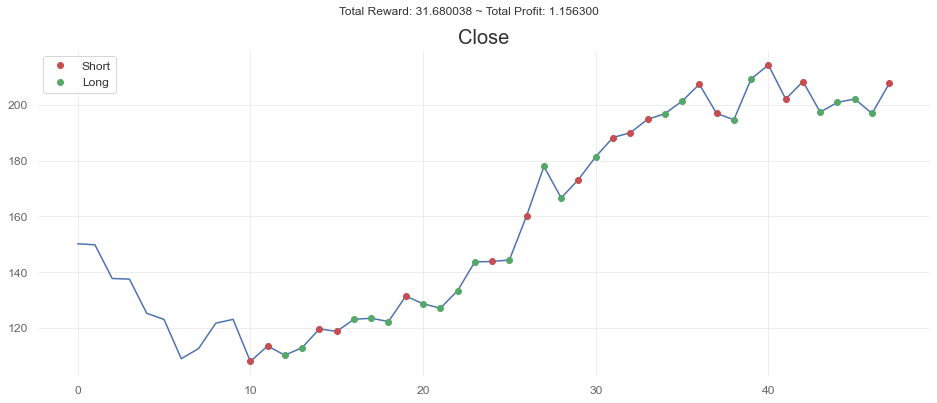

In [18]:
plt.figure(figsize=(16, 6))
env.render_Close()#將「環境」畫出來

# 根據模型預測，position為今天收盤時需要進行的交易策略(Long or Short)

↓↓↓ 台積電(2330)在使用交易策略(Long Or Short)後，隔日早上平倉時的盈虧(含手續費) ↓↓↓


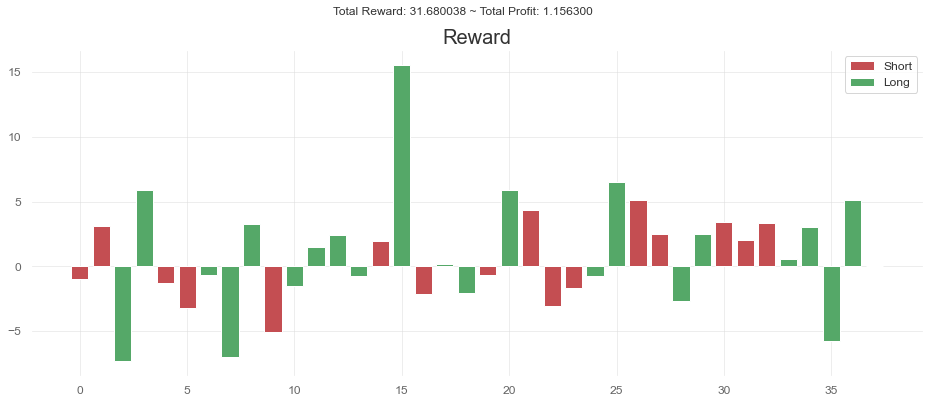

In [19]:
plt.figure(figsize=(16, 6))
env.render_Reward()

↓↓↓ 根據預測出的交易策略交易台積電(2330)，所得到的累積利潤(含手續費) ↓↓↓


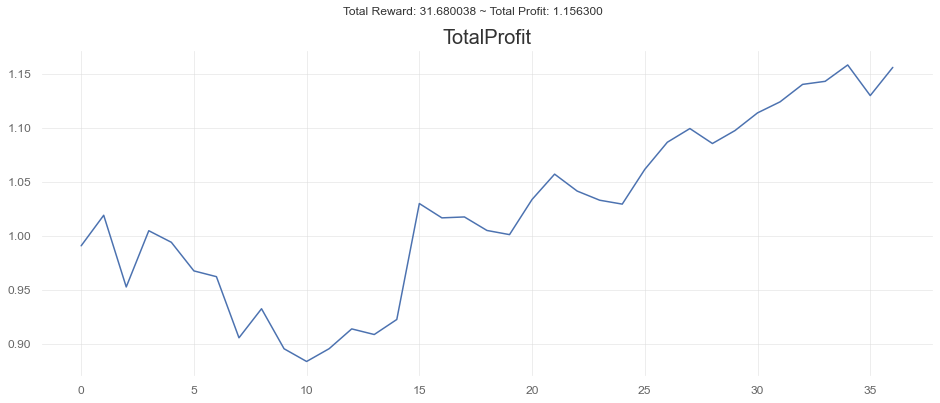

In [20]:
plt.figure(figsize=(16, 6))
env.render_TotalProfit()

# ------------------------------------------------

# 不同技術分析合併進行資料萃取，需要轉換矩陣格式，解釋如下：

In [19]:
# a = np.array([
#     [
#         [1,2,3,4,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6],
#         [2,4,5,6,5,6]
#     ]
# ])
# #-----------------------
# b = np.array([
#     [
#         [1,2],[3,4],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ],
#     [
#         [2,4],[5,6],[5,6]
#     ]
# ])
# #-----------------------
# print('目的：將原本矩陣a，變成矩陣b。因為在機器訓練時，需要讓機器意識到為兩組獨立的參數')
# print('注意：入面組嘅大小必須相同，例如[1,2],[3,4]，但不可以[1,2],[3,4,5]\n\n')
# print('第一個數字：大括號\n第二個數字：有四個打橫\n第三個數字：打橫入面有幾多個數字')
# print(a.shape)
# print(a,'\n')
# print('第一個數字：有幾多大組嘅數字\n第二個數字：入面有幾多個小組\n第三個數字：每個小組入面有幾多個數字')
# print(b.shape)
# print(b)